# Pronostico 2022 - 2026 Maximos Potencia Aparente Estacion Principal 

NOTAS:

Se dispone de los datos del Sistema Tecnico ordenados cada 15 minutos por Estacion. 

La consulta fue usando SQL y se descargo en formato texto plano .prn 

La demanda en 13 KV (consumo de la ciudad) es la que soportan los trafos de la ET mas la Generacion.
Los trafos soportan lo que transforma cada uno de 132 a 13 KV.



## Seteo Inicial

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Viernes 8 Octubre 2021 17:43:11 

@author: Daniel Busso
"""

# Plantilla de Pre Procesado

# Cómo importar las librerías
import numpy    as np
import pandas   as pd
import datetime as dt
import os

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#plt.style.use('fivethirtyeight')

#from statsmodels.graphics.tsaplots import plot_acf
#from statsmodels.graphics.tsaplots import plot_pacf

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore') 

In [4]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [5]:
# Configuracion Pandas

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

## Lectura de las Demandas en 13 Kv 
Lectura y creacion del index DateTime para tratar el DataFrame como una Serie de Tiempo

In [6]:
def conversion_2400(fecha):
    if fecha[11:13] != '24':
        return pd.to_datetime(fecha, format='%d/%m/%Y %H:%M')

    fecha = fecha[0:11] + '00:' + fecha[14:]
    return pd.to_datetime(fecha, format='%d/%m/%Y %H:%M') + dt.timedelta(days=1)

In [7]:
# lEER Y CONCATENAR LOS ARCHIVOS .prn DE LA CARPETA 

import os
import sys
from pathlib import Path

# ELEGIR PLATAFORMA WINDOWS LOCAL O GOOGLE COLABORATORY (la Nube)
if sys.platform == 'linux' :
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  carpeta_trabajo = Path('/content/drive/Othercomputers/LENOVO/eett_prod/san_francisco/Demanda_13') # Google Colab
else:
  carpeta_inicio  = Path.home()
  carpeta_eett = Path("eett_prod/san_francisco/Demanda_13")
  carpeta_trabajo = carpeta_inicio / carpeta_eett

archivos = list(carpeta_trabajo.glob('*.prn'))

# Automatizacion de los DataFrames 
dfconca = pd.DataFrame([])
for nombre_completo in archivos:
    dfdatos = pd.read_fwf(nombre_completo, header=0, decimal=',')
    dfconca = pd.concat([dfconca, dfdatos], ignore_index=True)
    
dfconca    

Fecha   Hora    MW  MVAR   MVA  Ampere  KVolt
0       01/01/2010  00:15 15.80  7.13 17.33  711.24   0.00
1       01/01/2010  00:30 15.63  6.82 17.05  706.06   0.00
2       01/01/2010  00:45 15.49  6.80 16.91  696.61   0.00
3       01/01/2010  01:00 15.55  6.81 16.98  698.32   0.00
4       01/01/2010  01:15 15.50  6.82 16.93  694.93   0.00
...            ...    ...   ...   ...   ...     ...    ...
411454  31/12/2021  23:00 23.25 -2.69 23.41  980.38   4.46
411455  31/12/2021  23:15 22.86 -3.06 23.07  971.29   4.44
411456  31/12/2021  23:30 22.66 -3.20 22.89  972.08   4.43
411457  31/12/2021  23:45 22.77  7.82 24.08  993.98   4.45
411458  31/12/2021  24:00 22.49  7.86 23.82  981.86   4.45

[411459 rows x 7 columns]

In [8]:
# GENERAMOS INDICE DE FECHAS PARA MANEJAR LA SERIE DE TIEMPO

dfconca['Fecha_Hora'] = dfconca['Fecha'] + ' ' + dfconca['Hora']
dfconca['Fecha_Hora'] = dfconca.Fecha_Hora.apply(conversion_2400) # CONVERSION DE HORA 24:00 ---> 00:00

dfconca.set_index('Fecha_Hora', inplace=True)

df_aux = dfconca.drop(dfconca.index[-1]) # borro la fila del nuevo anio
df_ord = df_aux.sort_index()

# COLUMNAS A ANALIZAR
columnas_a_estudiar = ['MW', 'MVAR', 'MVA']
datos = df_ord[columnas_a_estudiar].copy()
demandas = datos.copy()
demandas

MW  MVAR   MVA
Fecha_Hora                           
2010-01-01 00:15:00 15.80  7.13 17.33
2010-01-01 00:30:00 15.63  6.82 17.05
2010-01-01 00:45:00 15.49  6.80 16.91
2010-01-01 01:00:00 15.55  6.81 16.98
2010-01-01 01:15:00 15.50  6.82 16.93
...                   ...   ...   ...
2021-12-31 22:45:00 23.42 -2.79 23.58
2021-12-31 23:00:00 23.25 -2.69 23.41
2021-12-31 23:15:00 22.86 -3.06 23.07
2021-12-31 23:30:00 22.66 -3.20 22.89
2021-12-31 23:45:00 22.77  7.82 24.08

[411458 rows x 3 columns]

## Depuracion

### Duplicados

In [10]:
if datos.index.has_duplicates:
    print('SI TIENE DUPLICADOS')
else:
    print('NO TIENE DUPLICADOS')

NO TIENE DUPLICADOS


### Chequeo Mediciones Faltantes 

Si dife distinto de cero, significa que faltan registros/filas en los datos del SITEC

NOTA: Por el momento, no vamos a imputar estos Datos Faltantes ----> NO TIENE SENTIDO POR LA CANTIDAD DE DATOS

In [11]:
#dti2 = pd.date_range(start='2017-01-01 00:15:00', end='2018-01-01 00:00:00', freq="15min")
#
# No se si es tan completo porque a partir del anio 2016 las mediciones van cada 5 min
indice_completo = pd.date_range(start=datos.index[0], end=datos.index[-1], freq="15min")
#
dife = indice_completo.difference(datos.index)

if dife.empty == False:
    print('Faltan algunas Mediciones: ', len(dife), '% Incompletas= ', (len(dife)/len(indice_completo)*100), '% Completas= ', \
          (((len(indice_completo)-len(dife))/len(indice_completo))*100))
else:
    print('\n')
    print('Mediciones Completas: ', (((len(indice_completo)-len(dife))/len(indice_completo))*100))

Faltan algunas Mediciones:  9309 % Incompletas=  2.2123883289326396 % Completas=  97.78761167106737


In [12]:
dife

DatetimeIndex(['2010-08-14 00:00:00', '2010-11-10 00:15:00',
               '2010-11-10 00:30:00', '2010-11-10 00:45:00',
               '2010-11-10 01:00:00', '2010-11-10 01:15:00',
               '2010-11-10 01:30:00', '2010-11-10 01:45:00',
               '2010-11-10 02:00:00', '2010-11-10 02:15:00',
               ...
               '2021-09-17 08:45:00', '2021-09-17 09:00:00',
               '2021-09-17 09:15:00', '2021-09-17 09:30:00',
               '2021-09-18 08:45:00', '2021-09-18 09:00:00',
               '2021-09-18 09:15:00', '2021-09-18 09:30:00',
               '2021-12-03 09:00:00', '2021-12-03 09:15:00'],
              dtype='datetime64[ns]', length=9309, freq=None)

In [13]:
#
# OBTENGO LAS MEDICIONES FALTANTES FECHAS-HORA SIN MEDICION

dsm = pd.DataFrame({'Mediciones Faltantes':dife}, index=dife)
dsm['anio'] = dsm.index.year
dsm['mes']  = dsm.index.month
dsm['dia']  = dsm.index.day
dsm

Mediciones Faltantes  anio  mes  dia
2010-08-14 00:00:00  2010-08-14 00:00:00  2010    8   14
2010-11-10 00:15:00  2010-11-10 00:15:00  2010   11   10
2010-11-10 00:30:00  2010-11-10 00:30:00  2010   11   10
2010-11-10 00:45:00  2010-11-10 00:45:00  2010   11   10
2010-11-10 01:00:00  2010-11-10 01:00:00  2010   11   10
...                                  ...   ...  ...  ...
2021-09-18 09:00:00  2021-09-18 09:00:00  2021    9   18
2021-09-18 09:15:00  2021-09-18 09:15:00  2021    9   18
2021-09-18 09:30:00  2021-09-18 09:30:00  2021    9   18
2021-12-03 09:00:00  2021-12-03 09:00:00  2021   12    3
2021-12-03 09:15:00  2021-12-03 09:15:00  2021   12    3

[9309 rows x 4 columns]

In [14]:
# AGRUPO LAS MEDICIONES FALTANTES
#
dsm_grp = dsm.groupby(by=['anio','mes', 'dia'])
med_faltantes = dsm_grp.count()
med_faltantes

Mediciones Faltantes
anio mes dia                      
2010 8   14                      1
     11  10                     95
         11                      1
2011 2   3                       1
2012 1   12                     95
...                            ...
2021 8   13                      5
         27                      1
     9   17                      6
         18                      4
     12  3                       2

[278 rows x 1 columns]

### Analizar y Encontrar Errores de Medicion usando graficas

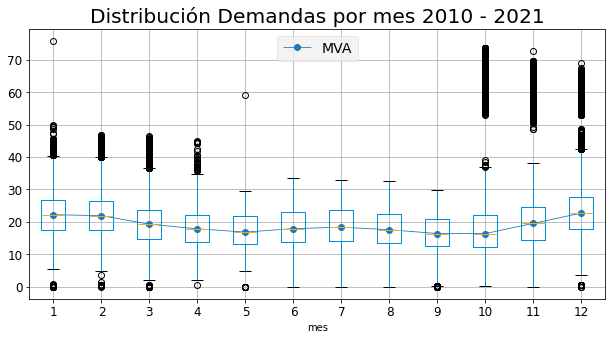

In [15]:
# Gráfico boxplot para estacionalidad anual 
# Cada Box Plot grafica el mes para los 12 anios 
# Por ejemplo Octubre '10' son todos los valores de Octubre en los 12 anios
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
plt.style.use('fivethirtyeight')

datos['mes'] = datos.index.month
datos.boxplot(column='MVA', by='mes', ax=ax)
datos.groupby('mes')['MVA'].median().plot(style='o-', linewidth=0.8, ax=ax)

# ESTETICA DEL GRAFICO
plt.xticks(fontsize=12)  #plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=12)
#ax.set_ylabel('Demandas')
ax.set_title('Distribución Demandas por mes 2010 - 2021')
ax.legend()
fig.suptitle('');

In [16]:
# Gráfico boxplot para estacionalidad anual 
# Blox Plot para todos los anios
# ==============================================================================

def Grafica_Caja(pi, pf):
    
    plt.style.use('fivethirtyeight')
    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(30, 5), dpi=100)  # (15, 5)
    
    # PREPARO LOS DATOS
    datos['mes']  = datos.index.month
    datos['anio'] = datos.index.year
    datos2 = datos[pi:pf]
    
    # GRAFICO EL BOXPLOT
    datos2.boxplot(column='MVA', by=['anio','mes'], ax=ax)
    
    # GRAFICO LA LINEA DE MEDIANA
    y = datos2.groupby(by=['anio','mes'])['MVA'].median()
    pos_sup = y.index.shape[0] + 1
    x = np.arange(1, pos_sup)
    ax.plot(x, y, lw=1.5, label='Mediana [MVA]', marker='o')
    #datos3.groupby(by=['anio','mes'])['MVA'].median().plot(style='o-', linewidth=0.8, ax=ax)
    
    # ESTETICA DEL GRAFICO
    plt.xticks(fontsize=12, rotation=90)  #plt.xticks(fontsize=15, rotation=90)
    plt.yticks(fontsize=12)
    #ax.set_ylabel('Demandas')
    ax.set_title('Distribución Demandas por Mes ' +pi+' - '+pf)
    ax.legend() 
    fig.suptitle('');
    plt.show()

<Figure size 432x288 with 0 Axes>

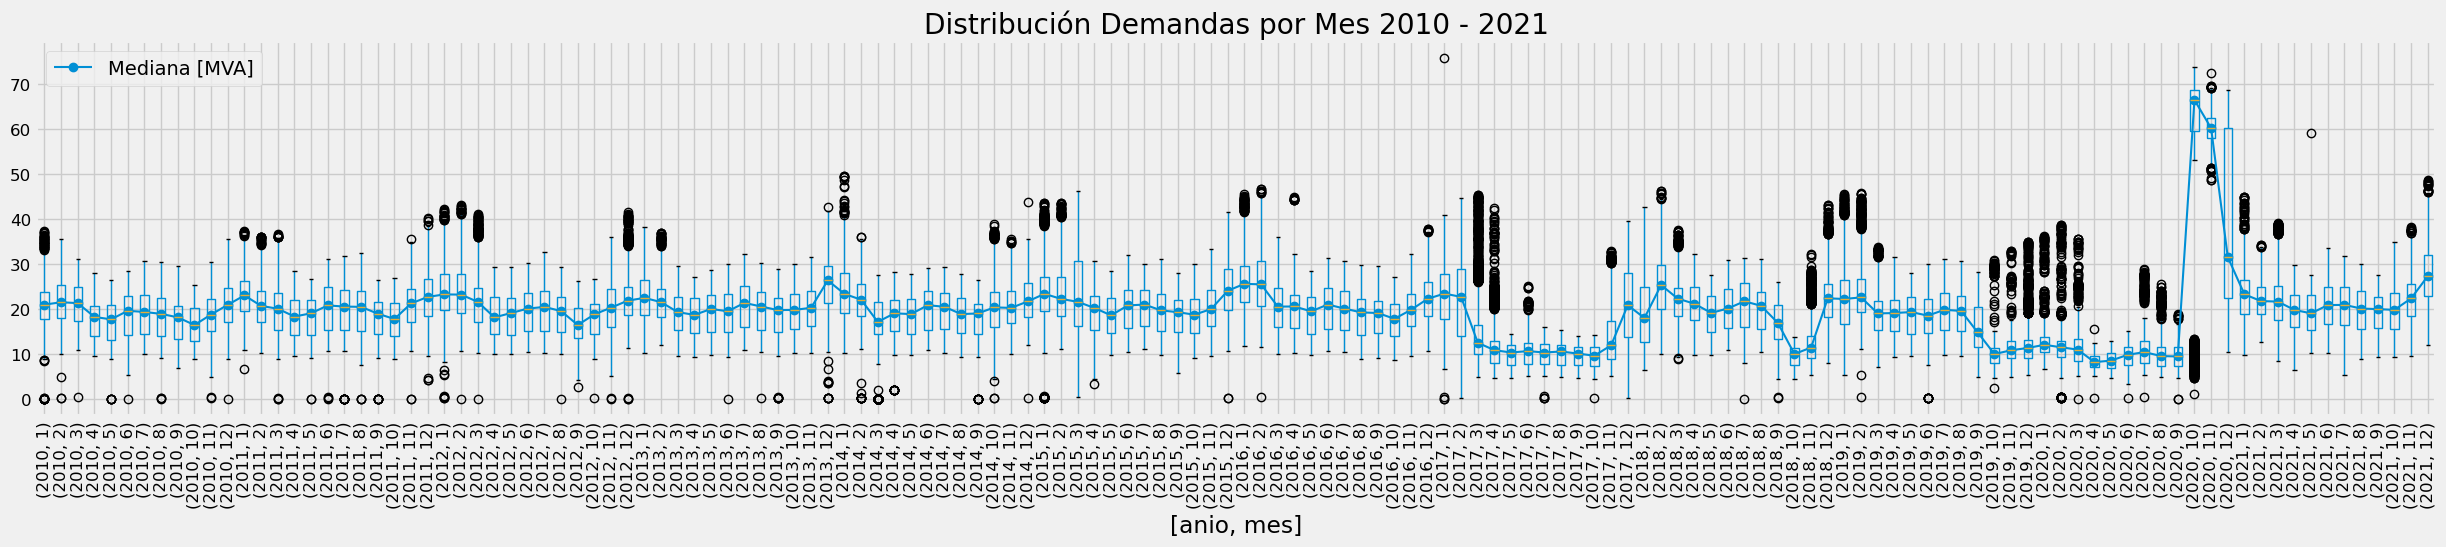

In [17]:
Grafica_Caja('2010', '2021')

<Figure size 432x288 with 0 Axes>

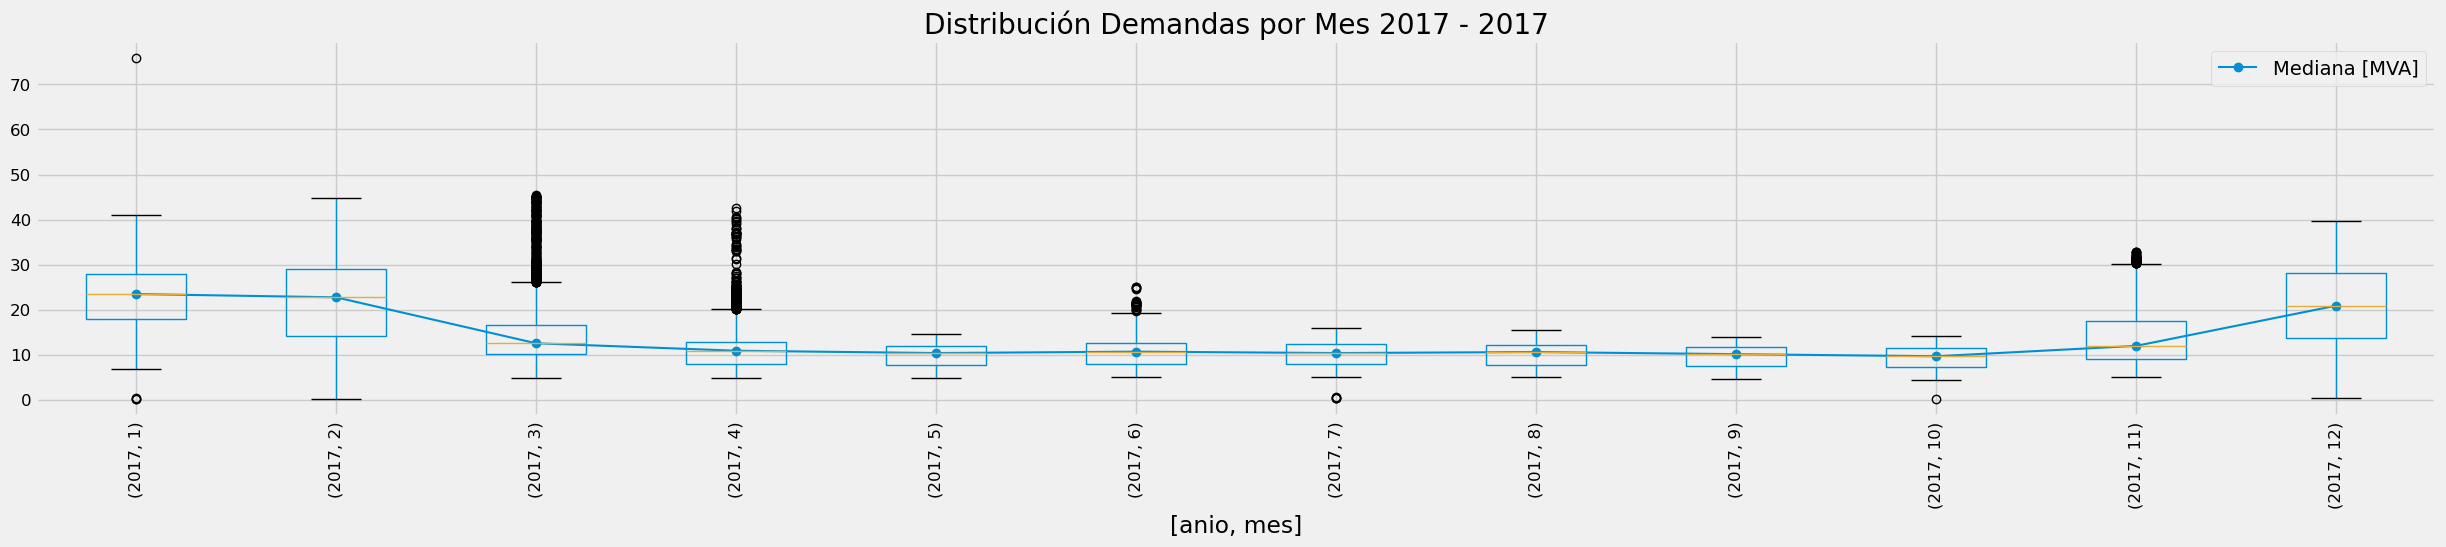

In [18]:
Grafica_Caja('2017', '2017')

<Figure size 432x288 with 0 Axes>

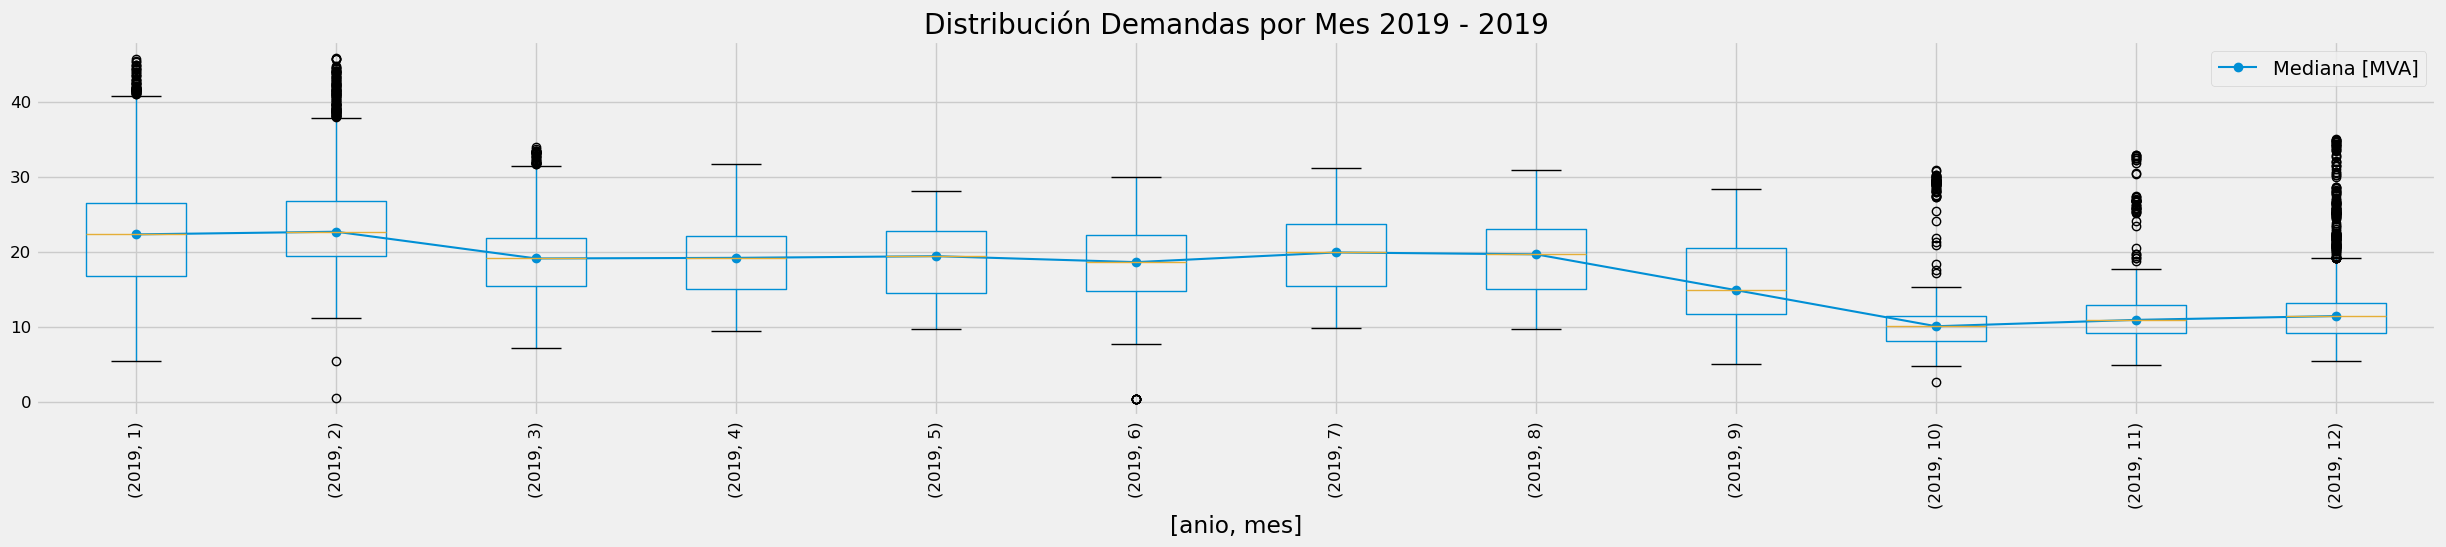

In [19]:
Grafica_Caja('2019', '2019')

<Figure size 432x288 with 0 Axes>

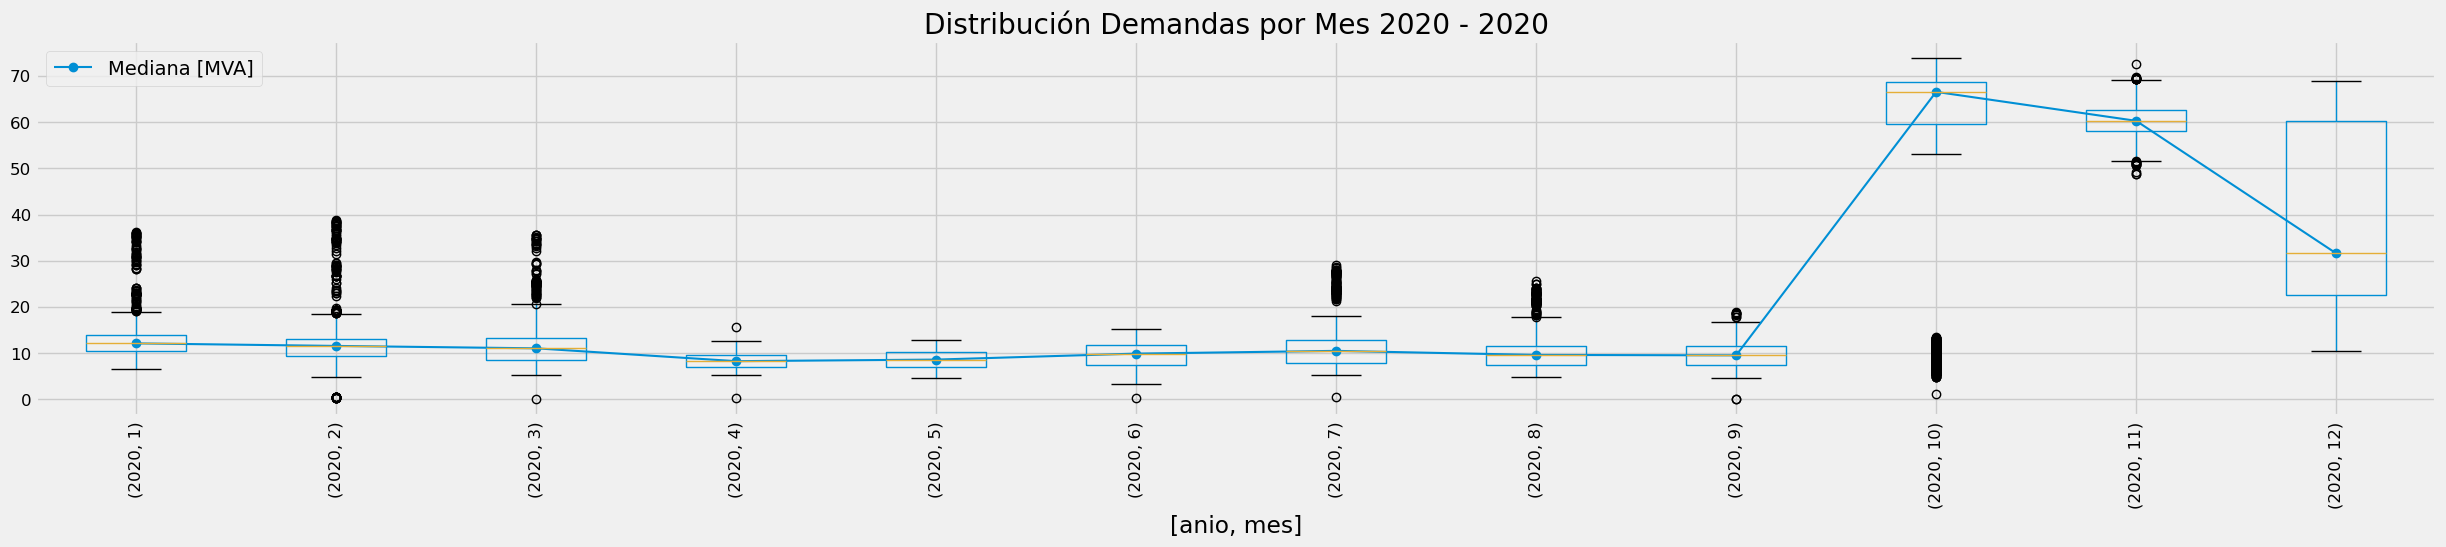

In [20]:
Grafica_Caja('2020', '2020')

<Figure size 432x288 with 0 Axes>

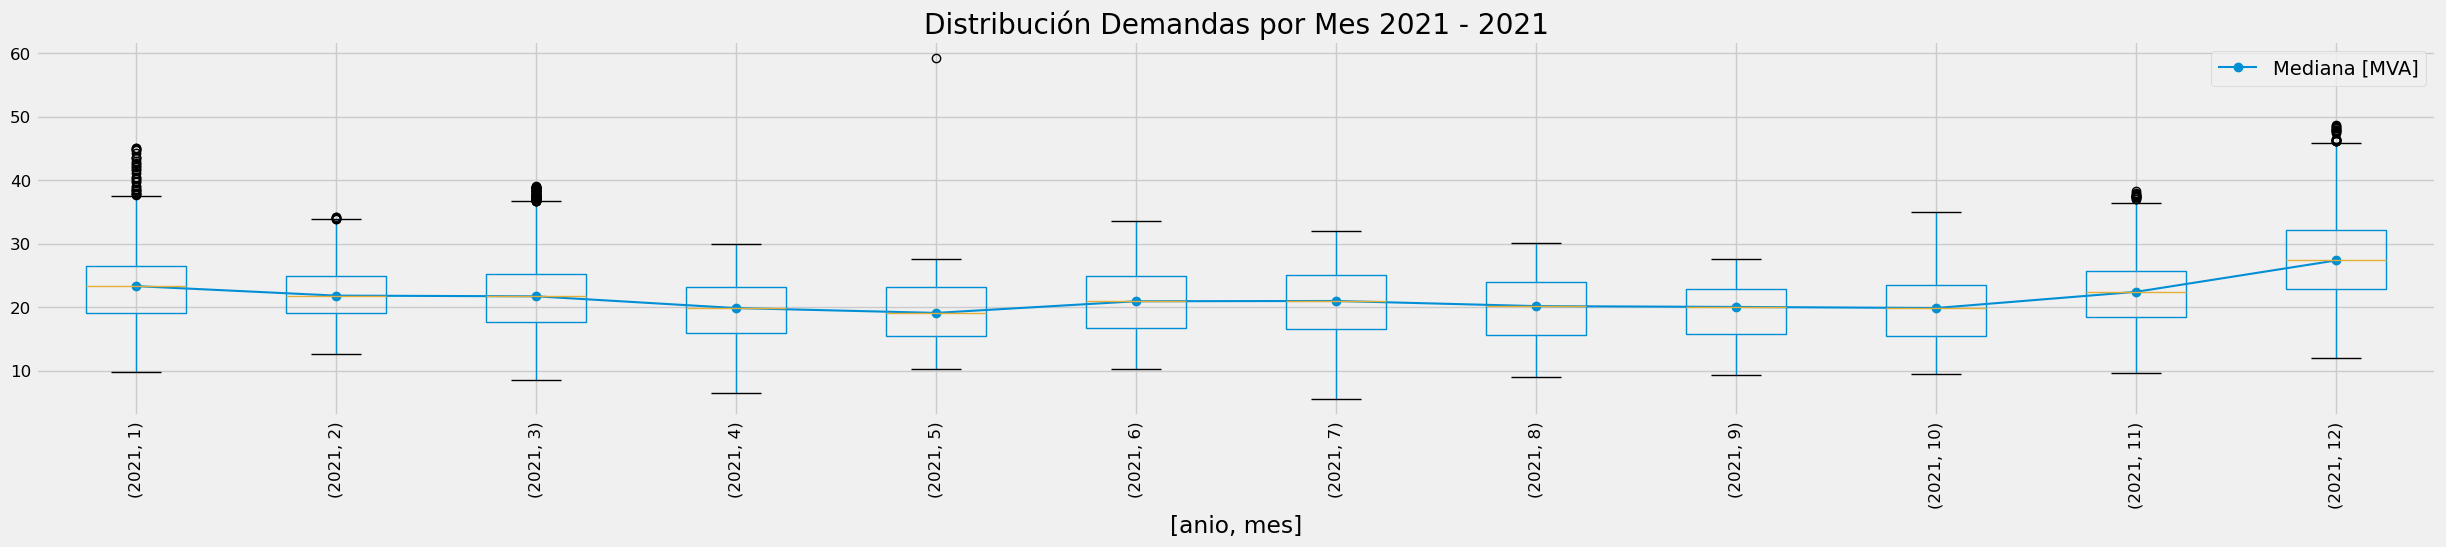

In [21]:
Grafica_Caja('2021', '2021')

### Valores constantes

In [22]:
columnas_a_estudiar = ['MW', 'MVAR', 'MVA']
#columnas_a_estudiar = ['MW']

#valores_cte = datos[columnas_a_estudiar].resample('H').std()
desviacion_std = datos[columnas_a_estudiar].resample('H').std().eq(0.00)
desviacion_std

MW   MVAR    MVA
Fecha_Hora                              
2010-01-01 00:00:00  False  False  False
2010-01-01 01:00:00  False  False  False
2010-01-01 02:00:00  False  False  False
2010-01-01 03:00:00  False  False  False
2010-01-01 04:00:00  False  False  False
...                    ...    ...    ...
2021-12-31 19:00:00  False  False  False
2021-12-31 20:00:00  False  False  False
2021-12-31 21:00:00  False  False  False
2021-12-31 22:00:00  False  False  False
2021-12-31 23:00:00  False  False  False

[105192 rows x 3 columns]

In [23]:
valores_cte = desviacion_std[desviacion_std['MVA'] == True]
valores_cte.index

DatetimeIndex(['2010-01-05 20:00:00', '2010-01-13 10:00:00',
               '2010-01-13 11:00:00', '2010-01-13 12:00:00',
               '2010-01-13 13:00:00', '2010-02-07 10:00:00',
               '2010-02-19 14:00:00', '2010-02-19 15:00:00',
               '2010-08-13 23:00:00', '2011-02-15 08:00:00',
               ...
               '2020-12-26 11:00:00', '2021-06-22 01:00:00',
               '2021-06-22 02:00:00', '2021-06-22 03:00:00',
               '2021-08-05 21:00:00', '2021-08-05 22:00:00',
               '2021-08-11 05:00:00', '2021-10-12 13:00:00',
               '2021-10-12 14:00:00', '2021-10-12 15:00:00'],
              dtype='datetime64[ns]', name='Fecha_Hora', length=519, freq=None)

In [24]:
#
# OBTENGO LAS MEDICIONES ERRONEAS FECHAS-HORA VALORES ERRONEOS DE MEDICION

vem = pd.DataFrame({'Mediciones Erroneas':valores_cte.index}, index=valores_cte.index) # vem Valores Erroneos de Medicion
vem['anio'] = vem.index.year
vem['mes']  = vem.index.month
vem['dia']  = vem.index.day
vem['hora']  = vem.index.hour
vem

Mediciones Erroneas  anio  mes  dia  hora
Fecha_Hora                                                   
2010-01-05 20:00:00 2010-01-05 20:00:00  2010    1    5    20
2010-01-13 10:00:00 2010-01-13 10:00:00  2010    1   13    10
2010-01-13 11:00:00 2010-01-13 11:00:00  2010    1   13    11
2010-01-13 12:00:00 2010-01-13 12:00:00  2010    1   13    12
2010-01-13 13:00:00 2010-01-13 13:00:00  2010    1   13    13
...                                 ...   ...  ...  ...   ...
2021-08-05 22:00:00 2021-08-05 22:00:00  2021    8    5    22
2021-08-11 05:00:00 2021-08-11 05:00:00  2021    8   11     5
2021-10-12 13:00:00 2021-10-12 13:00:00  2021   10   12    13
2021-10-12 14:00:00 2021-10-12 14:00:00  2021   10   12    14
2021-10-12 15:00:00 2021-10-12 15:00:00  2021   10   12    15

[519 rows x 5 columns]

In [27]:
# AGRUPO LAS MEDICIONES ERRONEAS
#

vem_grp = vem.groupby(by=['anio','mes', 'dia'])
med_erroneas = vem_grp.count()
#med_erroneas

In [29]:
# TODAS LAS MEDICIONES ERRONEAS SON 1 (ES NECESARIO AGRUPARLAS)
# USAR UN CRITERIO PARA AGRUPAR

med_erroneas.loc[med_erroneas['Mediciones Erroneas'] > 3] 

Mediciones Erroneas  hora
anio mes dia                           
2010 1   13                     4     4
2011 3   9                      8     8
     12  11                     5     5
         12                     9     9
2012 6   29                     5     5
     11  7                      5     5
2013 7   1                     18    18
         2                     24    24
         3                     24    24
         4                     14    14
     12  3                      7     7
         29                     5     5
         30                    17    17
         31                    24    24
2014 1   1                     22    22
         2                     14    14
     3   18                    20    20
         19                    11    11
         21                    16    16
         22                     8     8
     4   6                     19    19
         7                     10    10
         8                      6     6
     9   18                     4     4
         27                     9     9
         28                    11    11
2015 1   11                     7     7
2016 3   8                      6     6
     4   21                     5     5
         22                    16    16
     5   10                     5     5
     8   15                     6     6
2017 11  30                    13    13
     12  1                     12    12
         20                     4     4
2018 1   13                     9     9
     8   7                      7     7
         8                     12    12
2019 6   16                     4     4
     10  26                     7     7
         27                    14    14

In [30]:
# CALCULO FORMAL DE LOS LIMITES SUPERIOR E INFERIOR
# Demanda = Transformacion 132/13 Kv + Generacion Propia
# Demanda = TD1 + TD2 + TD3 + TG1 + TG2

#===============================================================================================================
# LA IDEA ES CALCULAR LOS LIMITES PARA PERIODOS ESTIVALES DE 6 MESES
# PERIODO VERANO1  '2020-01-01':'2020-03-31'
# PERIODO INVIERNO '2020-04-01:2020-09-30'
# PERIODO VERANO2  '2020-10-01:2020-12-31'
#
def lim_sup(q75, q25):
    IQR = q75 - q25
    bigote = 3 * IQR       # LO NORMAL SE USA 1.5
    return (q75 + bigote)
    
atipicos = pd.Series([])    
anios = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
for anio in anios:
    ver1i = anio + '-01-01 00' 
    ver1f = anio + '-03-31 23'
    invi  = anio + '-04-01 00' 
    invf  = anio + '-09-30 23'
    ver2i = anio + '-10-01 00' 
    ver2f = anio + '-12-31 23'
    
    #verano1  = demandas.loc[ver1i:ver1f, 'MVA'].resample('D').max()
    #invierno = demandas.loc[invi:invf, 'MVA'].resample('D').max()
    #verano2  = demandas.loc[ver2i:ver2f, 'MVA'].resample('D').max()
    verano1  = demandas.loc[ver1i:ver1f, 'MVA']
    invierno = demandas.loc[invi:invf, 'MVA']
    verano2  = demandas.loc[ver2i:ver2f, 'MVA']
    
    lim_sup_ver1 = lim_sup(verano1.quantile(0.75), verano1.quantile(0.25)) 
    lim_sup_inv  = lim_sup(invierno.quantile(0.75), invierno.quantile(0.25)) 
    lim_sup_ver2 = lim_sup(verano2.quantile(0.75), verano2.quantile(0.25)) 
    
    # REMOVER EJEMPLOS DE ATIPICOS 
    #indice1 = pd.to_datetime('2010-01-01 19:08:08')
    #indice  = pd.to_datetime('2010-04-01 19:12:12')
    #indice2 = pd.to_datetime('2010-10-01 19:14:14')
    #demandas.loc[indice1, 'MVA'] = 150.0
    #demandas.loc[indice, 'MVA'] = 150.0
    #demandas.loc[indice2, 'MVA'] = 150.0
    
    # GUARDAR LOS ATIPICOS A REMOVER Y LOS VALORES
    atipicos_ver1 = verano1[verano1   > lim_sup_ver1] 
    atipicos_inv  = invierno[invierno > lim_sup_inv]
    atipicos_ver2 = verano2[verano2   > lim_sup_ver2]    
    atipicos = pd.concat([atipicos, atipicos_ver1, atipicos_inv, atipicos_ver2]) 

atipicos_ord = atipicos.sort_index()
#datos = demandas.drop(atipicos.index)
atipicos_ord

2017-01-27 09:30:00   75.78
2017-04-22 08:15:00   28.43
2017-04-22 08:30:00   28.23
2017-04-22 08:45:00   42.52
2017-04-22 09:00:00   41.99
                       ... 
2020-08-22 11:45:00   22.96
2020-08-22 12:15:00   22.92
2020-08-22 13:30:00   23.74
2020-08-22 13:45:00   23.29
2021-05-04 11:30:00   59.22
Length: 476, dtype: float64

### Borrar Mediciones Erroneas

In [31]:
#
# BORRAMOS ERRORES DE MEDICION ENCONTRADAS

#foto = datos.loc['2017-01-27 09:30:00':'2017-01-27 09:30:00'].index
#datos = datos.drop(foto)

# BORRAMOS EL PICO DEL ANIO 01/2017
indice = datos.loc['2017-01', 'MVA'].idxmax()
datos = datos.drop(indice)

#
# BORRAMOS DATOS ANIO 10-11-12/2020
#
desde = '2020-10-06 17:15:00'
hasta = '2020-12-14 14:45:00'
indice = datos.loc[desde:hasta].index
datos  = datos.drop(indice)


desde = pd.to_datetime(desde)
hasta = pd.to_datetime(hasta)
duracion = hasta - desde
print('Se borro: ', duracion, 'que equivale a tantas mediciones tomadas de a 15 min') 

# BORRAMOS PICO DEL ANIO 05/2021
indice = datos.loc['2021-05', 'MVA'].idxmax()
datos = datos.drop(indice)

Se borro:  68 days 21:30:00 que equivale a tantas mediciones tomadas de a 15 min


## Graficas Anuales

### Box Plot Mensual del total de Datos

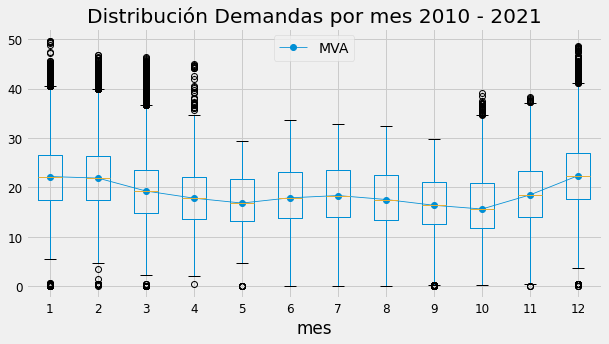

In [32]:
# Gráfico boxplot para estacionalidad anual 
# Cada Box Plot grafica el mes para los 12 anios 
# Por ejemplo Octubre '10' son todos los valores de Octubre en los 12 anios
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
plt.style.use('fivethirtyeight')

datos['mes'] = datos.index.month
datos.boxplot(column='MVA', by='mes', ax=ax)
datos.groupby('mes')['MVA'].median().plot(style='o-', linewidth=0.8, ax=ax)

# ESTETICA DEL GRAFICO
plt.xticks(fontsize=12)  #plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=12)
#ax.set_ylabel('Demandas')
ax.set_title('Distribución Demandas por mes 2010 - 2021')
ax.legend()
fig.suptitle('');

### Blox Plot Mensual

In [33]:
# Gráfico boxplot para estacionalidad anual 
# Blox Plot para todos los anios
# ==============================================================================

def Grafica_Caja(pi, pf):
    
    plt.style.use('fivethirtyeight')
    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(30, 5), dpi=100)  # (15, 5)
    
    # PREPARO LOS DATOS
    datos['mes']  = datos.index.month
    datos['anio'] = datos.index.year
    datos2 = datos[pi:pf]
    
    # GRAFICO EL BOXPLOT
    datos2.boxplot(column='MVA', by=['anio','mes'], ax=ax)
    
    # GRAFICO LA LINEA DE MEDIANA
    y = datos2.groupby(by=['anio','mes'])['MVA'].median()
    pos_sup = y.index.shape[0] + 1
    x = np.arange(1, pos_sup)
    ax.plot(x, y, lw=1.5, label='Mediana [MVA]', marker='o')
    #datos3.groupby(by=['anio','mes'])['MVA'].median().plot(style='o-', linewidth=0.8, ax=ax)
    
    # ESTETICA DEL GRAFICO
    plt.xticks(fontsize=12, rotation=90)  #plt.xticks(fontsize=15, rotation=90)
    plt.yticks(fontsize=12)
    #ax.set_ylabel('Demandas')
    ax.set_title('Distribución Demandas por Mes ' +pi+' - '+pf)
    ax.legend() 
    fig.suptitle('');

### Grafica Maximos Semanales

In [34]:
# GRAFICA MAXIMOS SEMANALES

def Grafica_xSemana(pi, pf):
    z = datos.loc[pi:pf, 'MVA'].resample('W').max() # Datos
    x = z.index # Tiempo

    plt.style.use('fivethirtyeight')
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5), dpi=100)
    
    grafico.plot(x, z, lw=1, label='Potencia Aparente', marker='o')
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE SEMANAL " + pi + ' ' + pf)  # Add a title to the axes.
    #grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    #fig.savefig("Todos_Anios_xSemana.png")

### Grafica Por Minuto (cada 15 Minutos)

In [35]:
# Grafica anual de la Potencia Aparente cada 15 minutos

def Grafica_xmin(pi, pf):
    y = datos.loc[pi:pf, 'MVA']
    x = y.index
    
    plt.style.use('fivethirtyeight')
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5), dpi=100)
    
    grafico.plot(x, y, lw=1.5, marker='o', label='Potencia Aparente x Minuto')
    # grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE [cada 15 minutos] " + pi +' '+ pf)  # Add a title to the axes.
    #grafico.legend(loc='lower left')  # Add a legend.
    
    #grafico.grid(visible='True', which='major', axis='both', color='black', alpha=1, linewidth=0.5)
    grafico.grid(visible='True', which='major', axis='both', color='black', linewidth=0.5)
    grafico.grid(visible='True', which='minor', axis='both', color='black', linewidth=0.5)
    
    x2 = pd.date_range(start=pi+'-01-01', end=pf+'-12-31', periods=5)
    grafico.set_xticks(x2)
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    #fig.savefig("Serie_Anual_15min_"+anio+".png")

### Grafica por Dia

In [36]:
# Grafica del Pico Maximo Potencia Aparente x DIA
from matplotlib import ticker

def Grafica_xDia(pi, pf):
    y = datos.loc[pi:pf, 'MVA'].resample('D').max()
    x = y.index
    
    plt.style.use('fivethirtyeight')
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5), dpi=100)
    
    grafico.plot(x, y, lw=1.5, label='Potencia Aparente x Dia', marker='o')
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE DIARIA " + anio)  # Add a title to the axes.
    #grafico.legend(loc='lower left')  # Add a legend.
    
    #grafico.grid(visible='True', which='major', axis='both', color='black', alpha=1, linewidth=0.5)
    grafico.grid(visible='True', which='major', axis='both', color='black', linewidth=0.5)
    grafico.grid(visible='True', which='minor', axis='both', color='black', linewidth=0.5)
    
    x2 = pd.date_range(start=pi+'-01-01', end=pf+'-12-31', periods=5)
    grafico.set_xticks(x2)
    
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    #fig.savefig("Serie_Anual_xDia_"+anio+".png")         

### Grafica del Pico Maximo Anual

In [37]:
# GRAFICA DEL PICO MAXIMO POTENCIA APARENTE (CADA 15 MINUTOS) VENTANA 12 hs ANTES y 12 hs DESPUES
#
def Grafica_Pico_Anual(pi, pf):
    indice_max = datos.loc[pi:pf, 'MVA'].idxmax()
    delta = pd.Timedelta('12 hours')
    indice_mas12   = indice_max + delta
    indice_menos12 = indice_max - delta
    maximo = datos.loc[indice_menos12:indice_mas12, 'MVA'].max()
    
    y = datos.loc[indice_menos12 : indice_mas12, 'MVA'] # Datos
    x = y.index  # Tiempo
    
    plt.style.use('fivethirtyeight')
    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(10, 3), dpi=100) #fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
    #Rotulo = 'Pico: ' + str(indice_max) + ' ' + str(maximo)
    
    ax.plot(x, y, lw=1, marker='o') #ax.plot(x, y, lw=1, label=Rotulo, marker='o')
    ax.minorticks_on()
    #ax.grid(b=True, which='major', color='blue', alpha=1, linewidth=1)
    #ax.grid(b=True, which='minor', color='beige', alpha=1, linewidth=1)
    # Major Tick Label
    # Minor Tick Label
    plt.xticks(fontsize=10, rotation=90)
    plt.yticks(fontsize=10)
    ax.set_xlabel('[ Horas ]', fontsize=10)  # Add an x-label to the axes.
    ax.set_ylabel('[ MVA ]', fontsize=10)  # Add a y-label to the axes.
    ax.set_title("PICO MAXIMO POTENCIA APARENTE " + str(maximo) + ' ' + str(indice_max), fontsize=12)  # Add a title to the axes.
    #ax.legend(loc='lower left', fontsize=10)  # Add a legend.
    #fig.savefig("Pico_Anual_"+anio+".png")
        
    
    #print(indice_menos12)
    print(indice_max, datos.loc[indice_menos12:indice_mas12, 'MW'].max(), datos.loc[indice_menos12:indice_mas12, 'MVA'].max())
    #print(indice_mas12)
    #maximo = datos.loc[indice_max:indice_max, 'MVA']
    #print(maximo[0])

2010-01-05 14:00:00 36.24 37.32
2011-12-20 13:30:00 39.13 40.2
2012-02-16 14:00:00 42.13 43.18
2013-12-26 15:00:00 41.97 42.7
2014-01-23 14:00:00 48.77 49.73
2015-03-11 14:00:00 44.64 46.34
2016-02-12 13:15:00 45.98 46.79
2017-03-02 13:15:00 45.16 45.48
2018-02-07 13:45:00 46.22 46.35
2019-02-22 14:15:00 45.63 45.77
2020-12-28 13:15:00 41.71 41.74
2021-12-29 14:15:00 48.65 48.67


<Figure size 432x288 with 0 Axes>

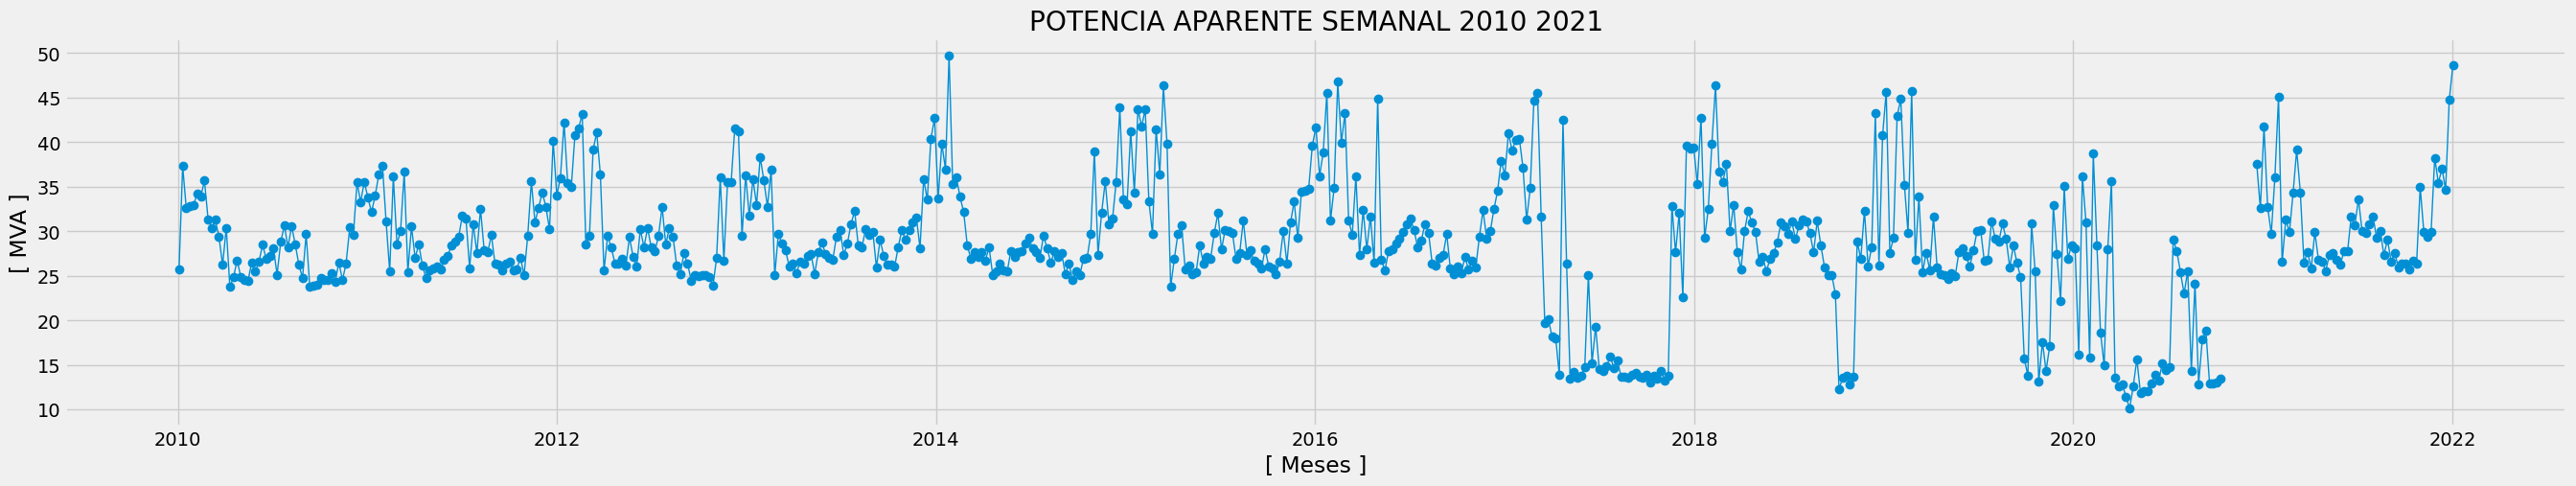

<Figure size 432x288 with 0 Axes>

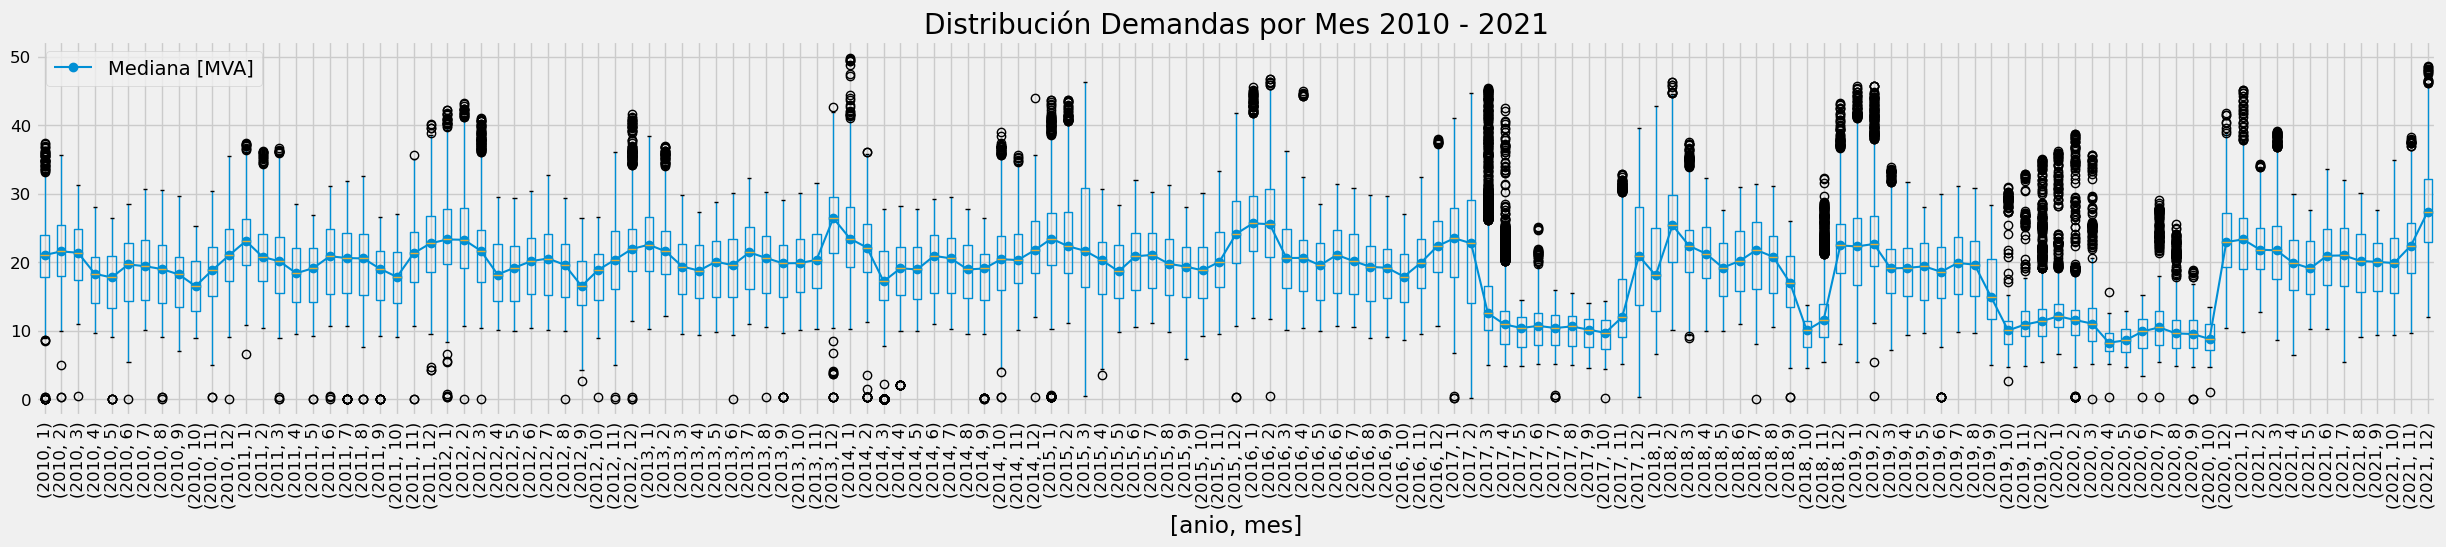

<Figure size 432x288 with 0 Axes>

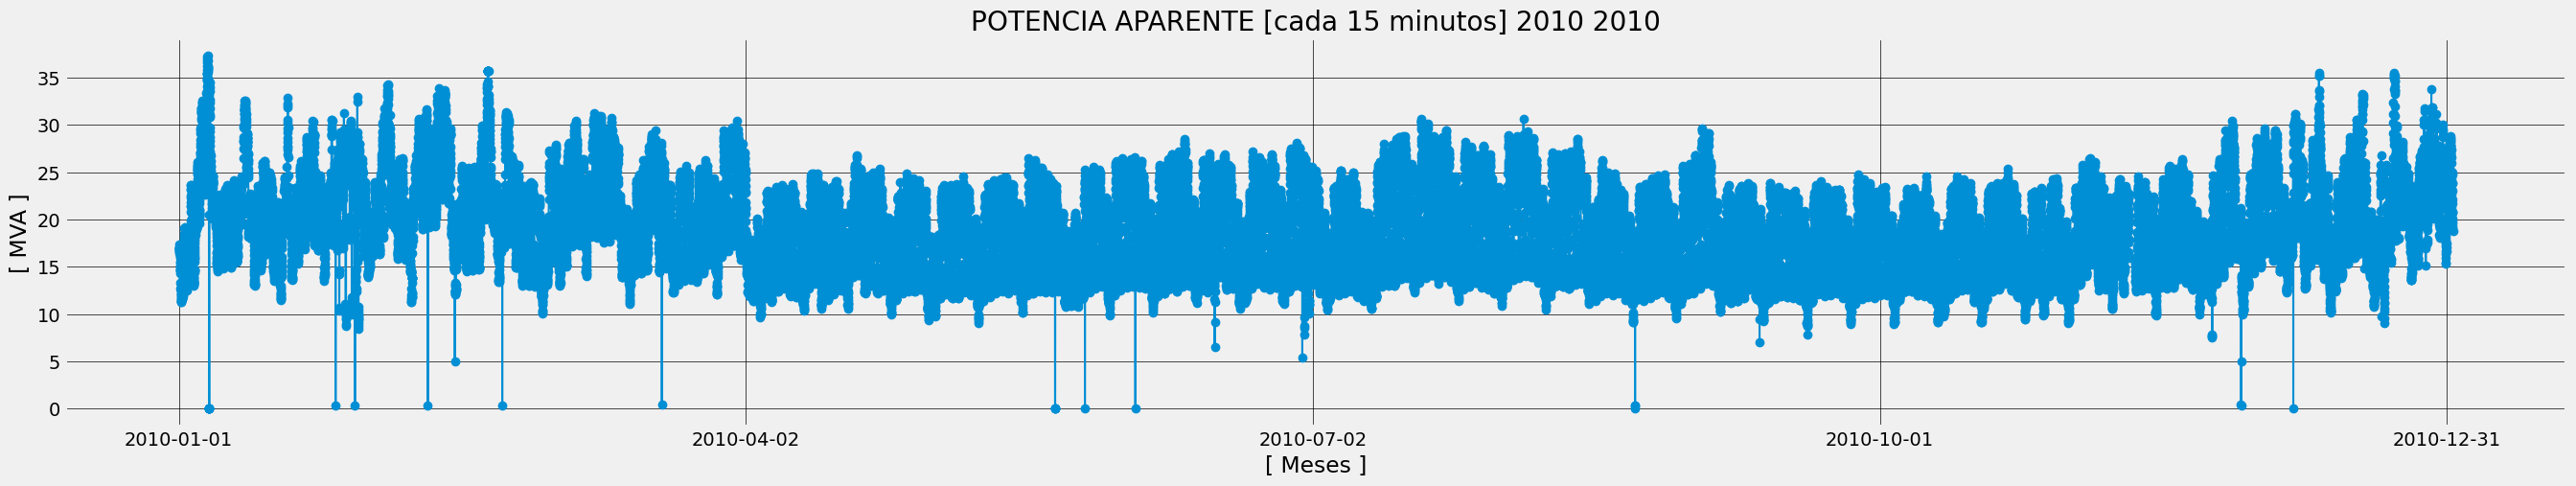

<Figure size 432x288 with 0 Axes>

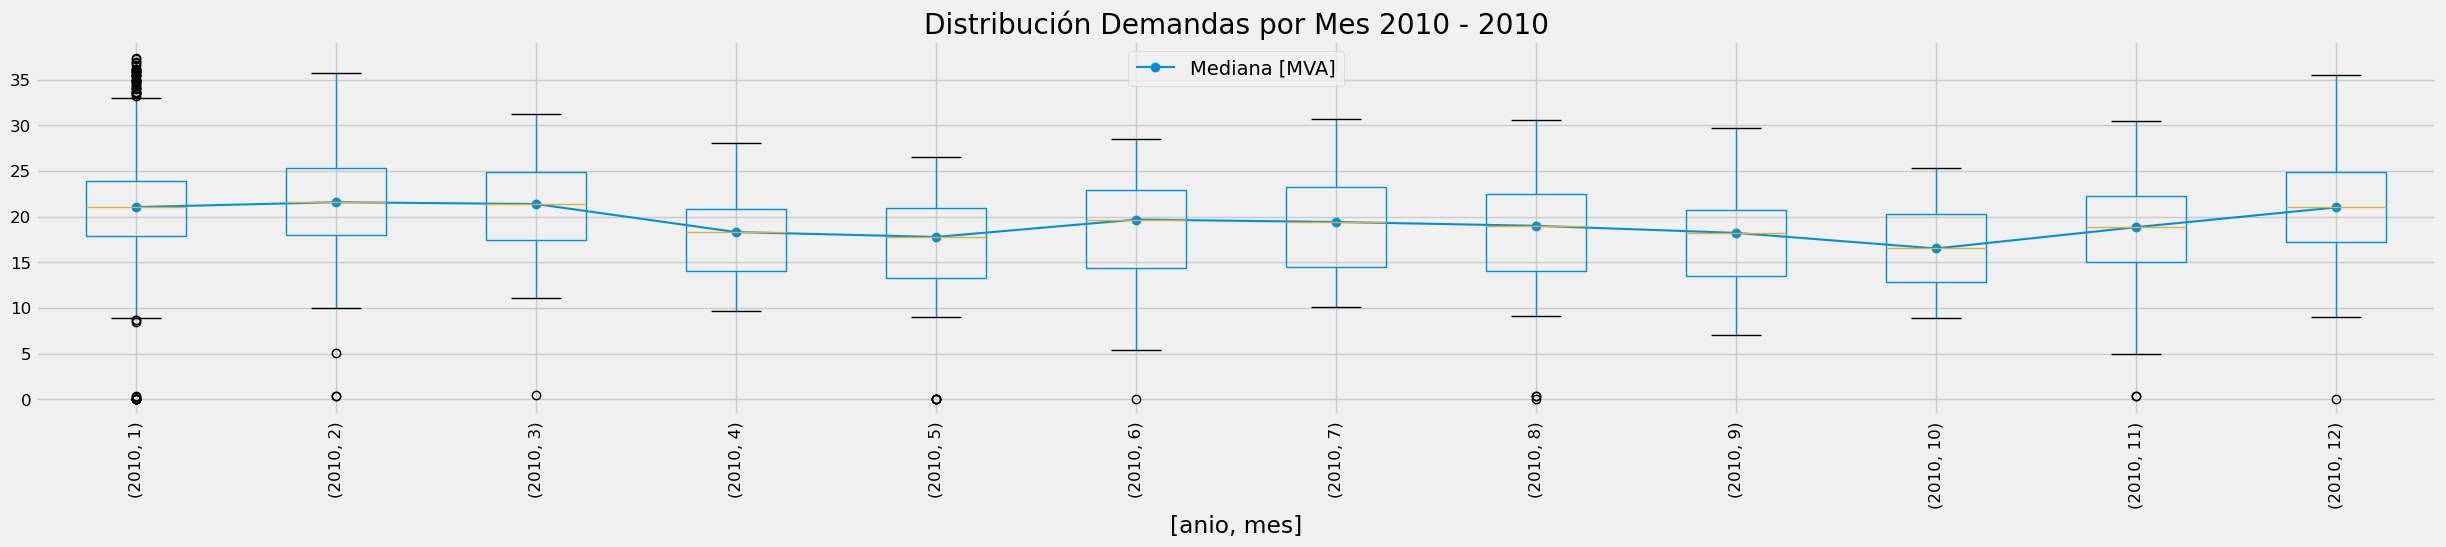

<Figure size 432x288 with 0 Axes>

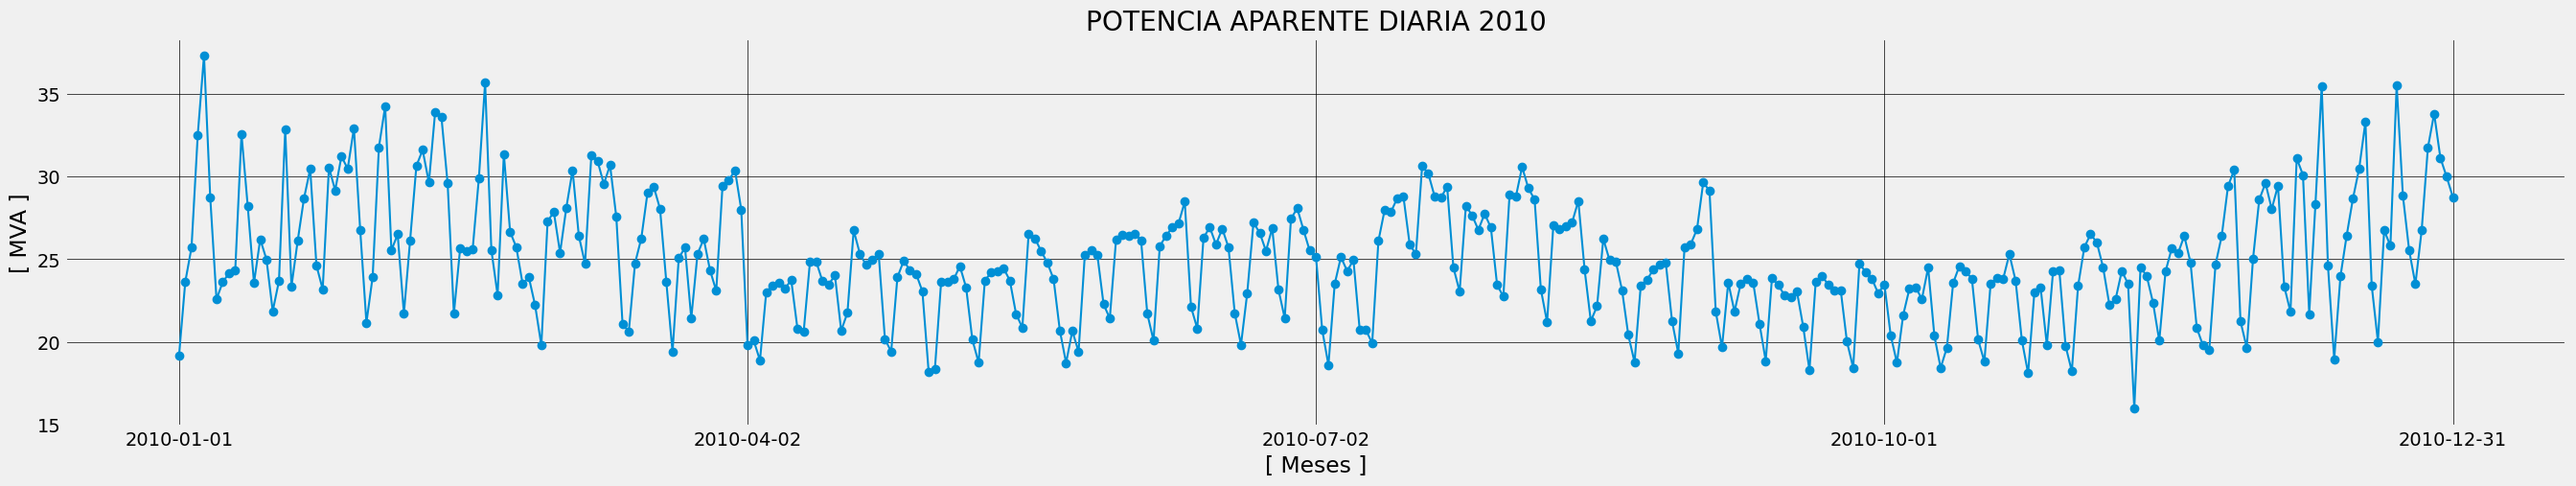

<Figure size 432x288 with 0 Axes>

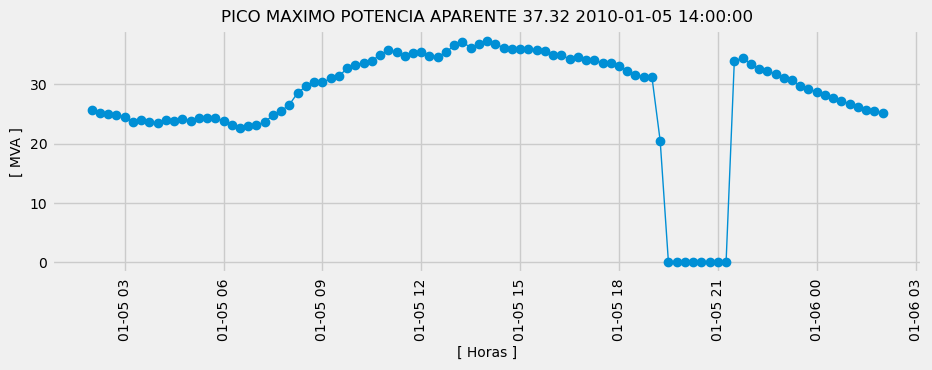

<Figure size 432x288 with 0 Axes>

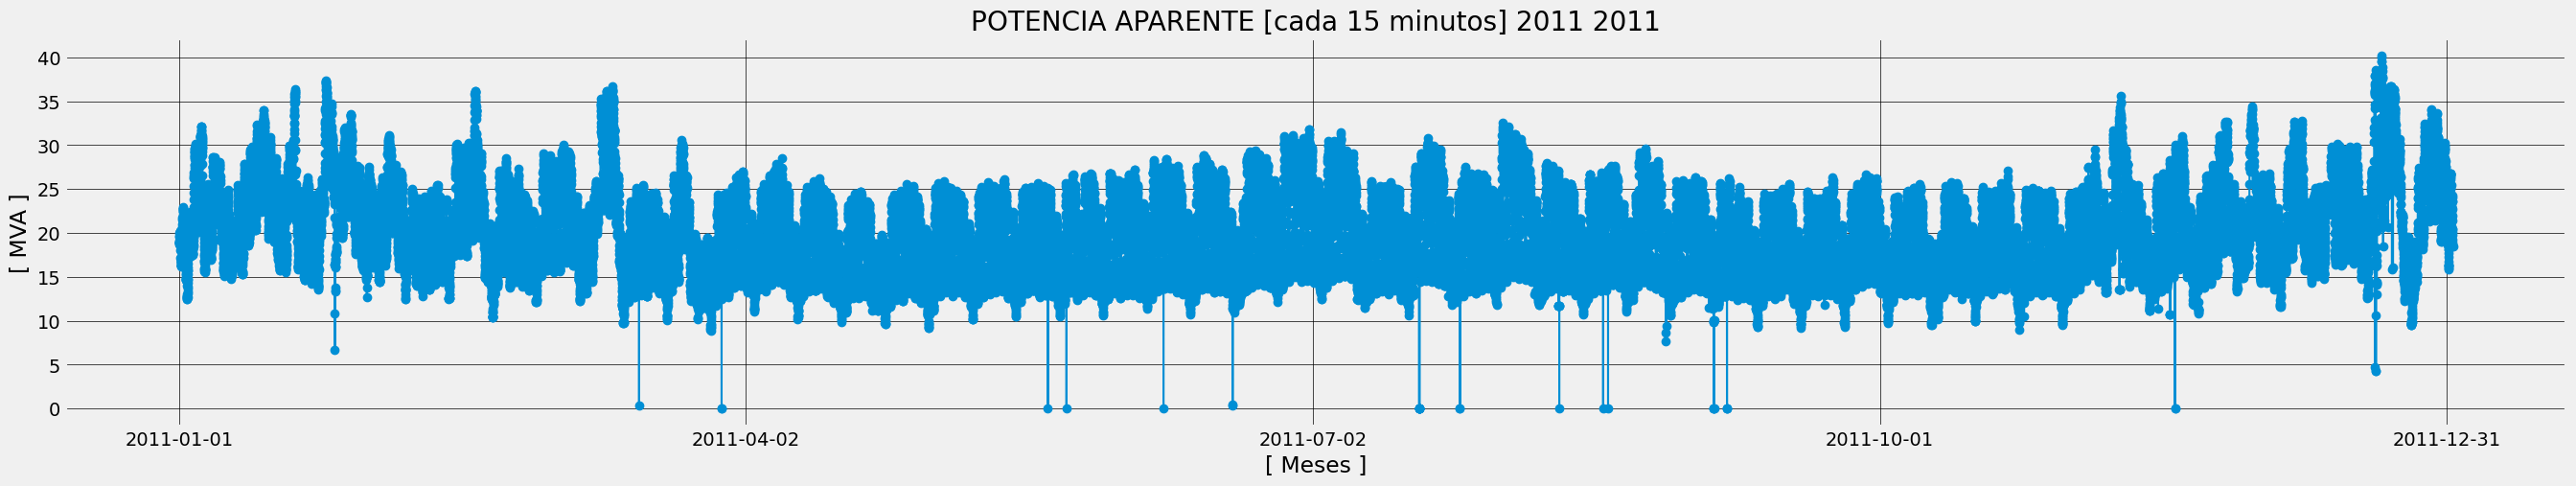

<Figure size 432x288 with 0 Axes>

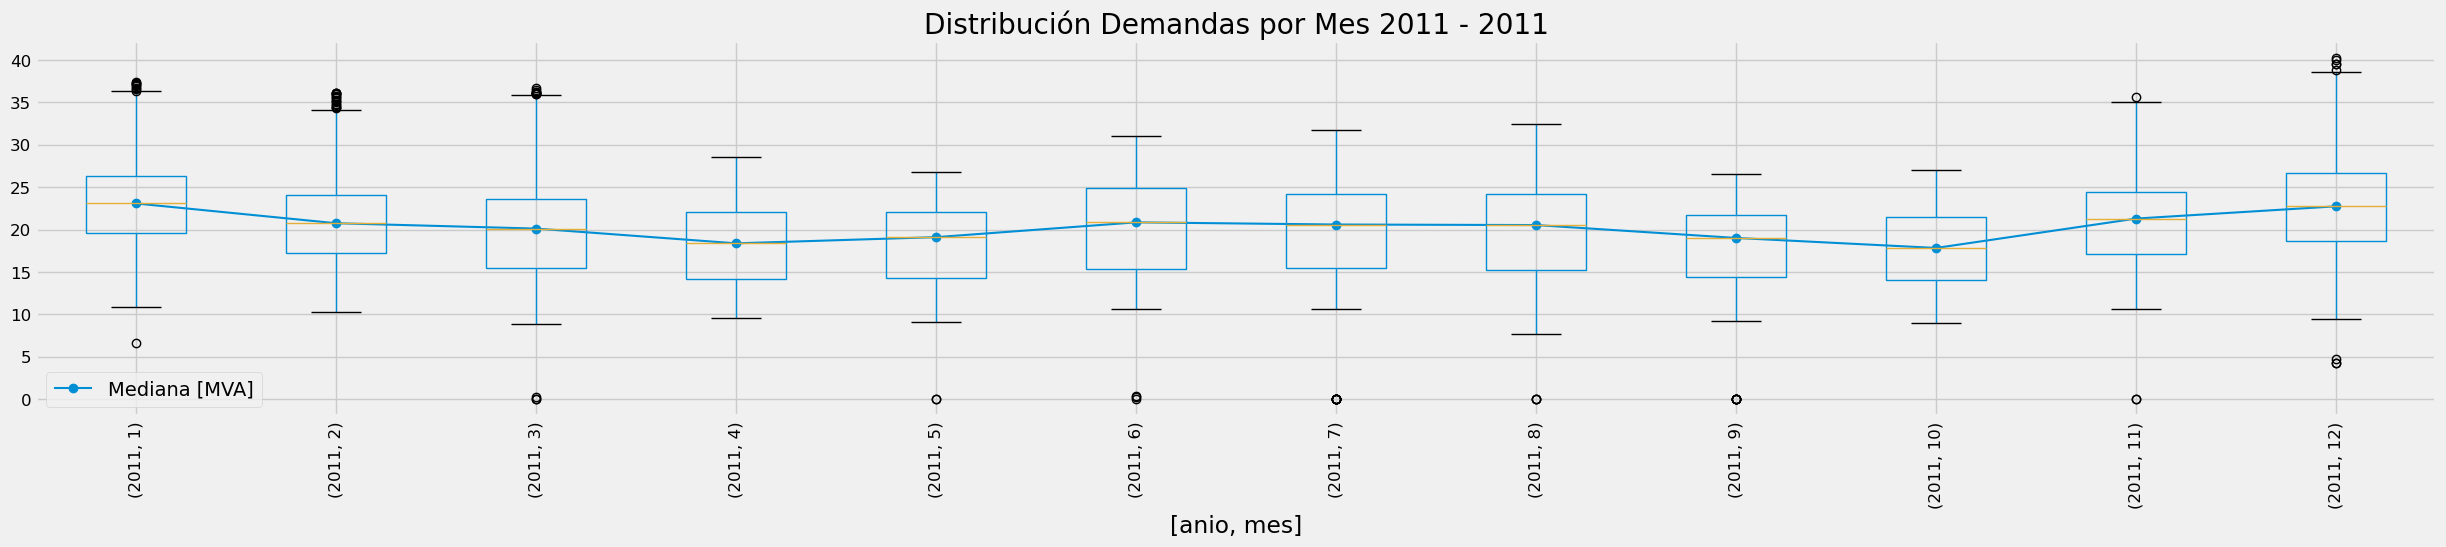

<Figure size 432x288 with 0 Axes>

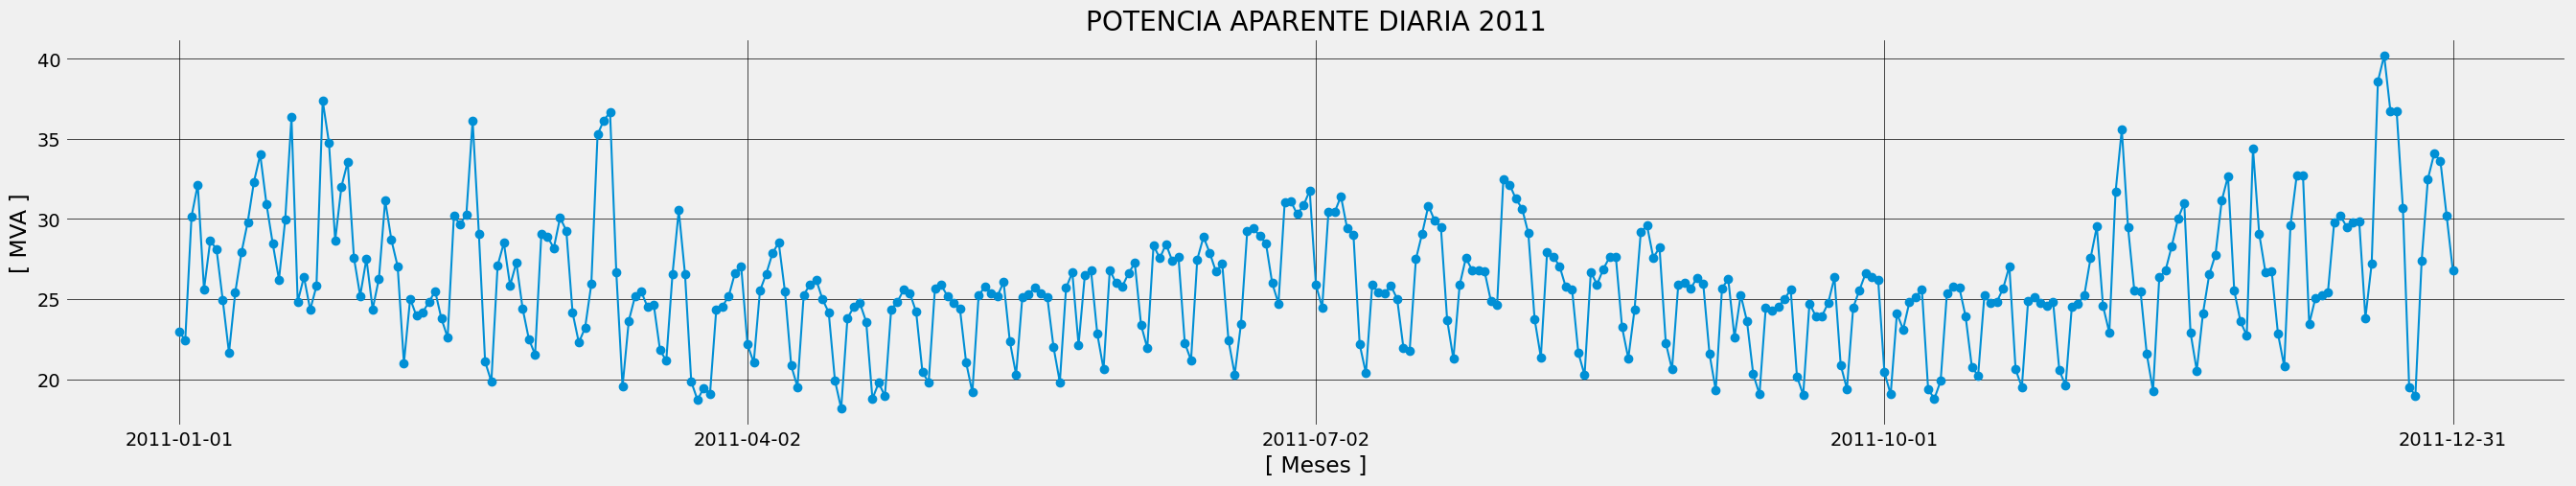

<Figure size 432x288 with 0 Axes>

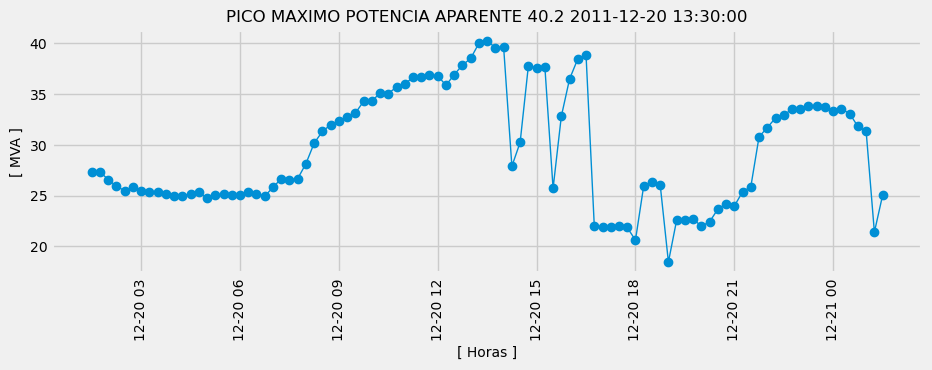

<Figure size 432x288 with 0 Axes>

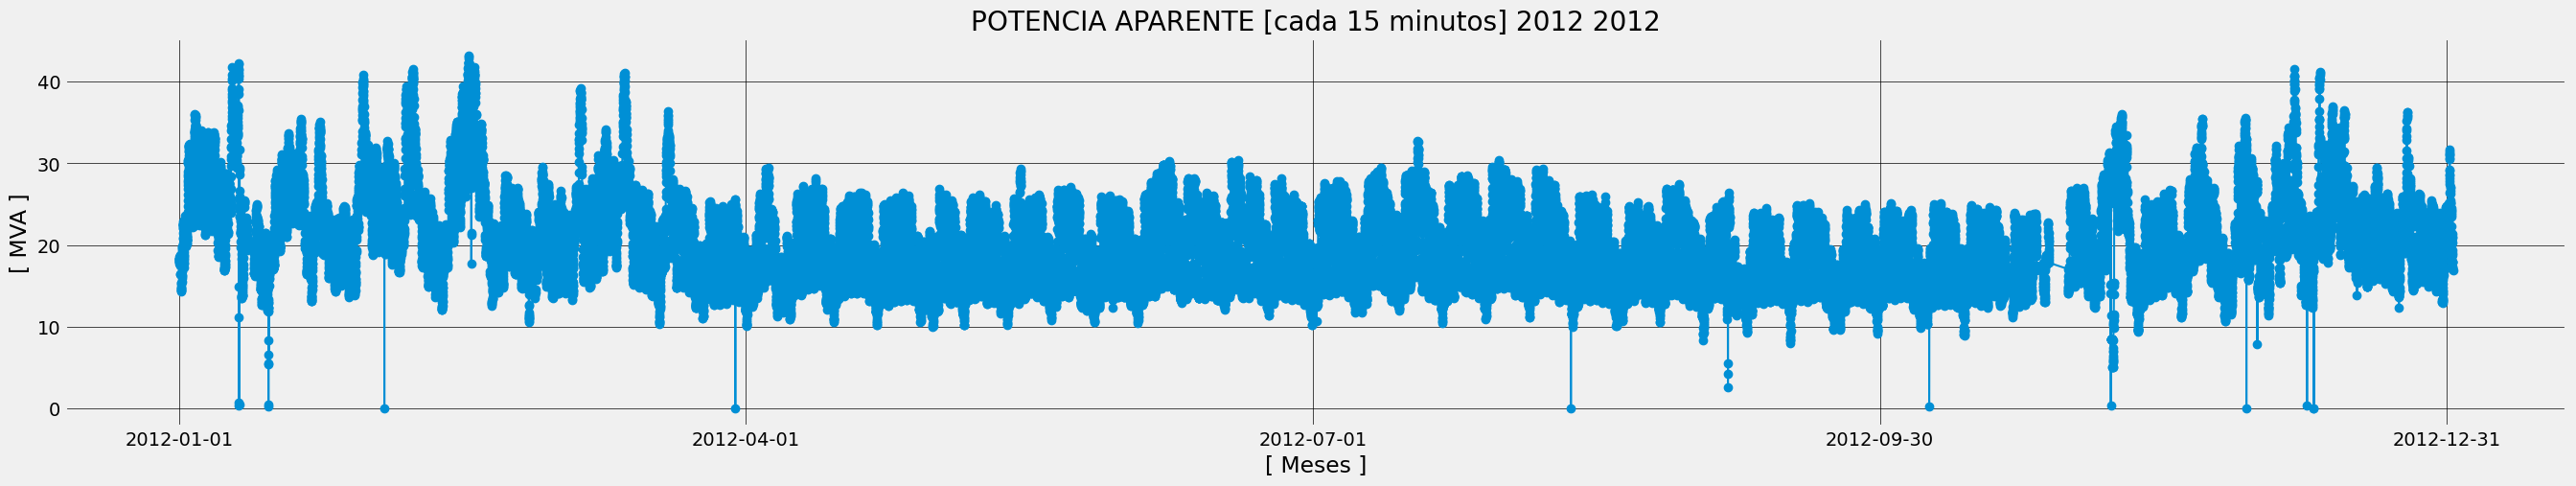

<Figure size 432x288 with 0 Axes>

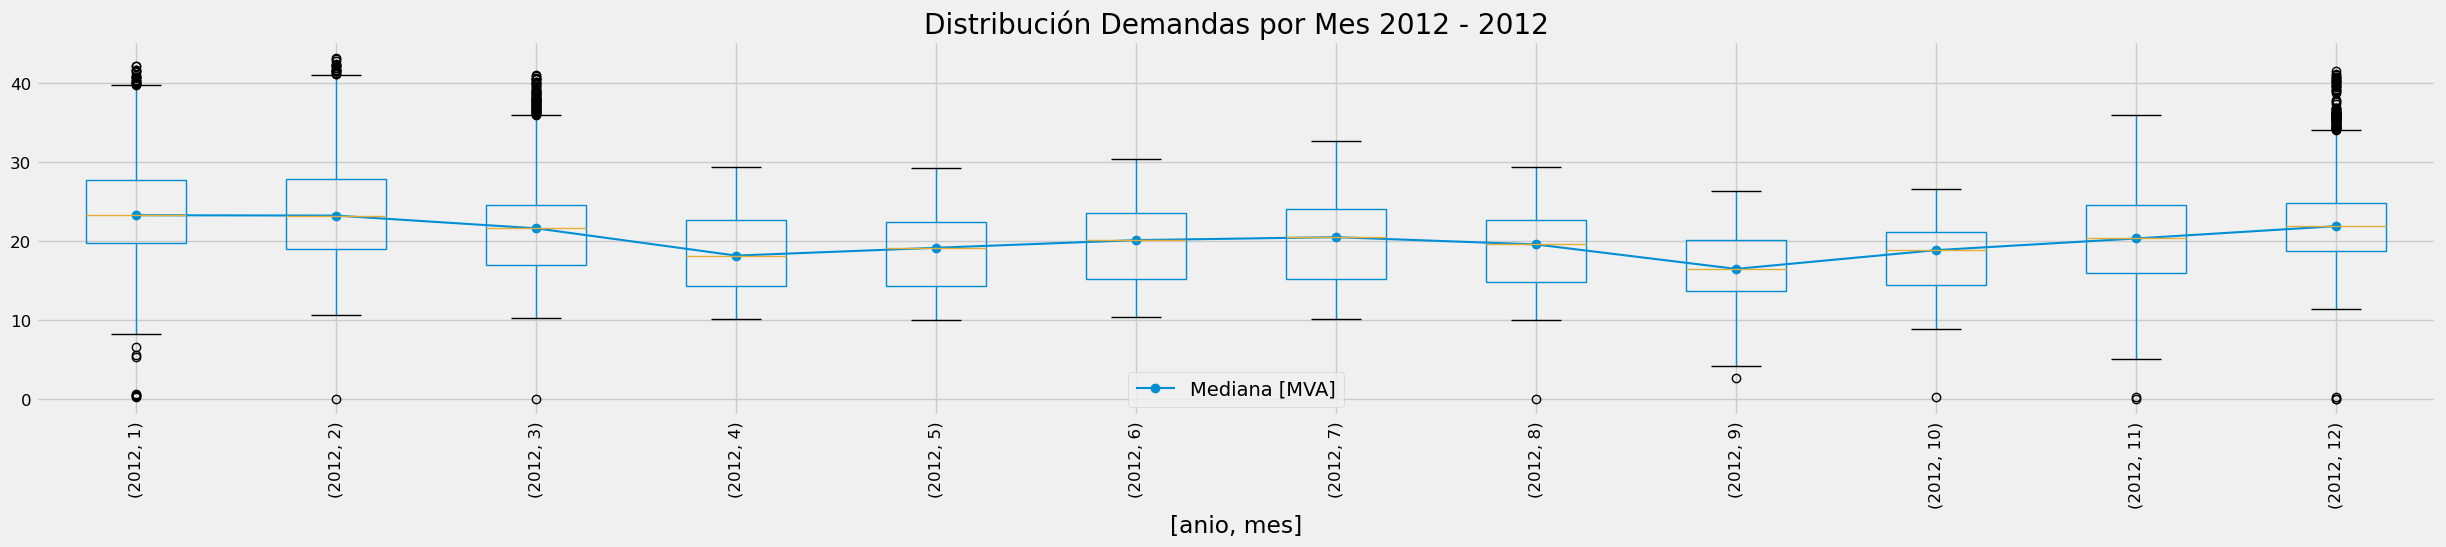

<Figure size 432x288 with 0 Axes>

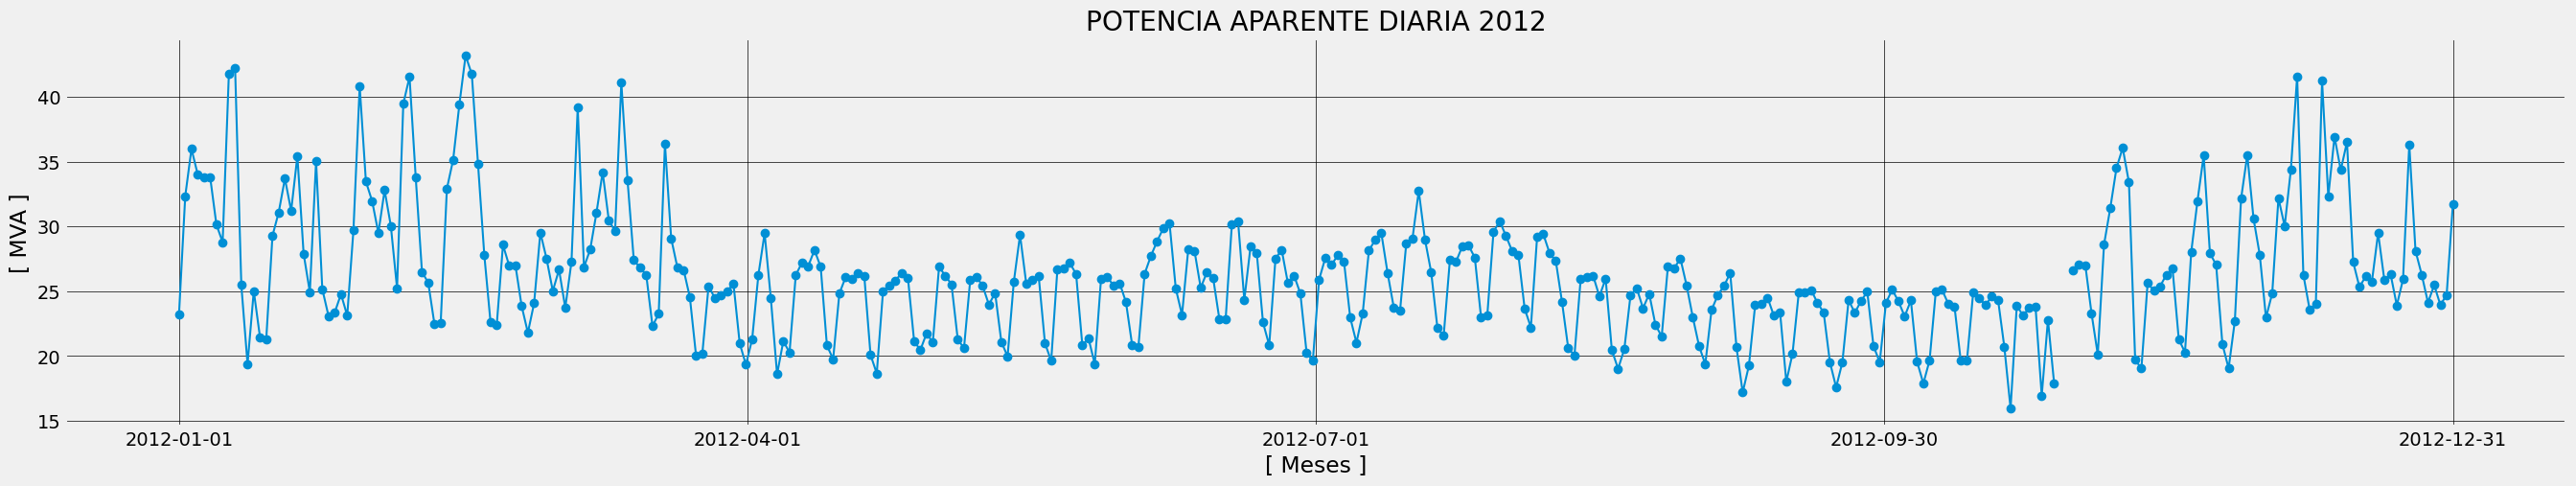

<Figure size 432x288 with 0 Axes>

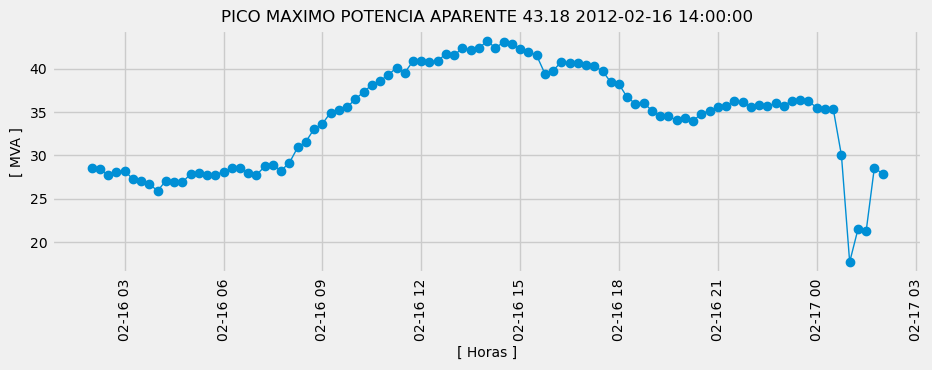

<Figure size 432x288 with 0 Axes>

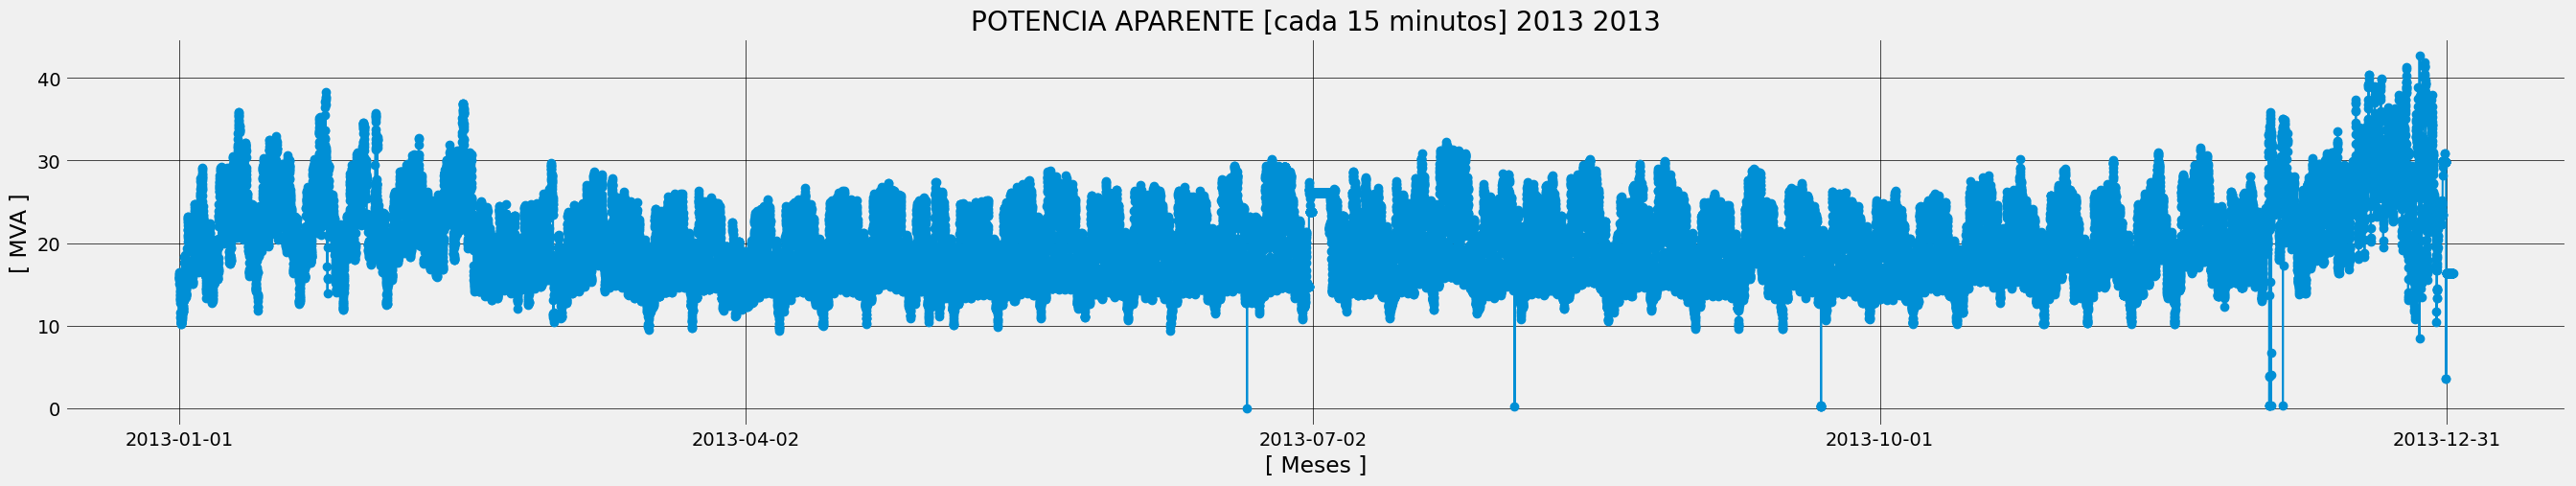

<Figure size 432x288 with 0 Axes>

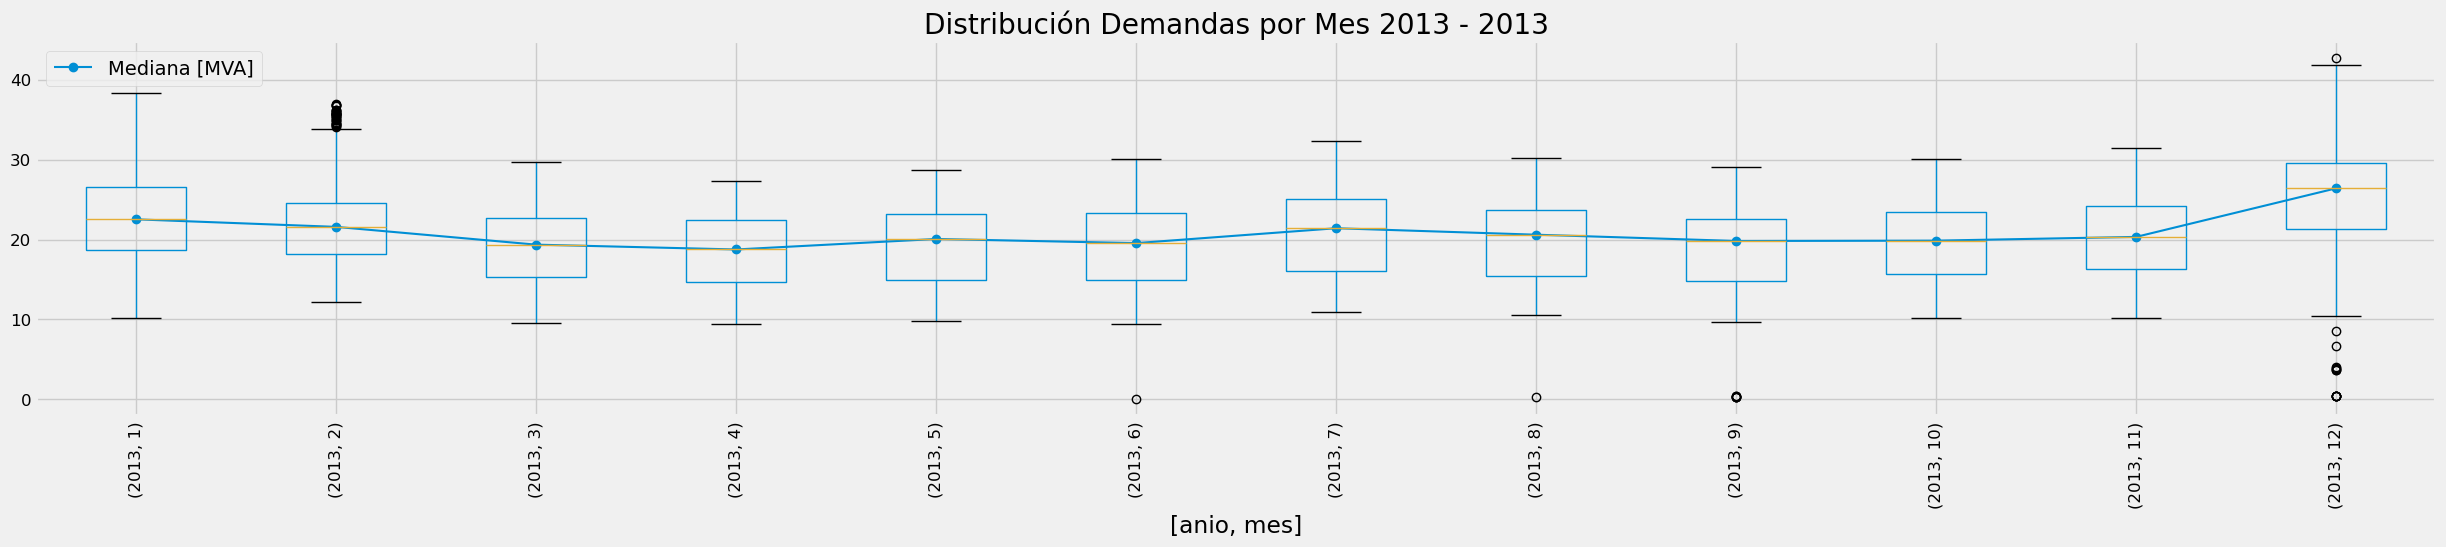

<Figure size 432x288 with 0 Axes>

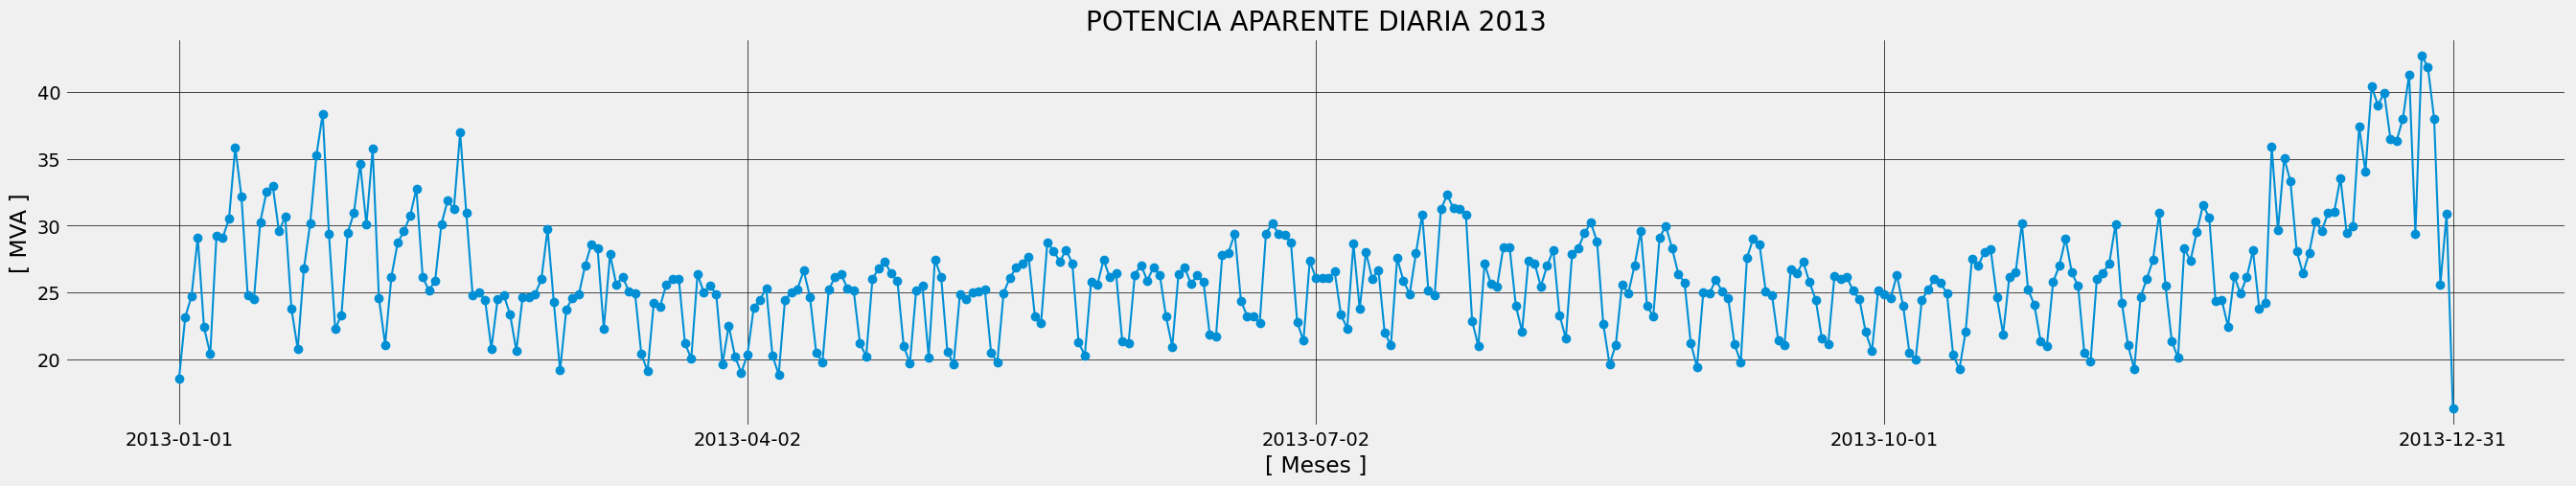

<Figure size 432x288 with 0 Axes>

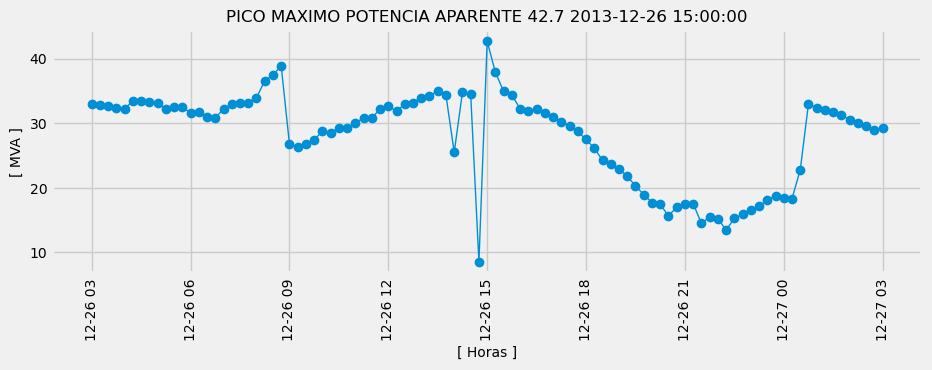

<Figure size 432x288 with 0 Axes>

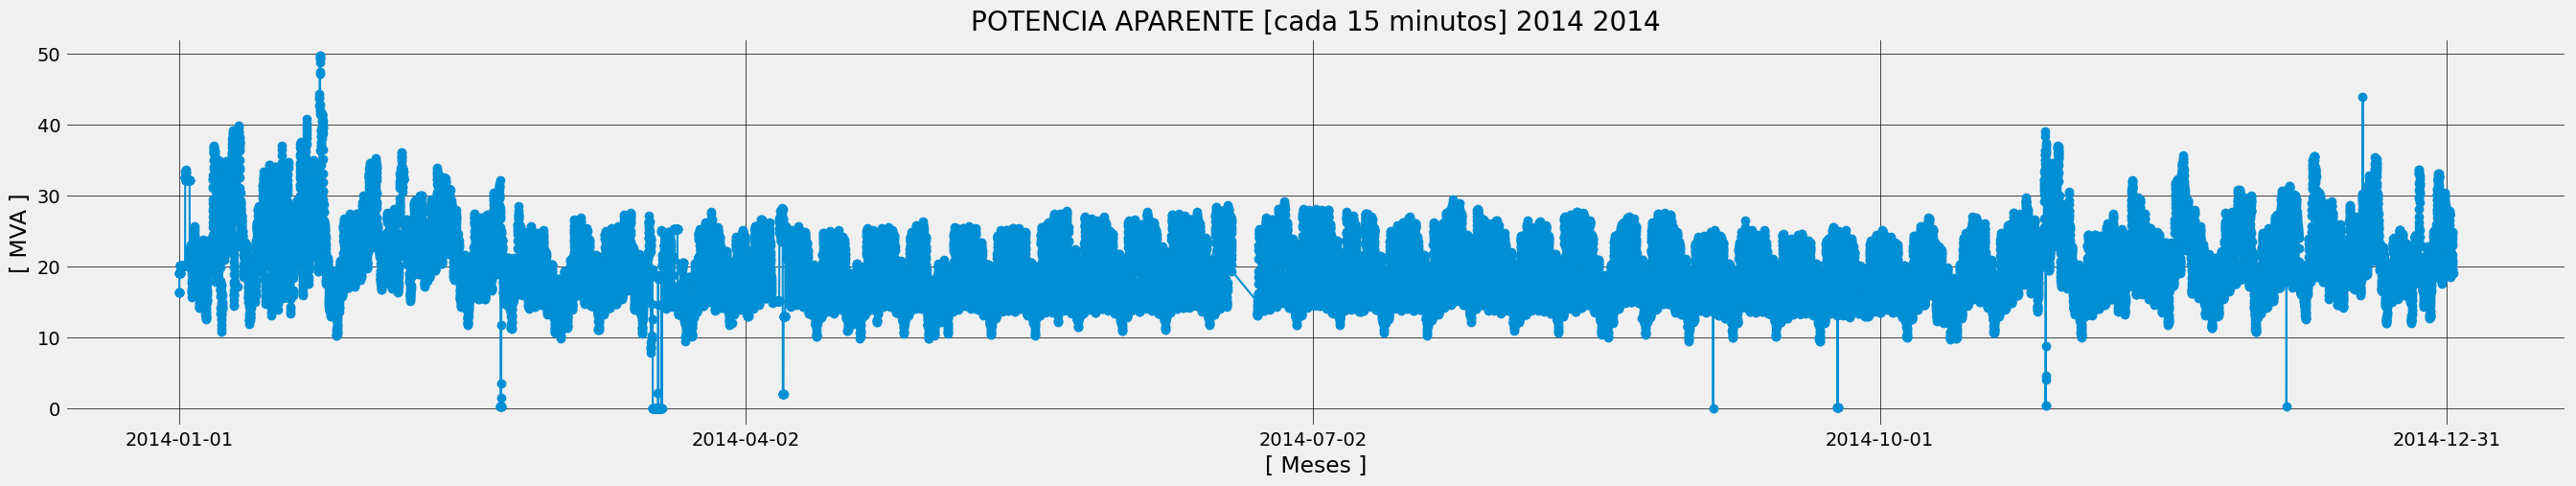

<Figure size 432x288 with 0 Axes>

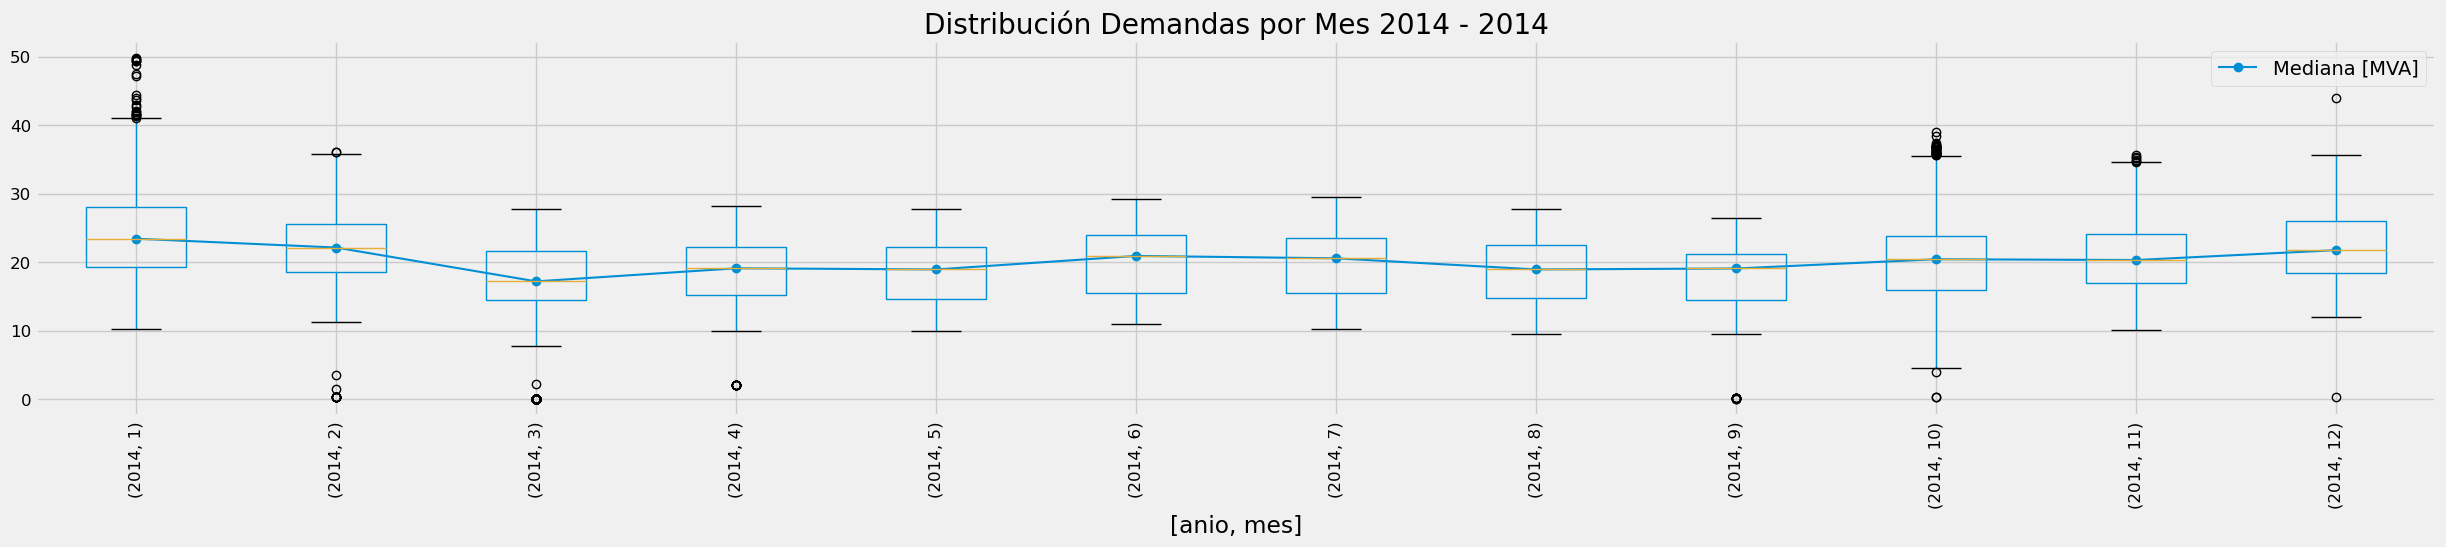

<Figure size 432x288 with 0 Axes>

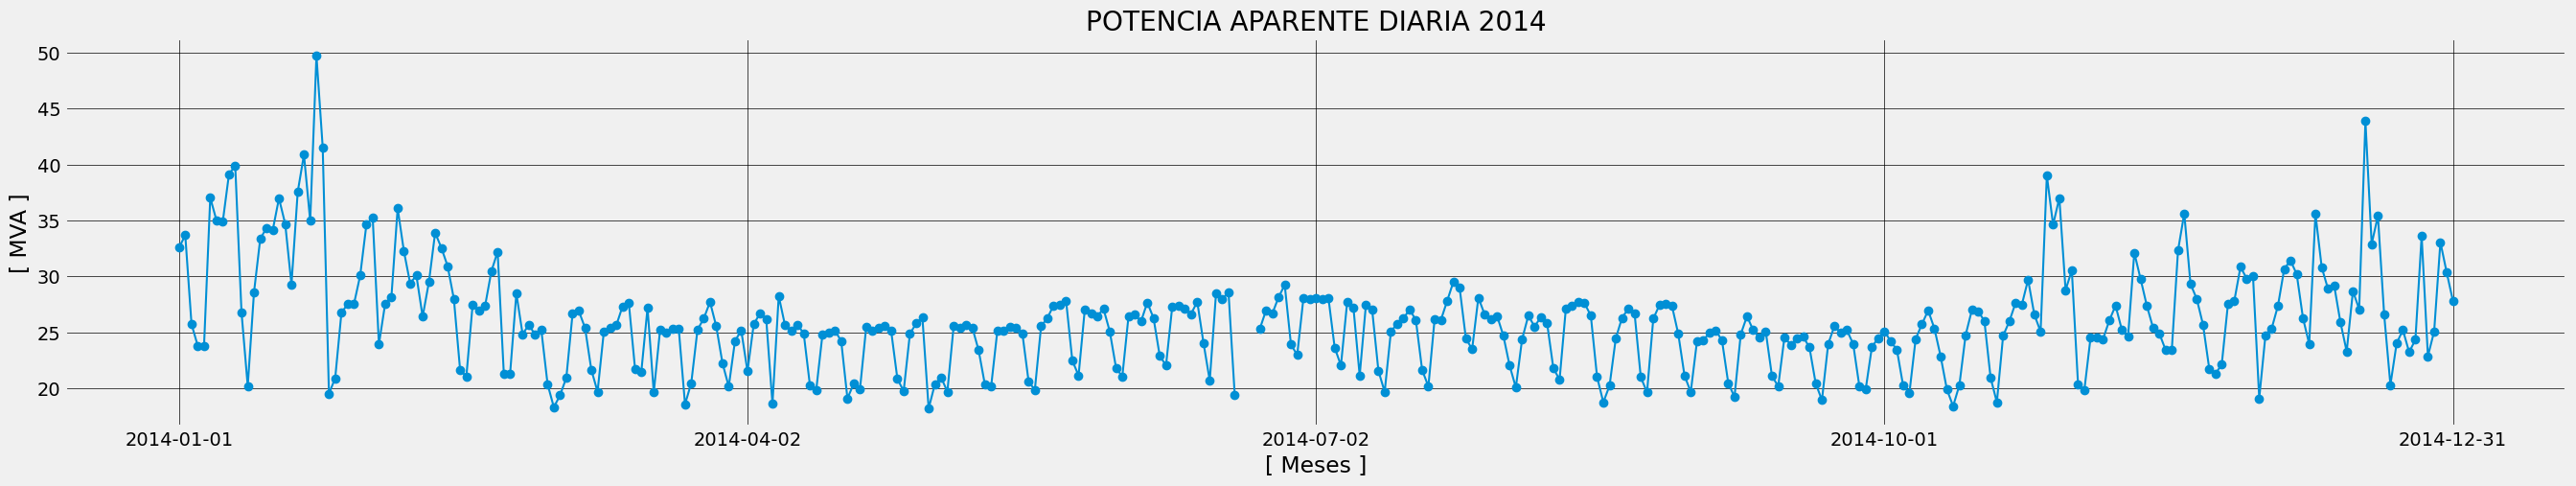

<Figure size 432x288 with 0 Axes>

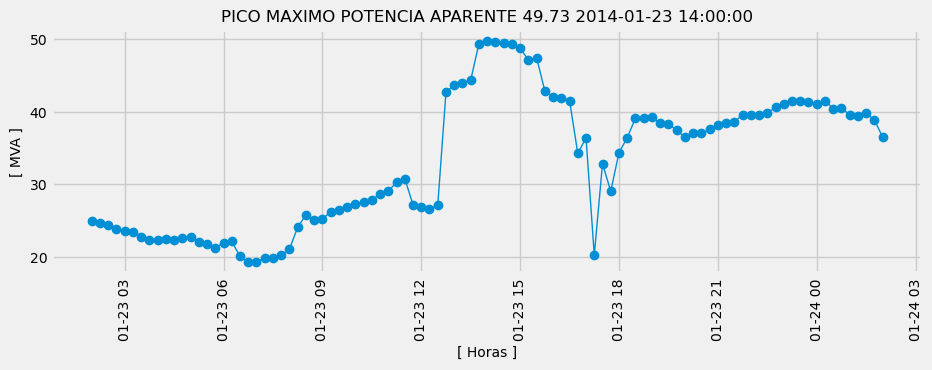

<Figure size 432x288 with 0 Axes>

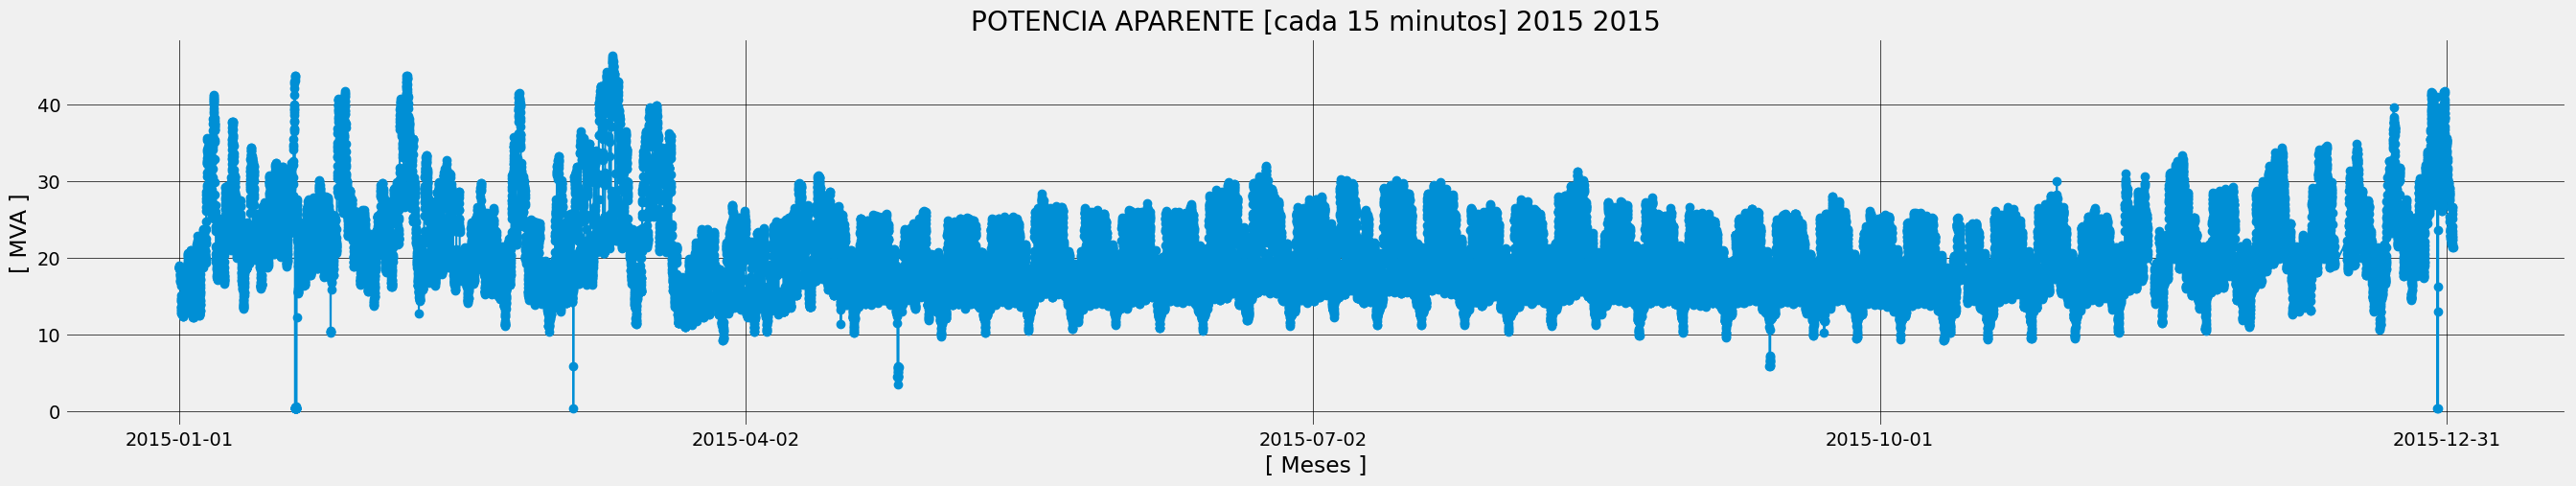

<Figure size 432x288 with 0 Axes>

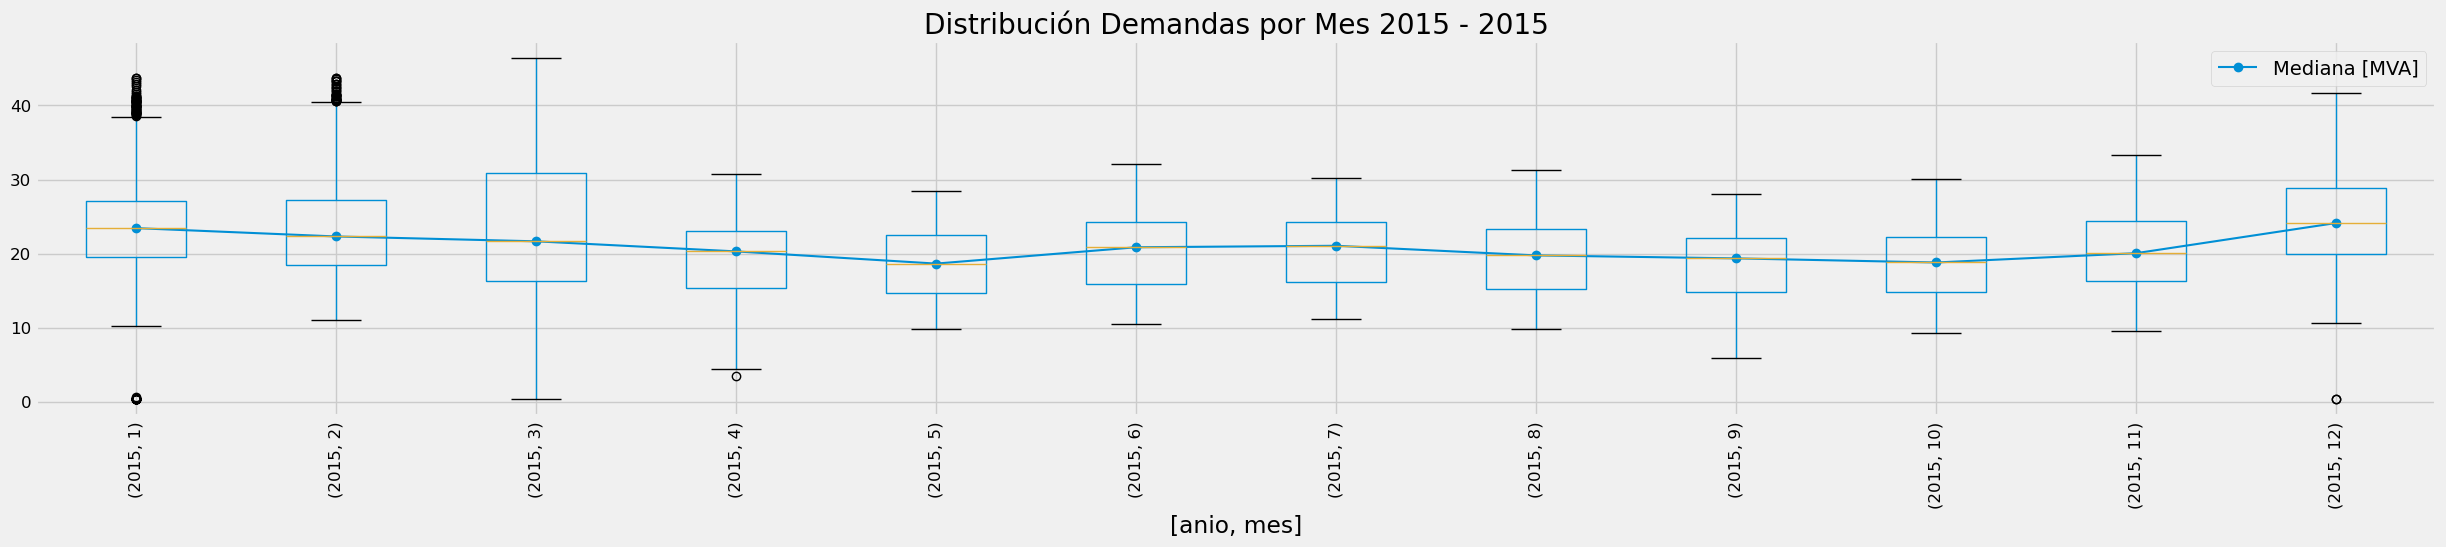

<Figure size 432x288 with 0 Axes>

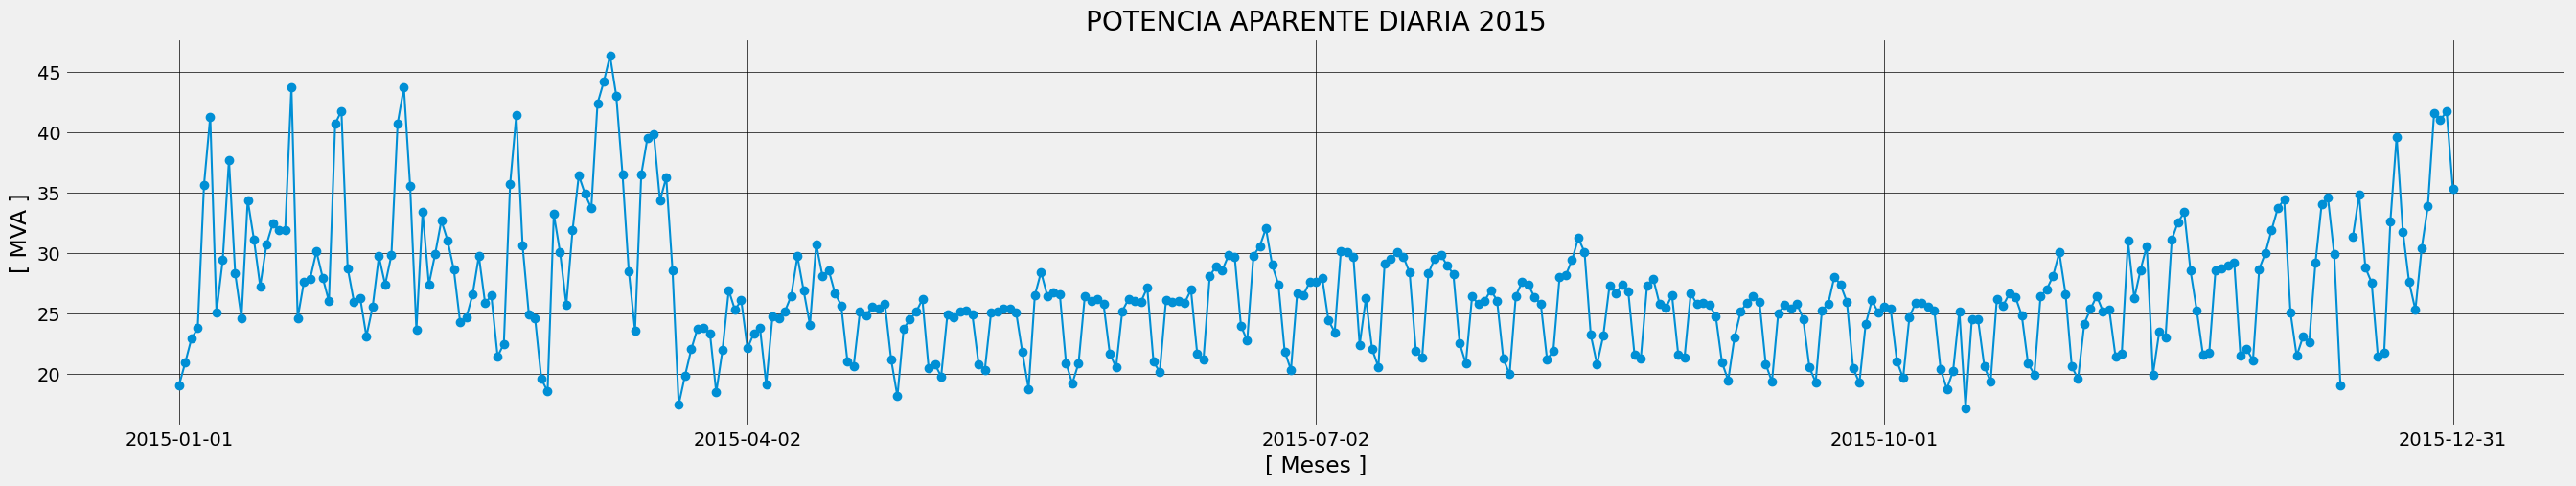

<Figure size 432x288 with 0 Axes>

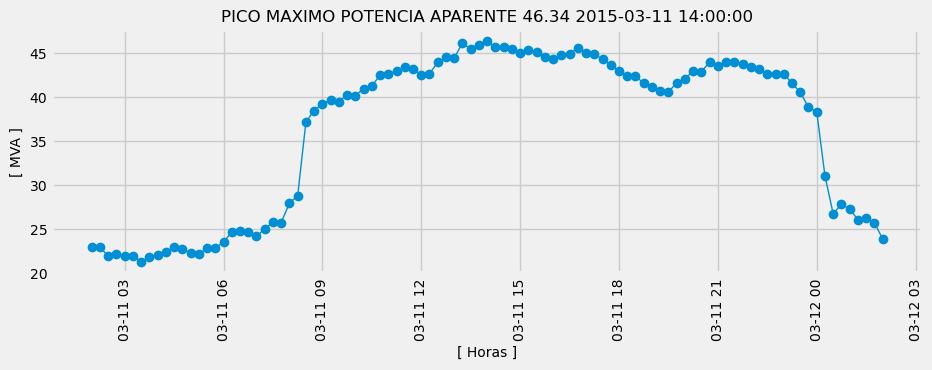

<Figure size 432x288 with 0 Axes>

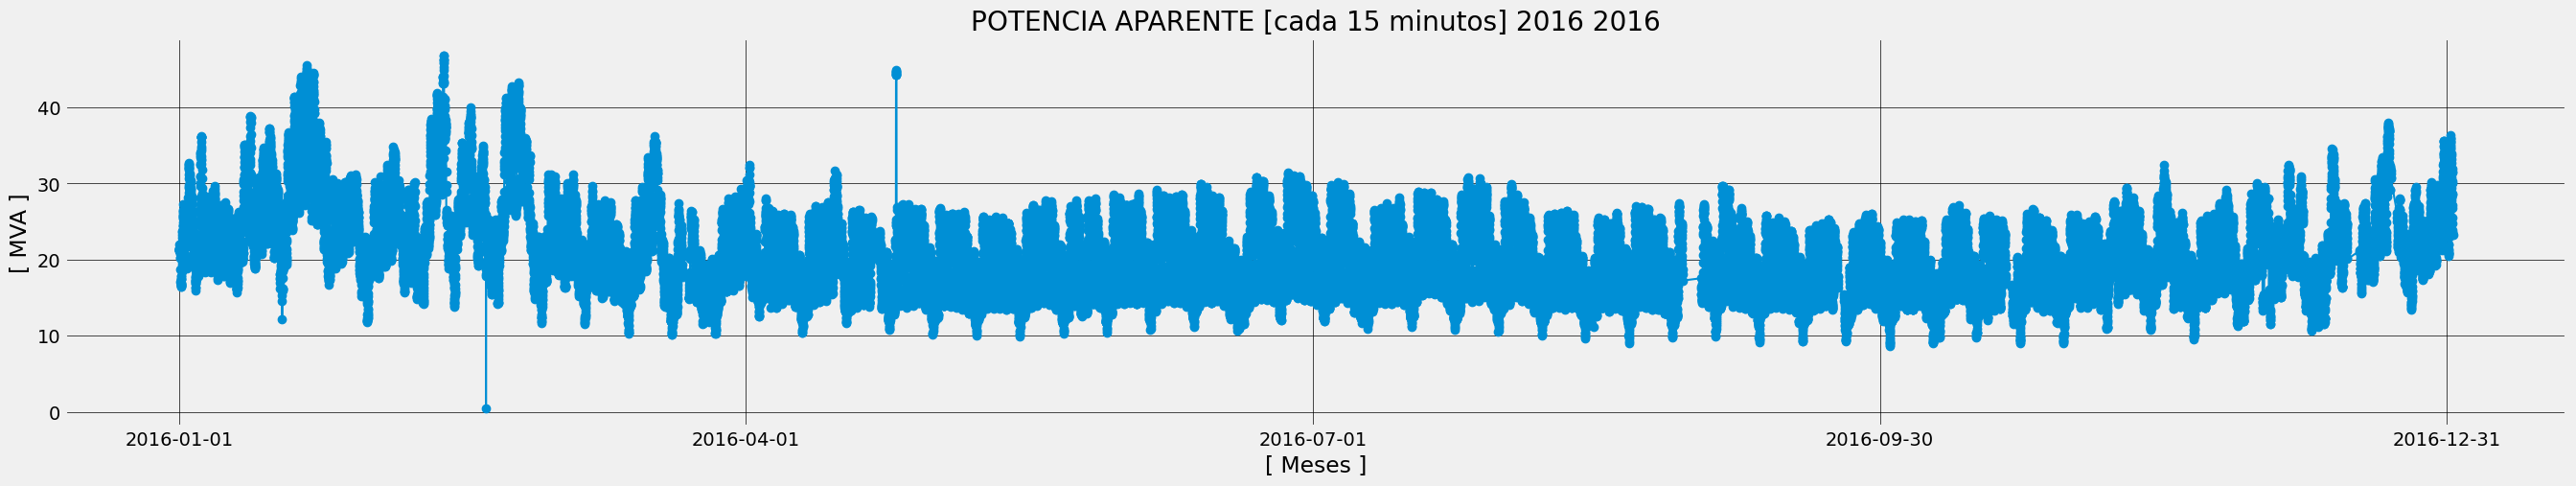

<Figure size 432x288 with 0 Axes>

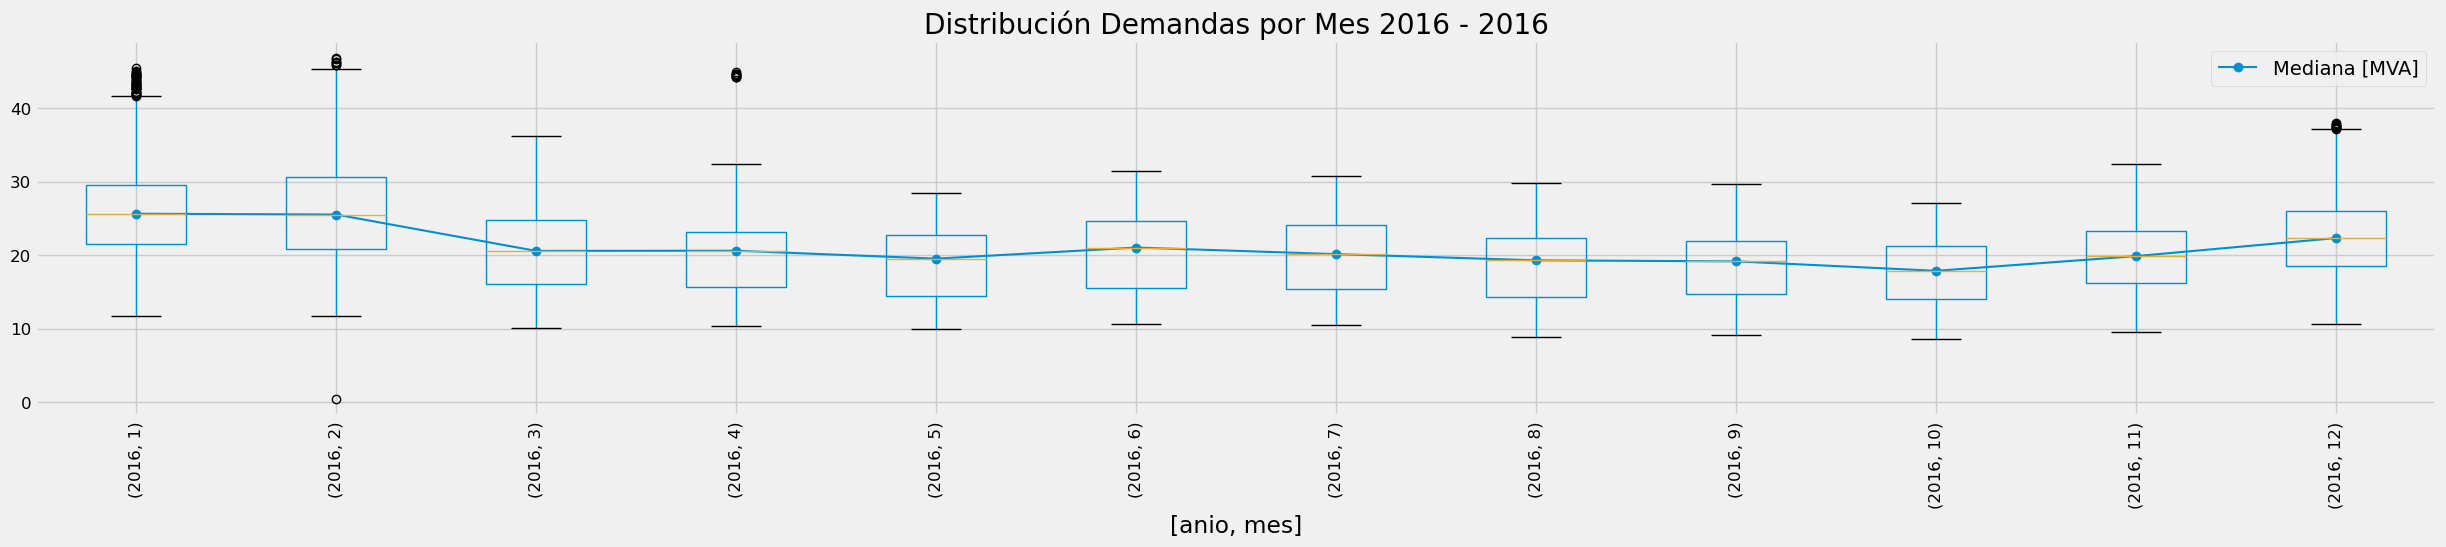

<Figure size 432x288 with 0 Axes>

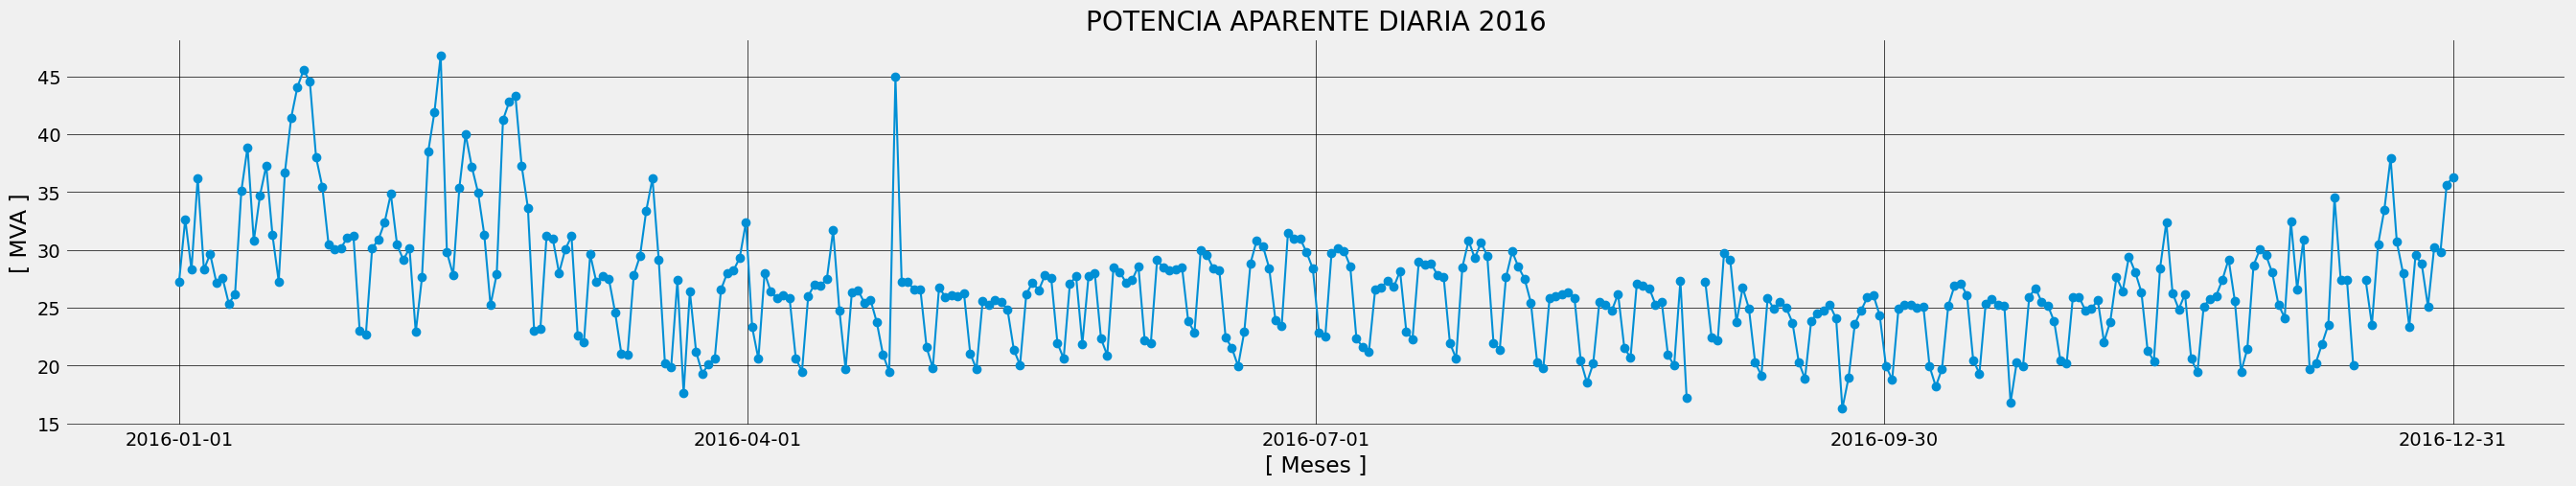

<Figure size 432x288 with 0 Axes>

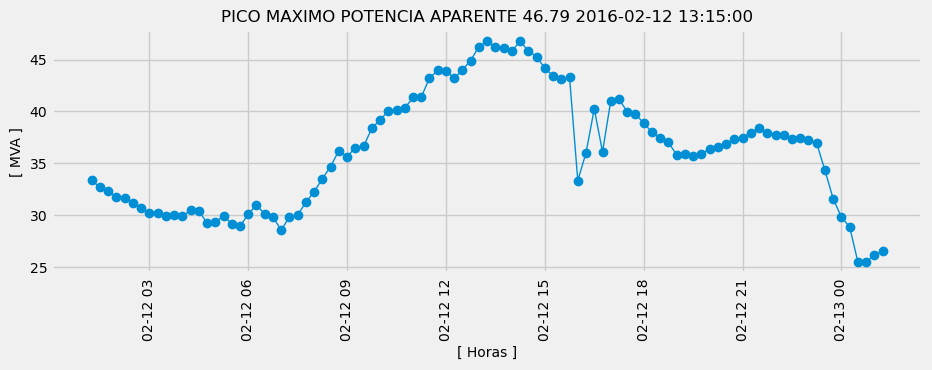

<Figure size 432x288 with 0 Axes>

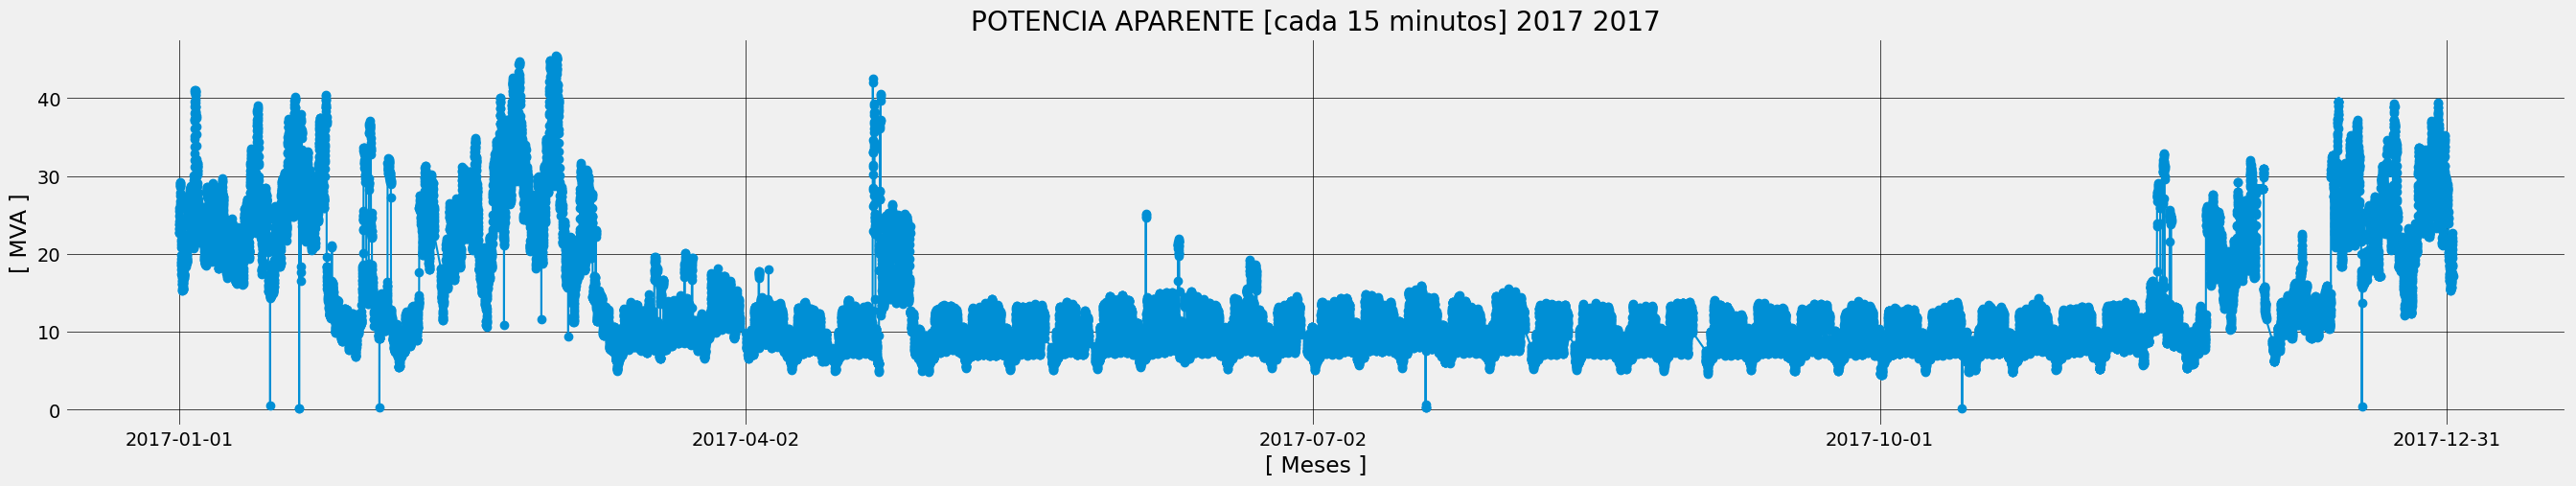

<Figure size 432x288 with 0 Axes>

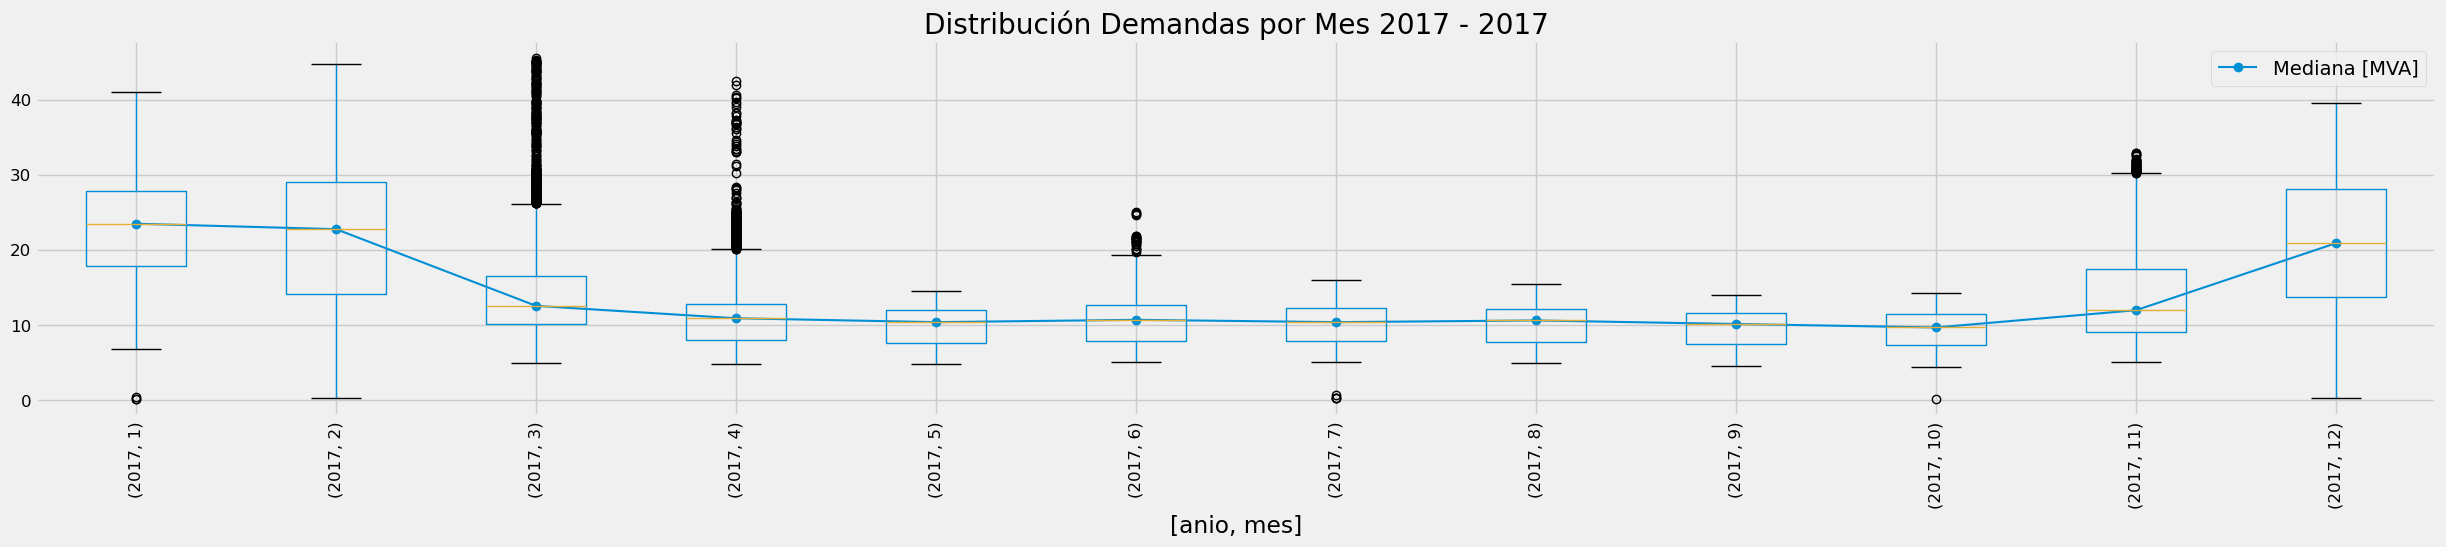

<Figure size 432x288 with 0 Axes>

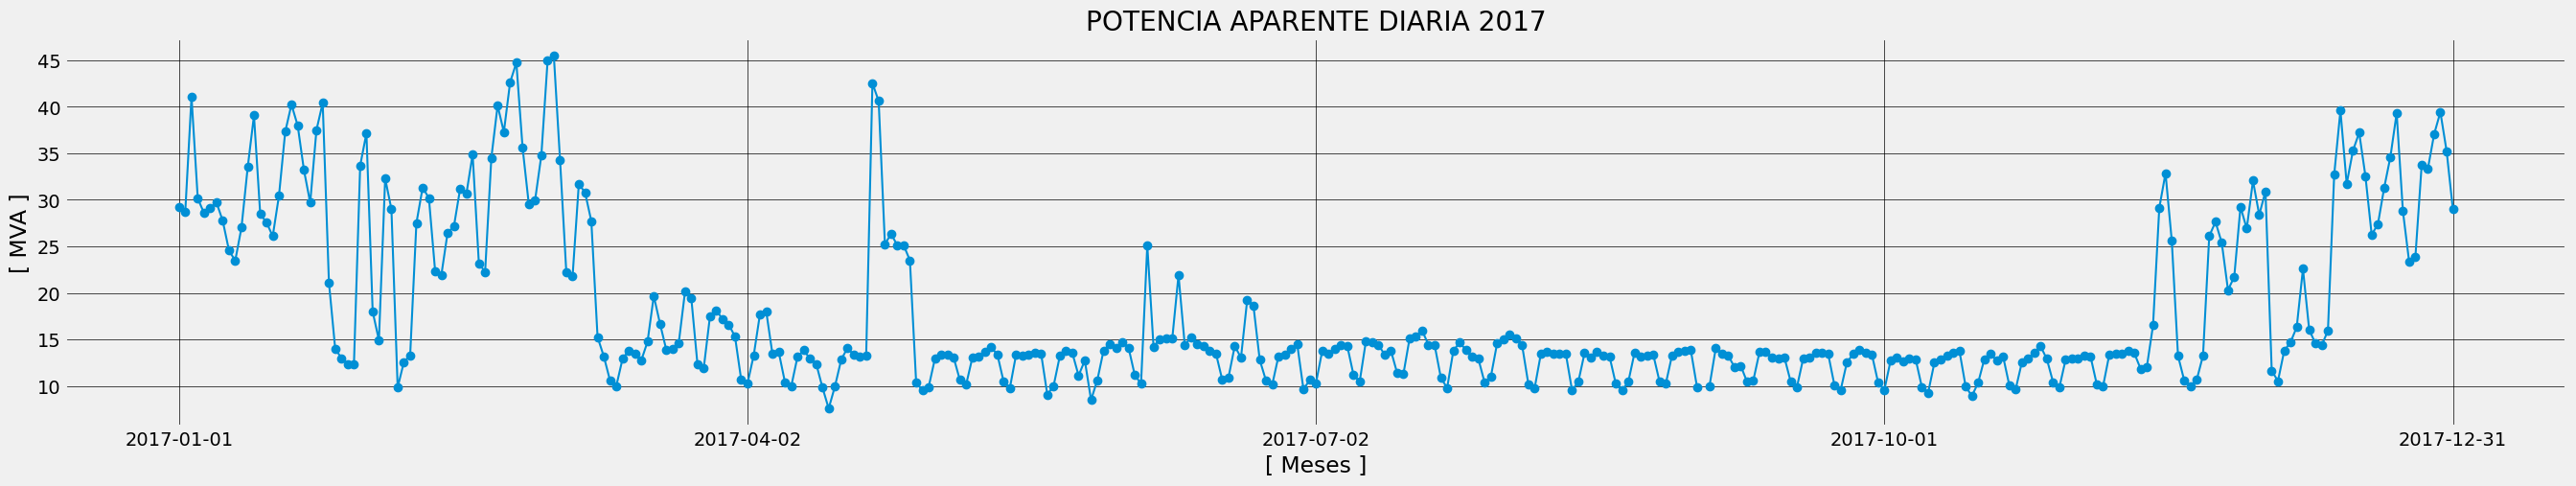

<Figure size 432x288 with 0 Axes>

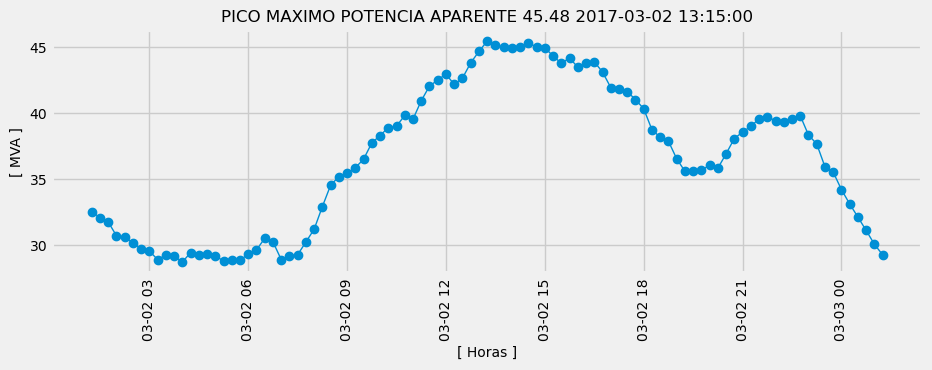

<Figure size 432x288 with 0 Axes>

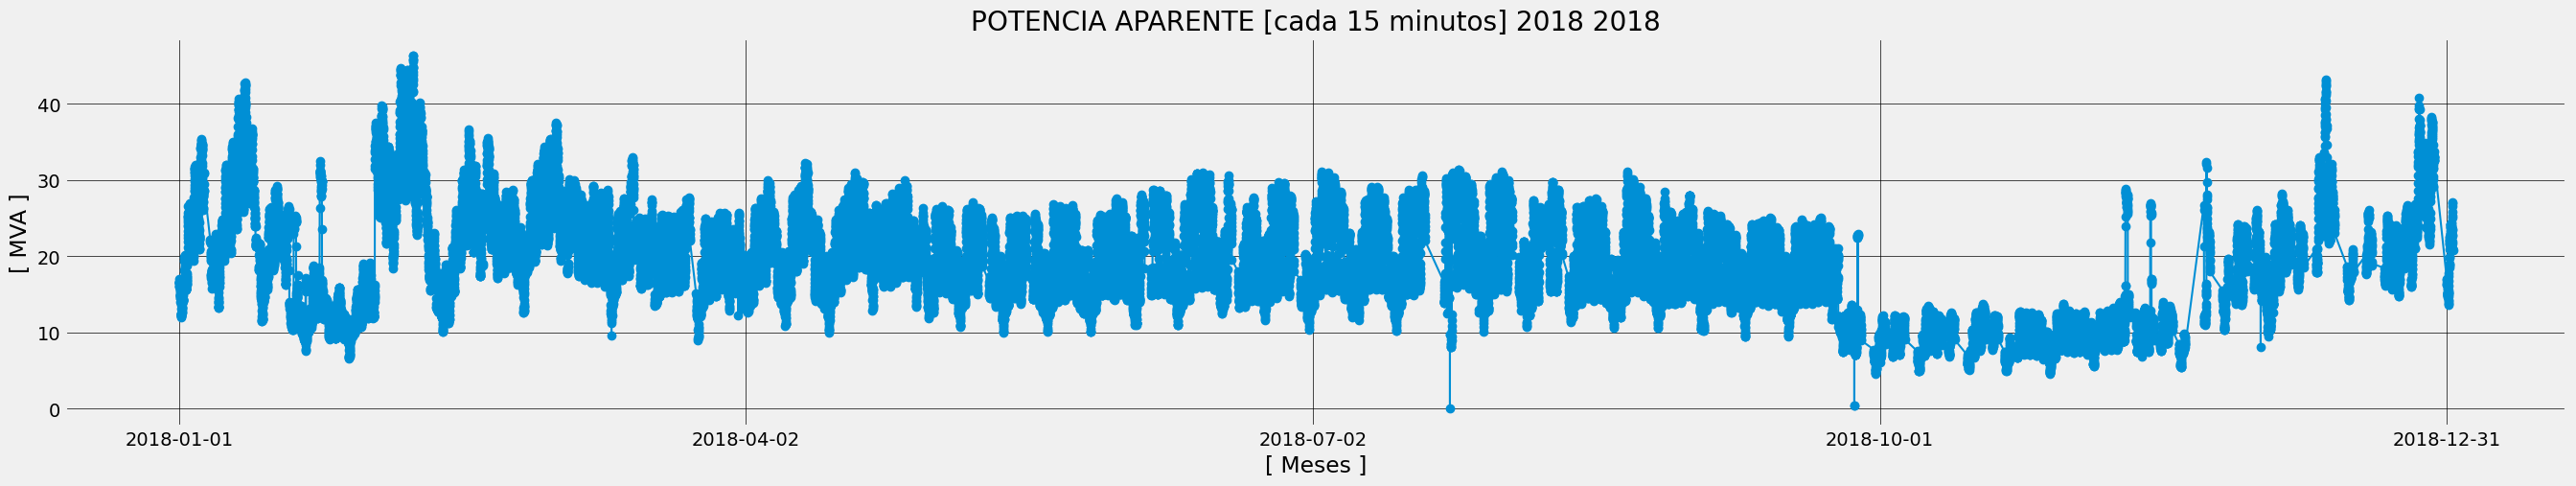

<Figure size 432x288 with 0 Axes>

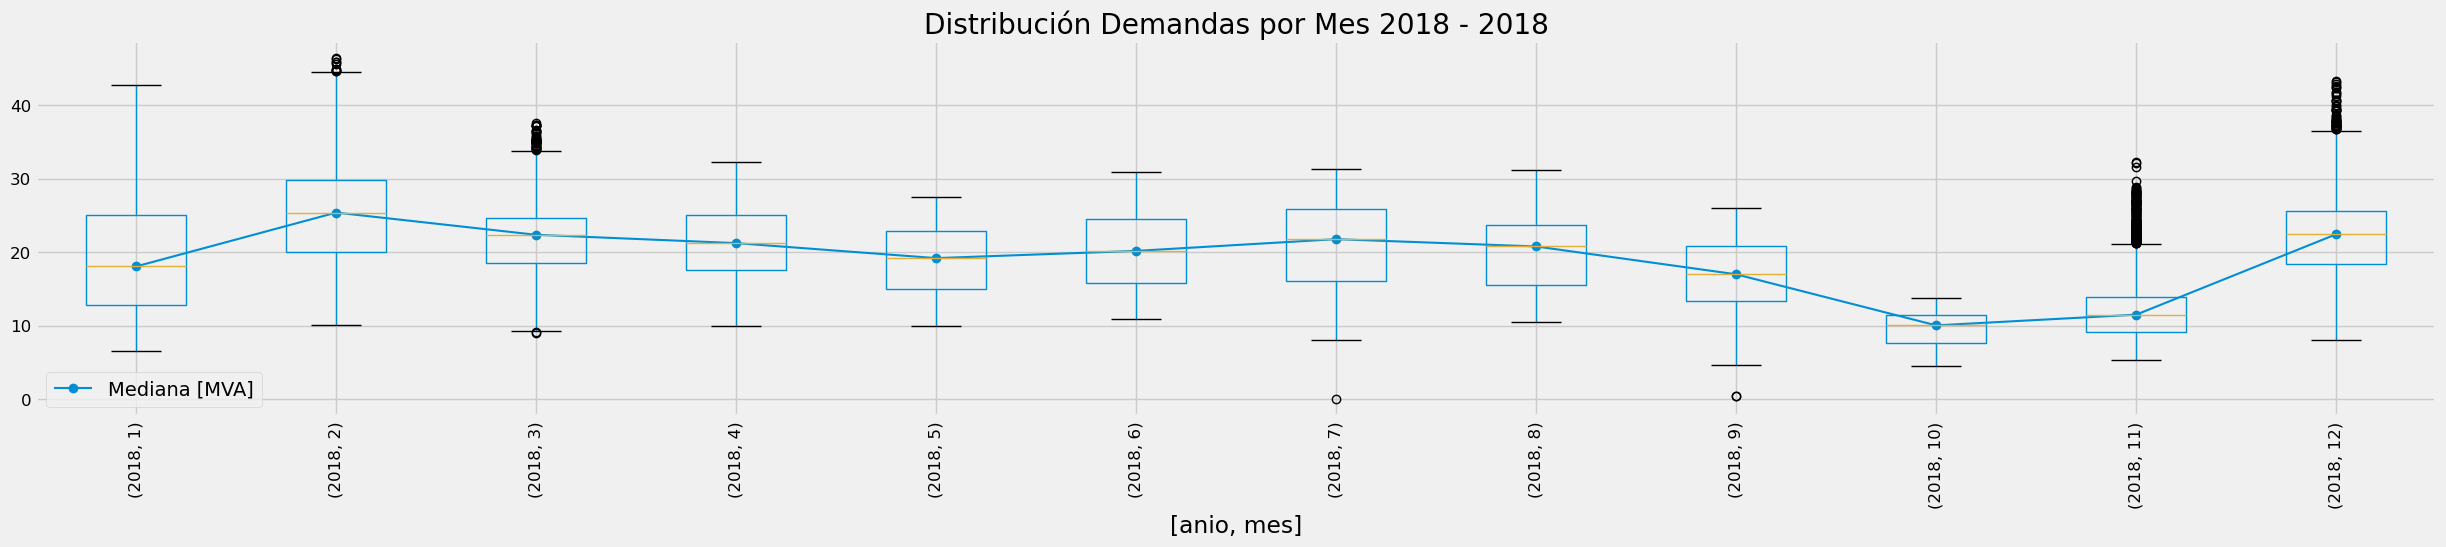

<Figure size 432x288 with 0 Axes>

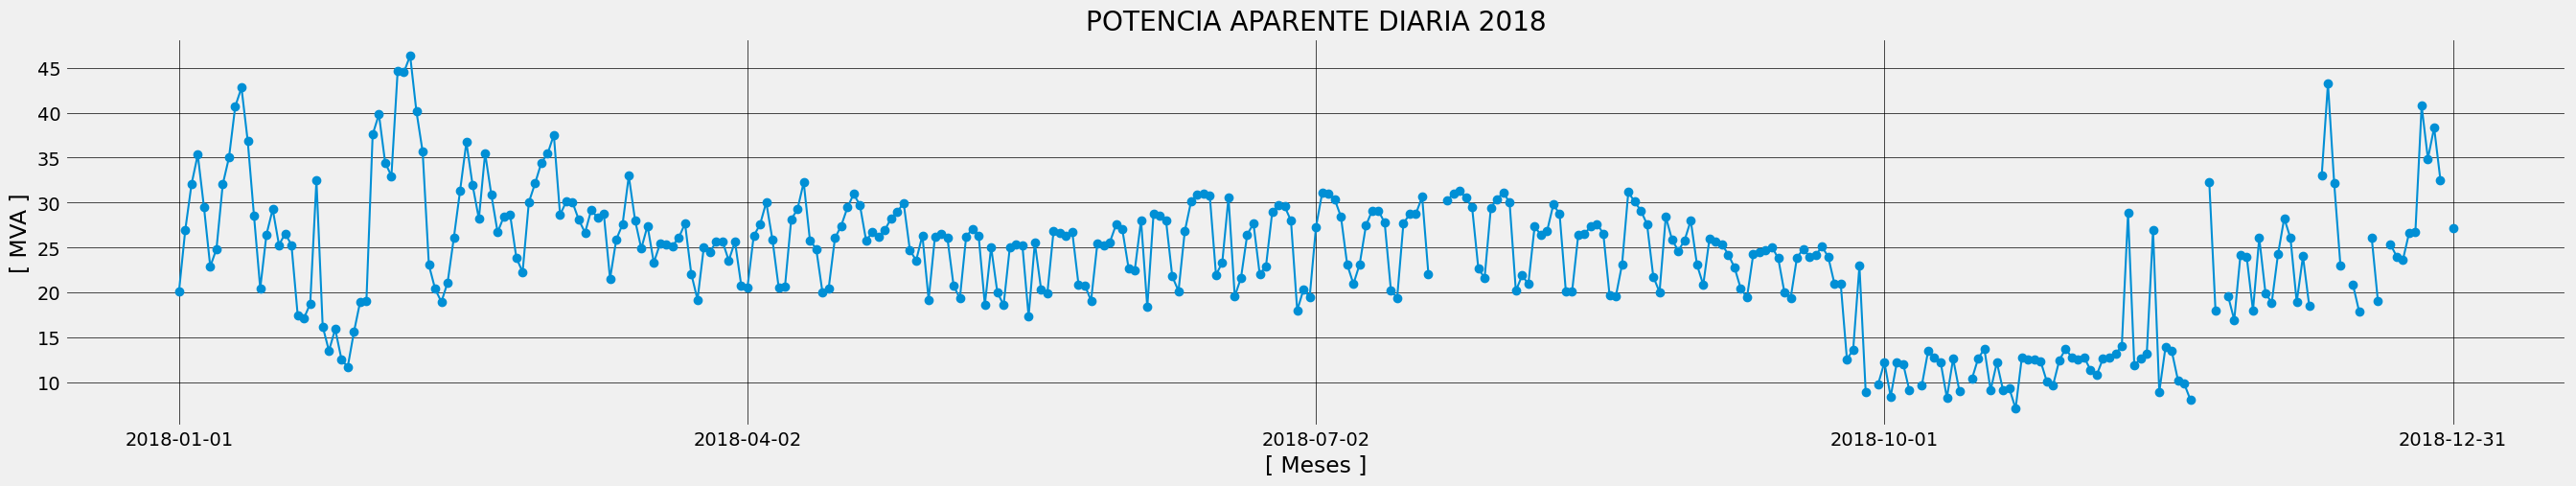

<Figure size 432x288 with 0 Axes>

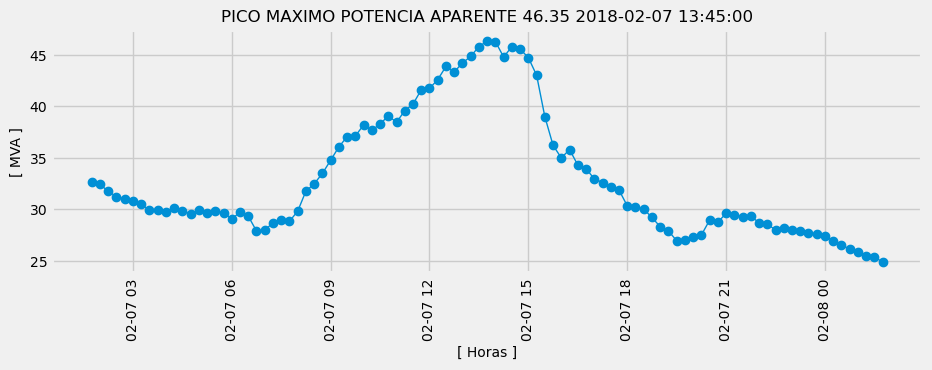

<Figure size 432x288 with 0 Axes>

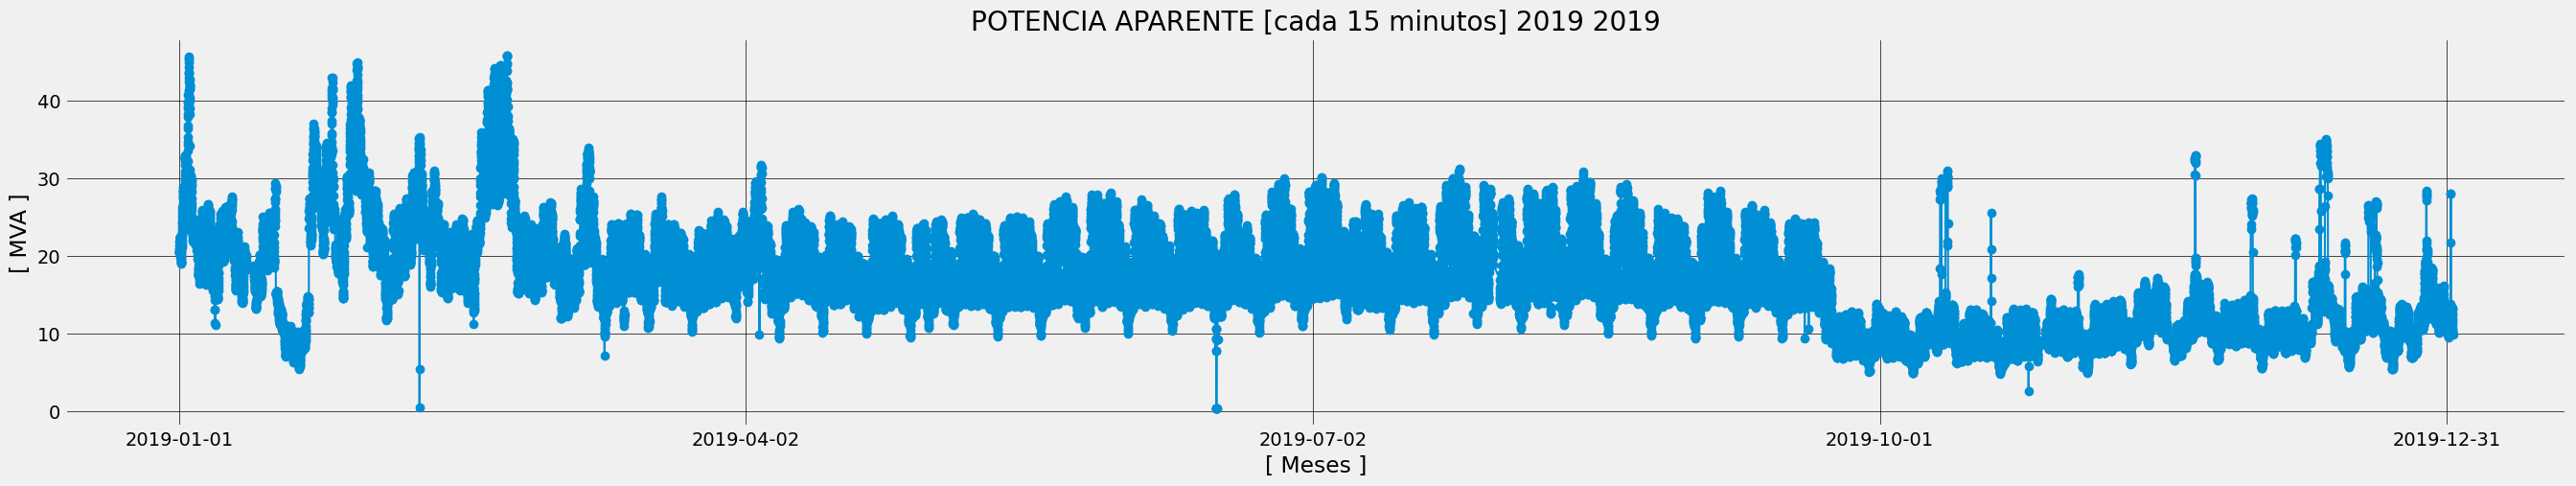

<Figure size 432x288 with 0 Axes>

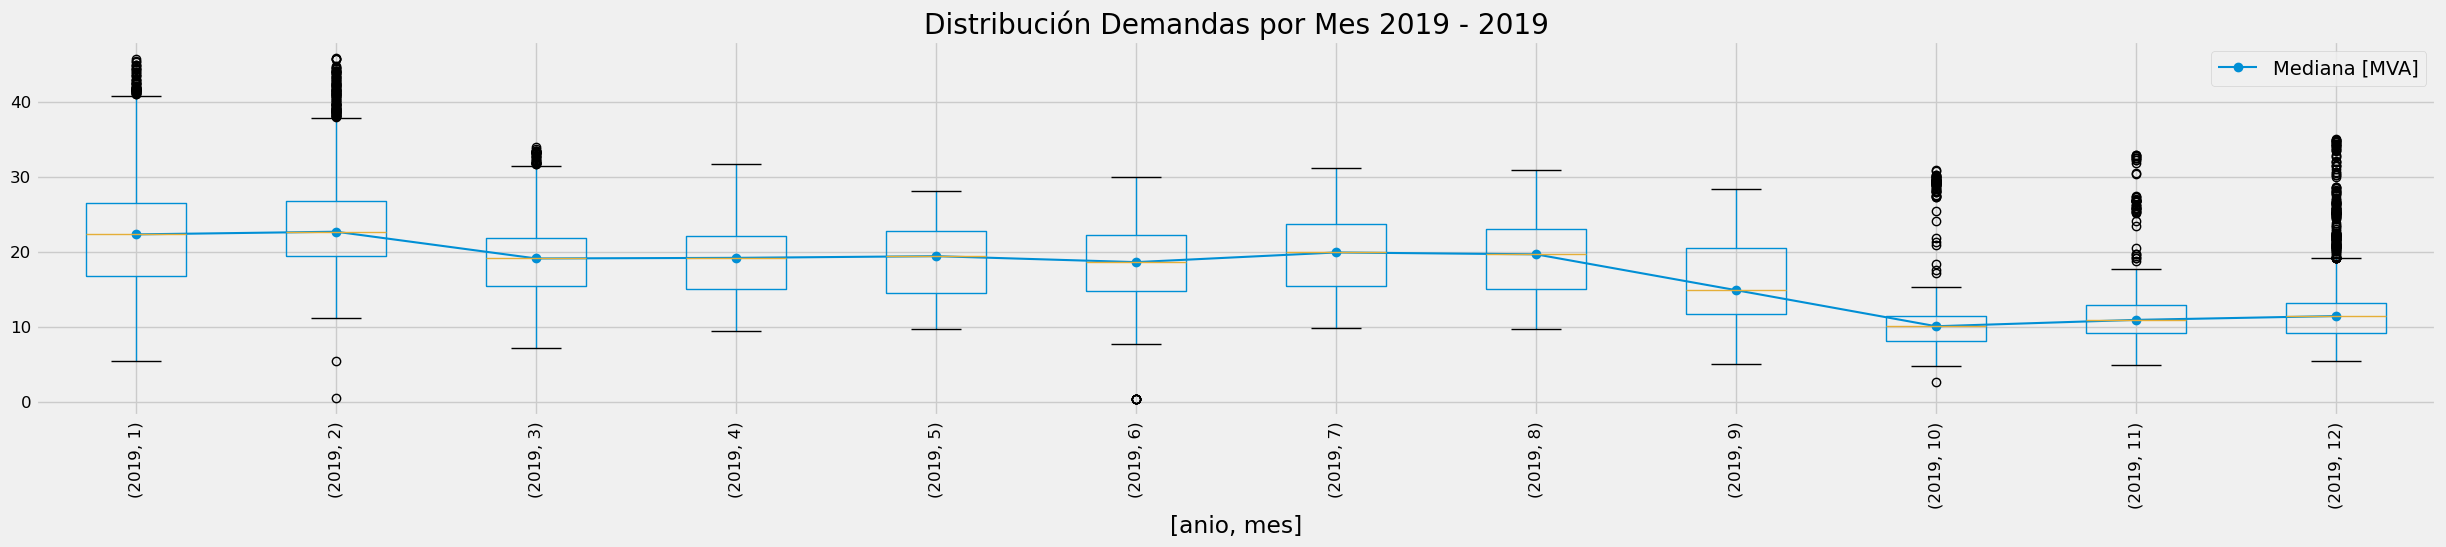

<Figure size 432x288 with 0 Axes>

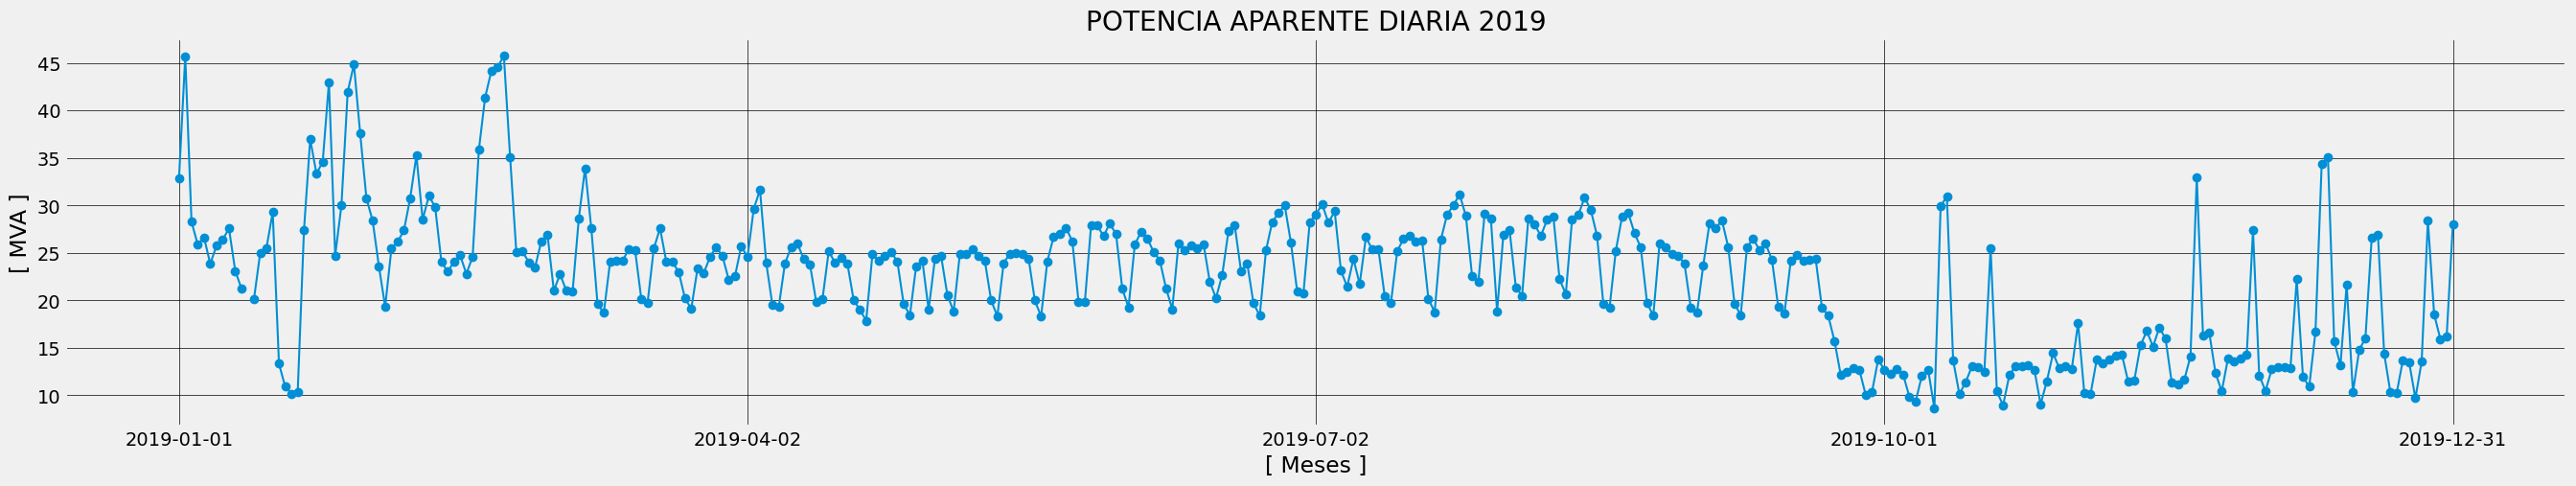

<Figure size 432x288 with 0 Axes>

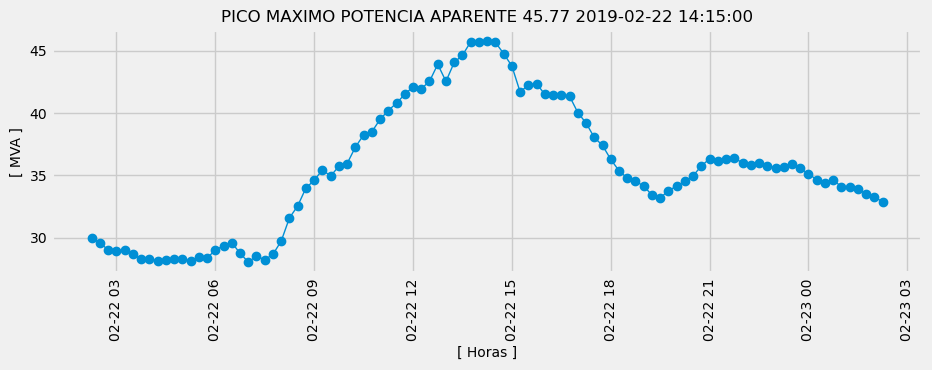

<Figure size 432x288 with 0 Axes>

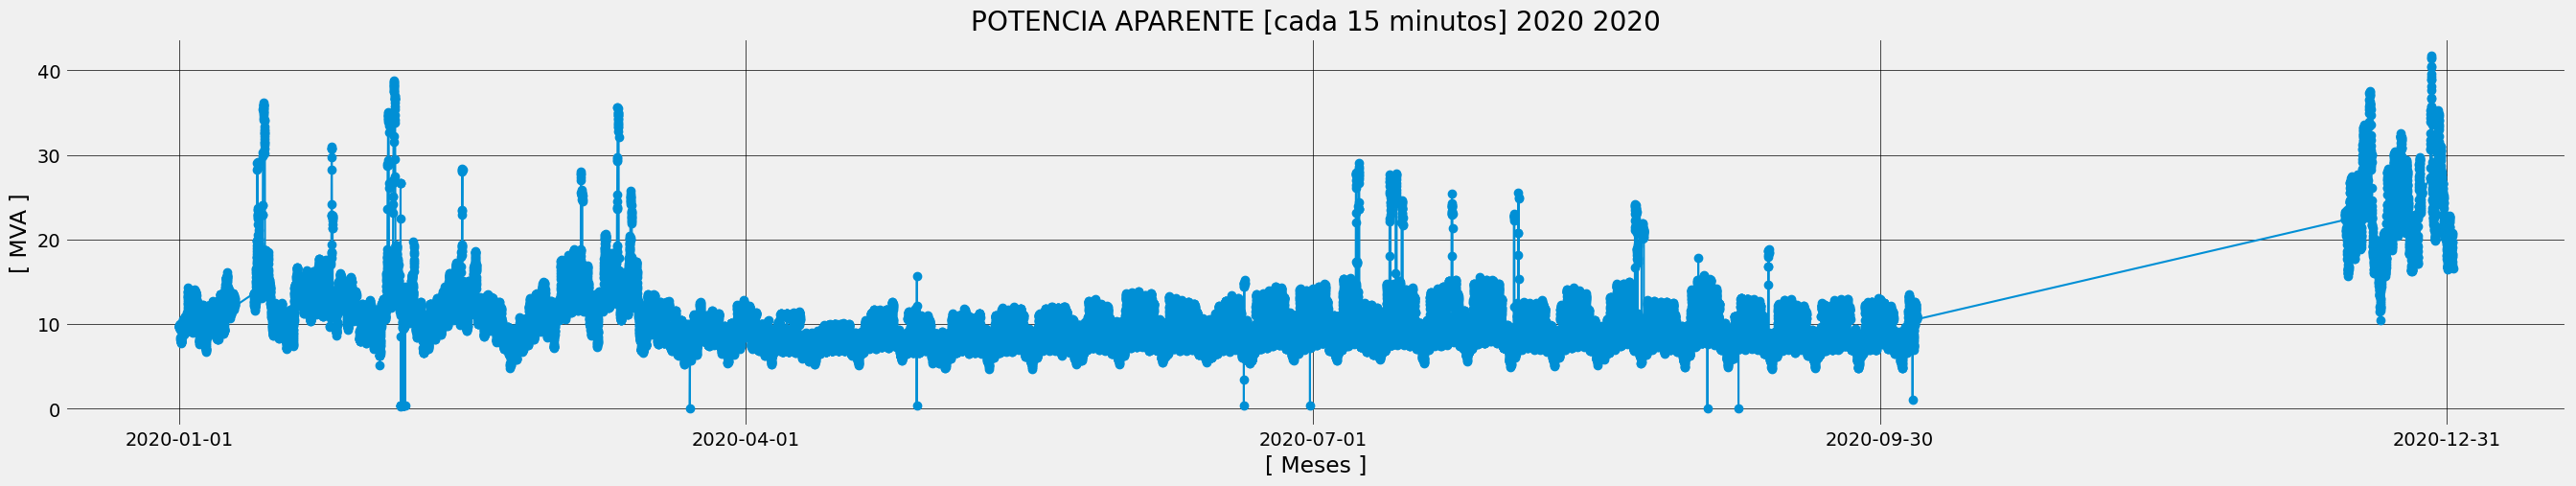

<Figure size 432x288 with 0 Axes>

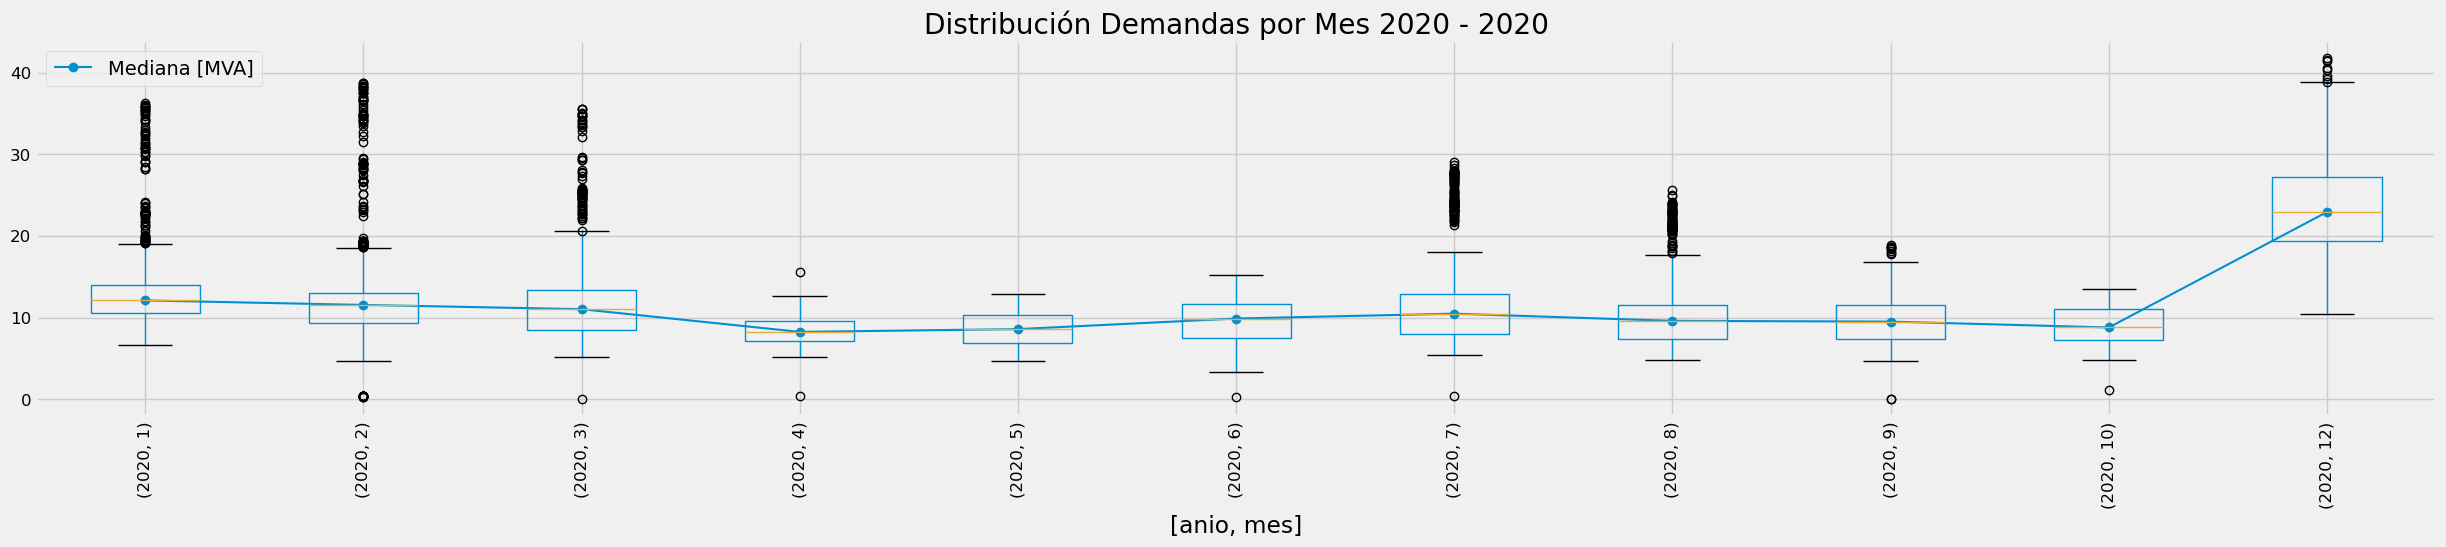

<Figure size 432x288 with 0 Axes>

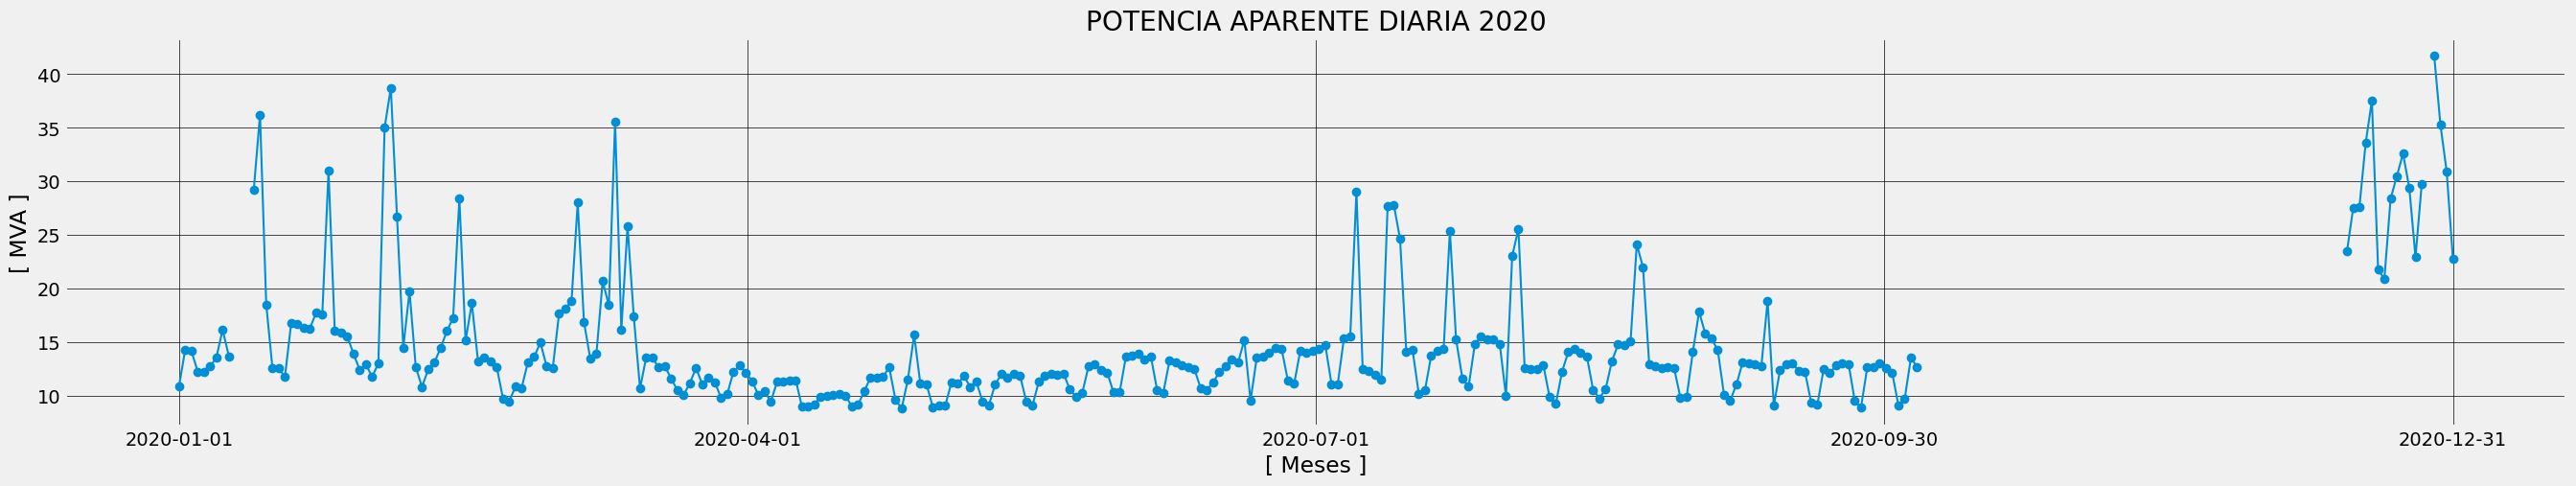

<Figure size 432x288 with 0 Axes>

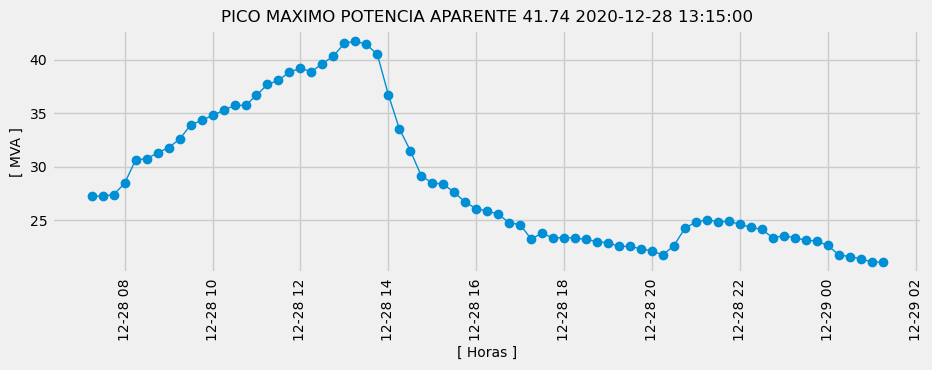

<Figure size 432x288 with 0 Axes>

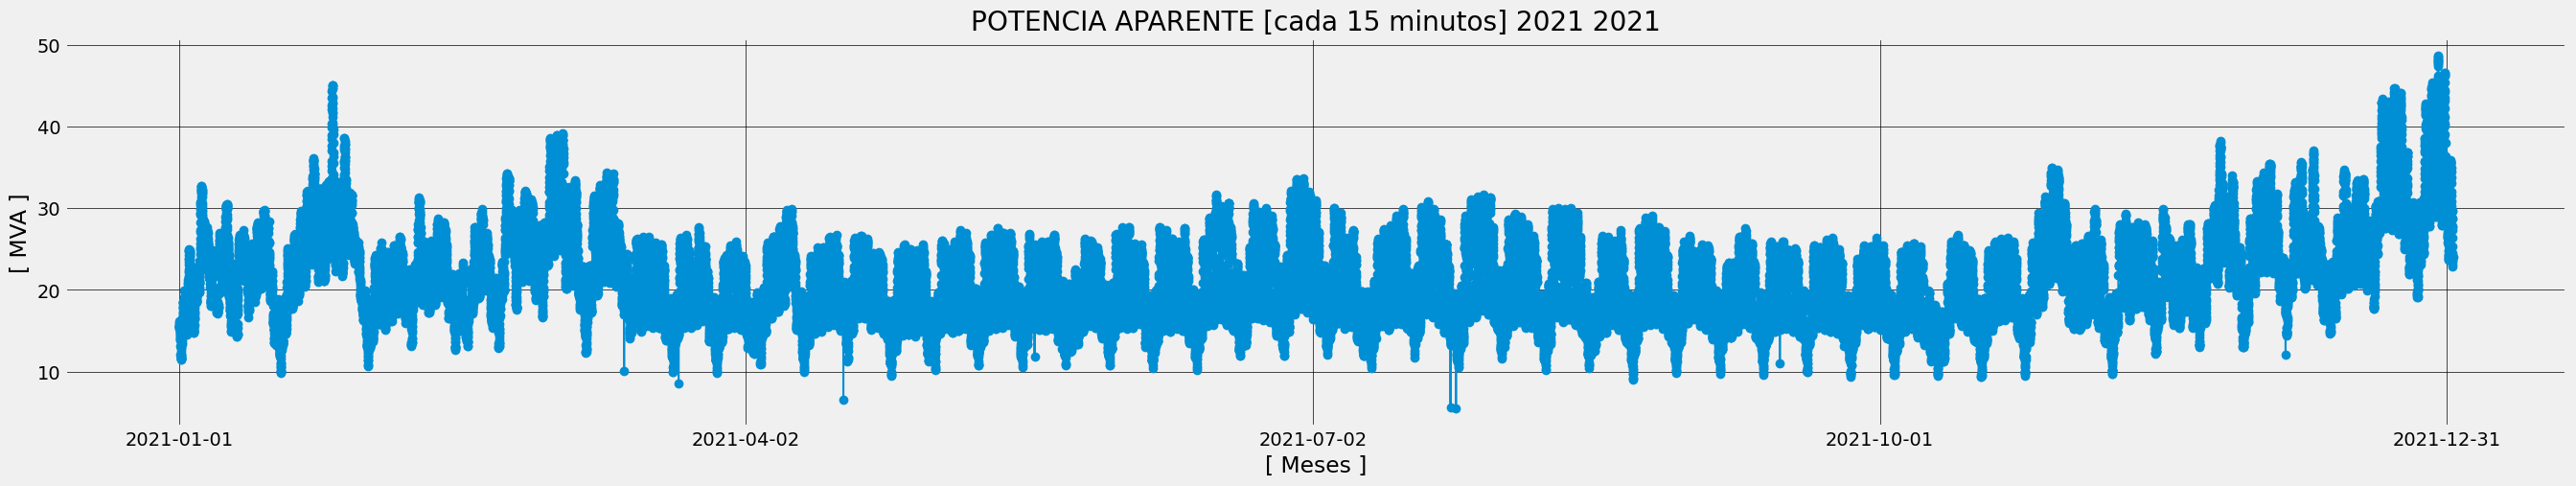

<Figure size 432x288 with 0 Axes>

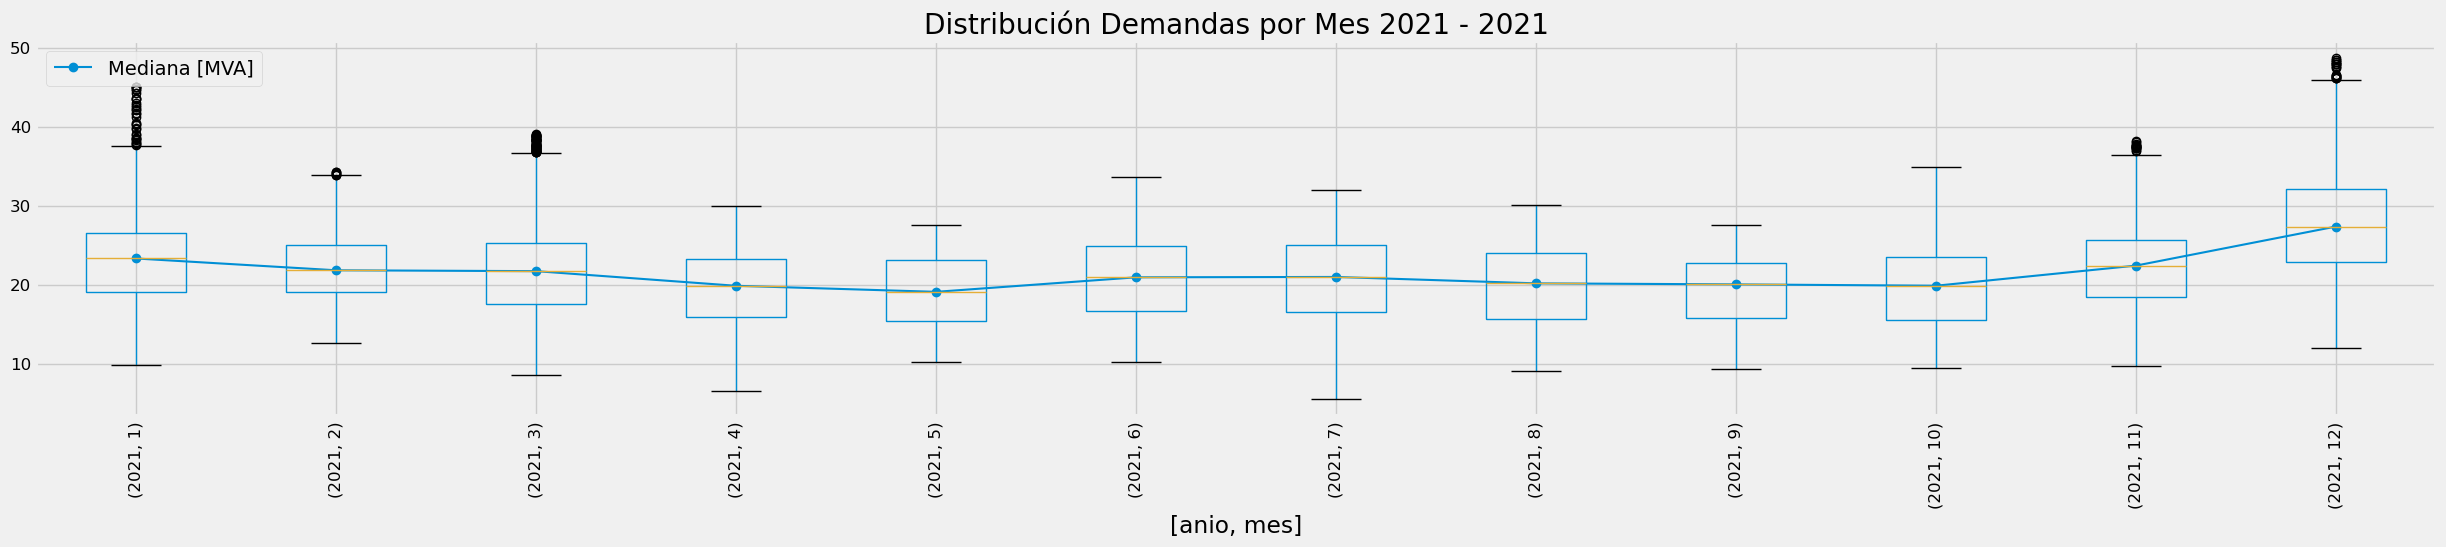

<Figure size 432x288 with 0 Axes>

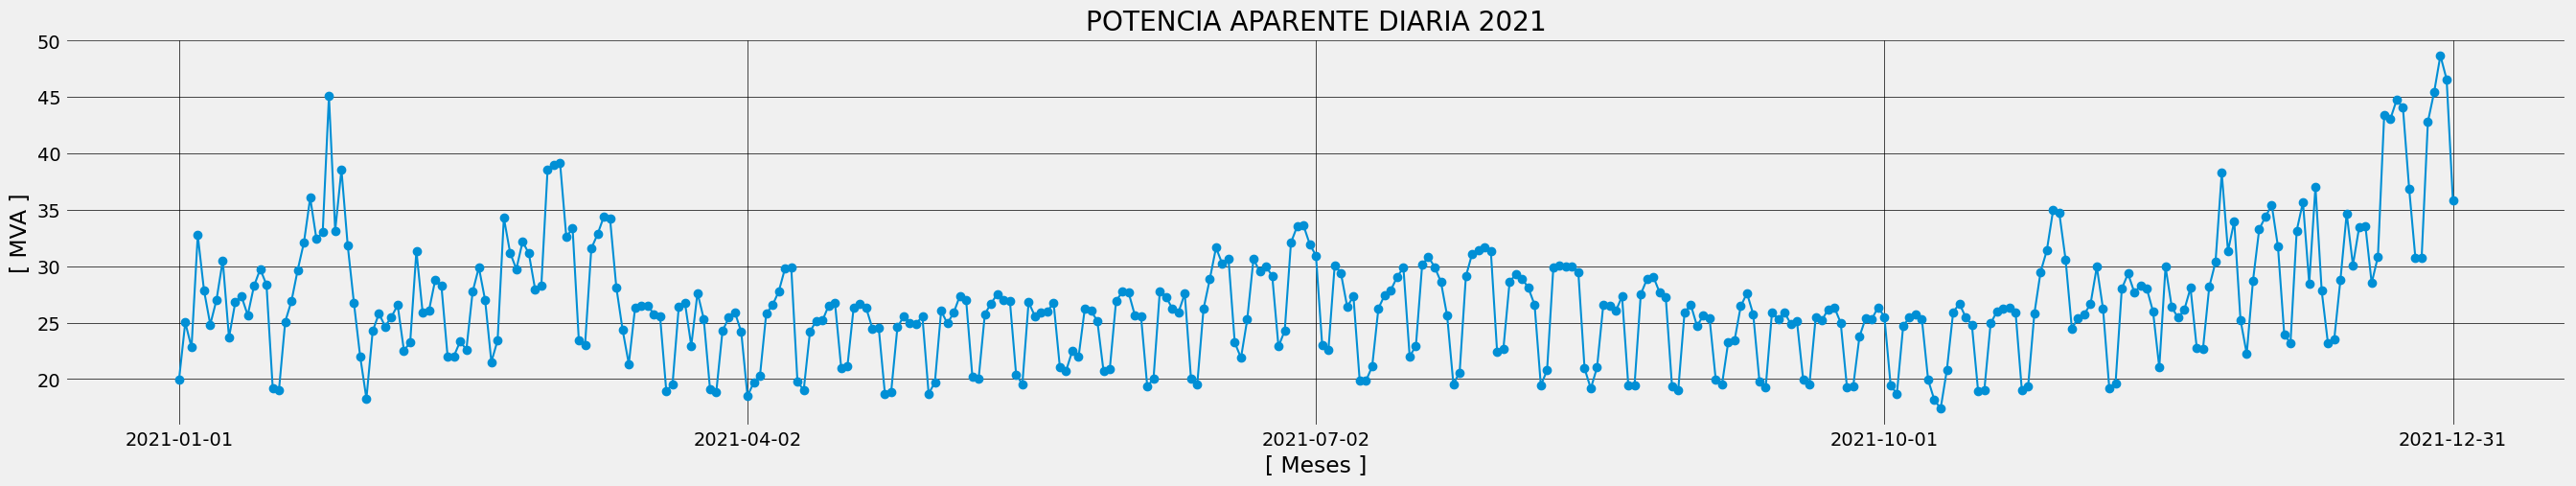

<Figure size 432x288 with 0 Axes>

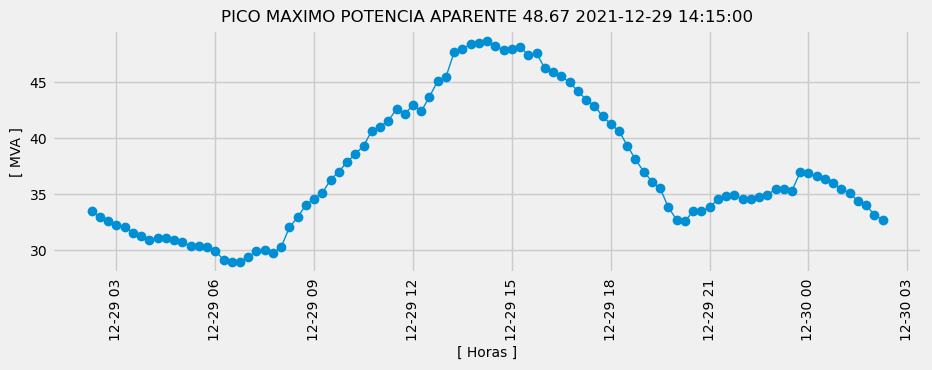

In [40]:
# LANZO LAS GRAFICAS 

anios = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

Grafica_xSemana(anios[0], anios[-1])
Grafica_Caja(anios[0], anios[-1])

for anio in anios:
    Grafica_xmin(anio, anio)
    Grafica_Caja(anio, anio)
    Grafica_xDia(anio, anio)
    Grafica_Pico_Anual(anio, anio)

## Pronosticos

### Tabla Historica

In [41]:
# 
# GENERAR TABLA EXCEL CON LOS DATOS DEPURADOS
#
anios_hist = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

Trafos = pd.Series([25.0, 25.0, 25.0], index=['TD1', 'TD2', 'TD3'])
POT_INSTALADA = Trafos.sum()

Historica = pd.DataFrame(columns = ['FECHA_HORA', 'P_MW', 'Q_MVAR', 'S_MVA'])

for anio in anios_hist:
    #Anio = pd.to_numeric(anio)
    fecha_hora_i = datos.loc[anio:anio, 'MVA'].idxmax()
    maximo_p     = datos.loc[fecha_hora_i, 'MW'].max()
    maximo_q     = datos.loc[fecha_hora_i, 'MVAR'].max()
    maximo_s     = datos.loc[fecha_hora_i, 'MVA'].max()
    Historica.loc[anio] = [fecha_hora_i, maximo_p, maximo_q, maximo_s]  
    
# Columnas derivadas
Historica['POT_INSTALADA'] = POT_INSTALADA
Historica['CRECIMIENTO_%'] = Historica['S_MVA'].pct_change().mul(100)
Historica['N-1'] = Historica['POT_INSTALADA'] - Trafos.max()   
Historica['CARGA_%'] = Historica['S_MVA'] / Historica['POT_INSTALADA'] * 100
Historica['ANIO'] = pd.to_numeric(Historica.index)

nombres_columnas = ['ANIO', 'FECHA_HORA', 'P_MW', 'Q_MVAR', 'S_MVA', 'CRECIMIENTO_%', 'POT_INSTALADA', 'N-1', 'CARGA_%']
Historica = Historica.reindex(columns=nombres_columnas)
Historica

ANIO          FECHA_HORA  P_MW  Q_MVAR  S_MVA  CRECIMIENTO_%  \
2010  2010 2010-01-05 14:00:00 36.24    8.89  37.32            NaN   
2011  2011 2011-12-20 13:30:00 39.13    9.23  40.20           7.72   
2012  2012 2012-02-16 14:00:00 42.13    9.47  43.18           7.41   
2013  2013 2013-12-26 15:00:00 41.97    7.88  42.70          -1.11   
2014  2014 2014-01-23 14:00:00 48.67   10.21  49.73          16.46   
2015  2015 2015-03-11 14:00:00 44.64   12.43  46.34          -6.82   
2016  2016 2016-02-12 13:15:00 45.93    8.94  46.79           0.97   
2017  2017 2017-03-02 13:15:00 45.16    5.41  45.48          -2.80   
2018  2018 2018-02-07 13:45:00 46.22    3.40  46.35           1.91   
2019  2019 2019-02-22 14:15:00 45.63    3.57  45.77          -1.25   
2020  2020 2020-12-28 13:15:00 41.71    1.59  41.74          -8.80   
2021  2021 2021-12-29 14:15:00 48.65    1.51  48.67          16.60   

      POT_INSTALADA   N-1  CARGA_%  
2010          75.00 50.00    49.76  
2011          75.00 50.00    53.60  
2012          75.00 50.00    57.57  
2013          75.00 50.00    56.93  
2014          75.00 50.00    66.31  
2015          75.00 50.00    61.79  
2016          75.00 50.00    62.39  
2017          75.00 50.00    60.64  
2018          75.00 50.00    61.80  
2019          75.00 50.00    61.03  
2020          75.00 50.00    55.65  
2021          75.00 50.00    64.89

### Regresion Lineal

In [43]:
pd.set_option('display.float_format', '{:.8f}'.format)
import statsmodels.formula.api as smf
lm = smf.ols(formula="S_MVA~ANIO", data = Historica).fit()
lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Ordinary least squares
================================================================
Model:              OLS              Adj. R-squared:     0.259  
Dependent Variable: S_MVA            AIC:                62.9670
Date:               2023-12-28 09:01 BIC:                63.9368
No. Observations:   12               Log-Likelihood:     -29.483
Df Model:           1                F-statistic:        4.842  
Df Residuals:       10               Prob (F-statistic): 0.0524 
R-squared:          0.326            Scale:              9.5674 
----------------------------------------------------------------
             Coef.    Std.Err.    t    P>|t|    [0.025    0.975]
----------------------------------------------------------------
Intercept  -1102.6916 521.3294 -2.1152 0.0605 -2264.2860 58.9027
ANIO           0.5692   0.2587  2.2006 0.0524    -0.0071  1.1455
----------------------------------------------------------------
Omnibus:             1.100       Durbin-Watson:          1.424  
Prob(Omnibus):       0.577       Jarque-Bera (JB):       0.040  
Skew:                0.056       Prob(JB):               0.980  
Kurtosis:            3.260       Condition No.:          1176765
================================================================
* The condition number is large (1e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

In [44]:
pd.set_option('display.float_format', '{:.2f}'.format)

Historica['S_MVA_PRED'] = lm.predict(Historica['ANIO'])

nombres_columnas = ['ANIO', 'FECHA_HORA', 'P_MW', 'Q_MVAR', 'S_MVA', 'CRECIMIENTO_%', 'S_MVA_PRED', 'POT_INSTALADA', 'N-1', 'CARGA_%']
Historica = Historica.reindex(columns=nombres_columnas)
Historica

ANIO          FECHA_HORA  P_MW  Q_MVAR  S_MVA  CRECIMIENTO_%  \
2010  2010 2010-01-05 14:00:00 36.24    8.89  37.32            NaN   
2011  2011 2011-12-20 13:30:00 39.13    9.23  40.20           7.72   
2012  2012 2012-02-16 14:00:00 42.13    9.47  43.18           7.41   
2013  2013 2013-12-26 15:00:00 41.97    7.88  42.70          -1.11   
2014  2014 2014-01-23 14:00:00 48.67   10.21  49.73          16.46   
2015  2015 2015-03-11 14:00:00 44.64   12.43  46.34          -6.82   
2016  2016 2016-02-12 13:15:00 45.93    8.94  46.79           0.97   
2017  2017 2017-03-02 13:15:00 45.16    5.41  45.48          -2.80   
2018  2018 2018-02-07 13:45:00 46.22    3.40  46.35           1.91   
2019  2019 2019-02-22 14:15:00 45.63    3.57  45.77          -1.25   
2020  2020 2020-12-28 13:15:00 41.71    1.59  41.74          -8.80   
2021  2021 2021-12-29 14:15:00 48.65    1.51  48.67          16.60   

      S_MVA_PRED  POT_INSTALADA   N-1  CARGA_%  
2010       41.39          75.00 50.00    49.76  
2011       41.96          75.00 50.00    53.60  
2012       42.53          75.00 50.00    57.57  
2013       43.10          75.00 50.00    56.93  
2014       43.67          75.00 50.00    66.31  
2015       44.24          75.00 50.00    61.79  
2016       44.81          75.00 50.00    62.39  
2017       45.38          75.00 50.00    60.64  
2018       45.95          75.00 50.00    61.80  
2019       46.51          75.00 50.00    61.03  
2020       47.08          75.00 50.00    55.65  
2021       47.65          75.00 50.00    64.89

In [45]:
print('Parametros : ', lm.params) 
print('R2 : ', lm.rsquared)

Parametros :  Intercept   -1102.69
ANIO            0.57
dtype: float64
R2 :  0.3262571112710426


### Tabla de Pronosticos

In [46]:
#
#  AGREGO LOS AÑOS DE PRONOSTICO PROPIAMENTE DICHO
#
#Pronostico  = Tablaxls.copy()
pd.set_option('display.float_format', '{:.2f}'.format)
anios_pro = ['2022', '2023', '2024', '2025', '2026']
POT_INSTALADA = Trafos.sum()
Precaucion    = POT_INSTALADA - Trafos.max()

Anio = pd.Series(pd.to_numeric(anios_pro), index=anios_pro)
Fecha_Hora = pd.Series(np.nan, index= anios_pro)
P_MW   = pd.Series(np.nan, index=anios_pro)
Q_MVAR = pd.Series(np.nan, index=anios_pro)
S_MVA  = pd.Series(np.nan, index=anios_pro)
Crecimiento = pd.Series(np.nan, index=anios_pro)

Pronostico = pd.DataFrame({'ANIO':Anio, 
                           'FECHA_HORA':Fecha_Hora, 
                           'P_MW':P_MW, 
                           'Q_MVAR':Q_MVAR,
                           'S_MVA':S_MVA,
                           'CRECIMIENTO_%':Crecimiento}, index=anios_pro)

# El MODELO DE REGRESION LINEAL          
Pronostico['S_MVA_PRED'] = lm.predict(Pronostico['ANIO'])  # Pronostico['S_MVA_PRED'] = 0.51372727*Pronostico["ANIO"] - 991.015000
#
Pronostico['POT_INSTALADA'] = POT_INSTALADA
Pronostico['N-1'] = Pronostico['POT_INSTALADA'] - Trafos.max()  
Pronostico['CARGA_%'] = Pronostico['S_MVA_PRED'] / Pronostico['POT_INSTALADA'] * 100 

Pronostico

ANIO  FECHA_HORA  P_MW  Q_MVAR  S_MVA  CRECIMIENTO_%  S_MVA_PRED  \
2022  2022         NaN   NaN     NaN    NaN            NaN       48.22   
2023  2023         NaN   NaN     NaN    NaN            NaN       48.79   
2024  2024         NaN   NaN     NaN    NaN            NaN       49.36   
2025  2025         NaN   NaN     NaN    NaN            NaN       49.93   
2026  2026         NaN   NaN     NaN    NaN            NaN       50.50   

      POT_INSTALADA   N-1  CARGA_%  
2022          75.00 50.00    64.30  
2023          75.00 50.00    65.06  
2024          75.00 50.00    65.81  
2025          75.00 50.00    66.57  
2026          75.00 50.00    67.33

In [47]:
#
# CONCATENAR LA TABLA HISTORICA + TABLA PRONOSTICO
#
Tablaxls = pd.concat([Historica,Pronostico], axis = 0)
Tablaxls

ANIO           FECHA_HORA  P_MW  Q_MVAR  S_MVA  CRECIMIENTO_%  \
2010  2010  2010-01-05 14:00:00 36.24    8.89  37.32            NaN   
2011  2011  2011-12-20 13:30:00 39.13    9.23  40.20           7.72   
2012  2012  2012-02-16 14:00:00 42.13    9.47  43.18           7.41   
2013  2013  2013-12-26 15:00:00 41.97    7.88  42.70          -1.11   
2014  2014  2014-01-23 14:00:00 48.67   10.21  49.73          16.46   
2015  2015  2015-03-11 14:00:00 44.64   12.43  46.34          -6.82   
2016  2016  2016-02-12 13:15:00 45.93    8.94  46.79           0.97   
2017  2017  2017-03-02 13:15:00 45.16    5.41  45.48          -2.80   
2018  2018  2018-02-07 13:45:00 46.22    3.40  46.35           1.91   
2019  2019  2019-02-22 14:15:00 45.63    3.57  45.77          -1.25   
2020  2020  2020-12-28 13:15:00 41.71    1.59  41.74          -8.80   
2021  2021  2021-12-29 14:15:00 48.65    1.51  48.67          16.60   
2022  2022                  NaN   NaN     NaN    NaN            NaN   
2023  2023                  NaN   NaN     NaN    NaN            NaN   
2024  2024                  NaN   NaN     NaN    NaN            NaN   
2025  2025                  NaN   NaN     NaN    NaN            NaN   
2026  2026                  NaN   NaN     NaN    NaN            NaN   

      S_MVA_PRED  POT_INSTALADA   N-1  CARGA_%  
2010       41.39          75.00 50.00    49.76  
2011       41.96          75.00 50.00    53.60  
2012       42.53          75.00 50.00    57.57  
2013       43.10          75.00 50.00    56.93  
2014       43.67          75.00 50.00    66.31  
2015       44.24          75.00 50.00    61.79  
2016       44.81          75.00 50.00    62.39  
2017       45.38          75.00 50.00    60.64  
2018       45.95          75.00 50.00    61.80  
2019       46.51          75.00 50.00    61.03  
2020       47.08          75.00 50.00    55.65  
2021       47.65          75.00 50.00    64.89  
2022       48.22          75.00 50.00    64.30  
2023       48.79          75.00 50.00    65.06  
2024       49.36          75.00 50.00    65.81  
2025       49.93          75.00 50.00    66.57  
2026       50.50          75.00 50.00    67.33

### Estilos a Tablaxls

In [49]:
# Crear una copia del DataFrame para fines de visualización 
Tablaxls_viz = Tablaxls.copy()


# Cambiar el nombre de todas las columnas
nombres_columnas = ['ANIO', 'FECHA_HORA', 'POT ACTIVA [MW]', 'POT REACTIVA [MVAR]', 'POT APARENTE [MVA]', 'CRECIMIENTO ANUAL %', 'TENDENCIA LINEAL [MVA]', 'POT INSTALADA [MVA]', 'PRECAUCION (N-1) [MVA]', '% CARGA']
Tablaxls_viz.columns = nombres_columnas

# Titulo para la Tabla
s1 = Tablaxls_viz.style.set_caption("ESTACION PRINCIPAL POT INSTALADA [MVA] = 3 x 25 + GENERACION")\
                  .set_properties(axis=1, **{"background-color": "#000000",   
                                              "color" : "white", 
                                              "border" : "0.5px solid white"})\
                   .format({"POT ACTIVA [MW]" : "{:.2f}",
                       "POT REACTIVA [MVAR]" : "{:.2f}",
                        "POT APARENTE [MVA]" : "{:.2f}",
                      "CRECIMIENTO ANUAL %"  : "{:.2f}%",
                    "TENDENCIA LINEAL [MVA]" : "{:.2f}",
                       "POT INSTALADA [MVA]" : "{:.0f}",
                    "PRECAUCION (N-1) [MVA]" : "{:.0f}",
                                   "% CARGA" : "{:.0f}%"}
                      ).hide_index()


s2 = Tablaxls_viz.loc['2022':'2026', :].style.set_properties(axis=1, **{"background-color": "green", "color" : "white", "border" : "0.5px solid white"}).hide_index()

In [50]:
s1

In [51]:
s2

### Graficas al 2026

In [57]:
# Grafica anual de la Potencia Aparente cada 15 minutos
# (Trafos + Generacion)

def Grafica_Hist_Pred():
    plt.style.use('fivethirtyeight')
    
    #y = Tablaxls.loc['2010':'2021', 'S_MVA']
    #x_y = Tablaxls.loc['2010':'2021', 'ANIO']
    
    y = Tablaxls.loc[:, 'S_MVA']
    pred = Tablaxls.loc[:, 'S_MVA_PRED']
    p_inst = Tablaxls.loc[:, 'POT_INSTALADA']
    precau = Tablaxls.loc[:, 'N-1']
    
    x = Tablaxls.loc[:, 'ANIO']
    
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(10, 2.5), dpi=100) #fig, grafico = plt.subplots(figsize=(15, 5), dpi=100) 
    #grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.plot(x, y, lw=3, label='Pot. Historica', marker='o', color='k')
    grafico.plot(x, pred, lw=3, label='Tend. Lineal', marker='o', linestyle='dotted', color='b')
    grafico.plot(x, p_inst, lw=2, label='Pot.Instalada', color='r')
    grafico.plot(x, precau, lw=2, label='Precaucion N-1', color='y')
    
    grafico.set_ylim ([20,90])
    
    grafico.set_xlabel('[ Años ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("Estacion Principal: Demanda Historica y Pronostico al 2026 ")  # Add a title to the axes.
    grafico.legend(loc='lower right')  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid() 
    
    #fig.savefig("Serie_Anual_15min_"+anio+".png")

<Figure size 432x288 with 0 Axes>

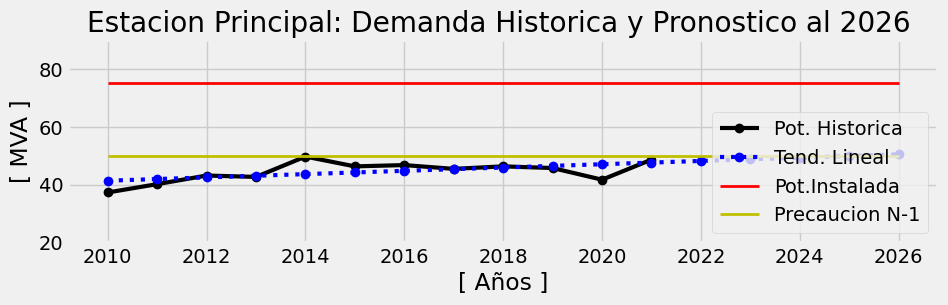

In [58]:
Grafica_Hist_Pred()

In [59]:
# Grafica anual de la Potencia Aparente cada 15 minutos
# (Trafos + Generacion)

def Grafica_Hist_Pred2():
    plt.style.use('fivethirtyeight')
    
    #y = Tablaxls.loc['2010':'2021', 'S_MVA']
    #x_y = Tablaxls.loc['2010':'2021', 'ANIO']
    
    y = Tablaxls.loc[:, 'S_MVA']
    pred = Tablaxls.loc[:, 'S_MVA_PRED']
    p_inst = Tablaxls.loc[:, 'POT_INSTALADA']
    precau = Tablaxls.loc[:, 'N-1']
    
    x = Tablaxls.loc[:, 'ANIO']
    
    fig = plt.figure()
    #fig, grafico = plt.subplots(figsize=(15, 5), dpi=100)
    fig, grafico = plt.subplots(figsize=(15, 5))
    #fig, grafico = plt.subplots(figsize=(7, 4))

    
    #grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.plot(x, y, lw=2, label='Pot. Historica', marker='o', color='k')
    grafico.plot(x, pred, lw=2, label='Tend. Lineal', marker='o', linestyle='dotted', color='b')
    #grafico.plot(x, p_inst, lw=2, label='Pot.Instalada', color='r')
    grafico.plot(x, precau, lw=2, label='Precaucion N-1', color='y')
    
    #grafico.set_ylim ([20,90])
    
    ax.minorticks_on()
    ax.grid(b=True, which='major', color='blue', alpha=1, linewidth=1)
    ax.grid(b=True, which='minor', color='beige', alpha=1, linewidth=1)
    # Major Tick Label
    # Minor Tick Label
    #plt.xticks(fontsize=10)
    #x_rotulos=[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026]
    x_rotulos = np.arange(2010,2027,1)
    plt.xticks(ticks=x, labels=x_rotulos, fontsize='x-small') 
    plt.yticks(fontsize=10)
    
    
    grafico.set_xlabel('[ Años ]', fontsize=10)  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]', fontsize=10)  # Add a y-label to the axes.
    grafico.set_title("Estacion Principal: Demanda Historica y Pronostico al 2026 ", fontsize=12)  # Add a title to the axes.
    grafico.legend(loc='lower right', fontsize=10)  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid() 
    
    #fig.savefig("Serie_Anual_15min_"+anio+".png")

<Figure size 432x288 with 0 Axes>

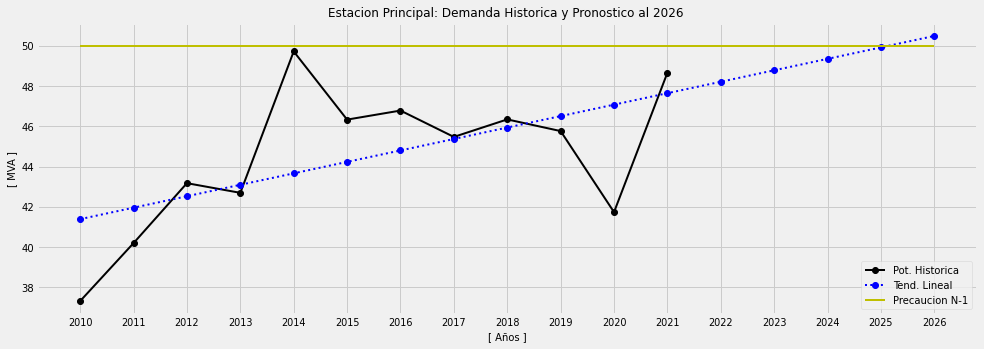

In [60]:
Grafica_Hist_Pred2()

In [62]:
# Grafica anual de la Potencia Aparente cada 15 minutos
# (Trafos + Generacion)

def Grafica_Hist_Pred_Seaborn():
    #plt.style.use(style='fivethirtyeight')
    sns.set_theme(style='darkgrid')
    
    #y = Tablaxls.loc['2010':'2021', 'S_MVA']
    #x_y = Tablaxls.loc['2010':'2021', 'ANIO']
    
    y = Tablaxls.loc[:, 'S_MVA']
    pred = Tablaxls.loc[:, 'S_MVA_PRED']
    p_inst = Tablaxls.loc[:, 'POT_INSTALADA']
    precau = Tablaxls.loc[:, 'N-1']
    
    x = Tablaxls.loc[:, 'ANIO']
    
    #fig = plt.figure()
    #fig, grafico = plt.subplots(figsize=(15, 5), dpi=100)
    fig, grafico = plt.subplots(figsize=(7, 4))
    
    sns.lineplot(x=x, y=y, err_style="bars", markers=True, dashes=True)
    sns.lineplot(x=x, y=pred, markers='o')
    sns.lineplot(x=x, y=precau, markers='o')
    #sns.lineplot(x=x, y=p_inst, markers='o')
    
#sns.lmplot(x='total_bill', y='tip', hue='sex', data=tips_df, markers=['^', 'o'], 
         # scatter_kws={'s': 100, 'linewidth': 0.5, 'edgecolor': 'black'})

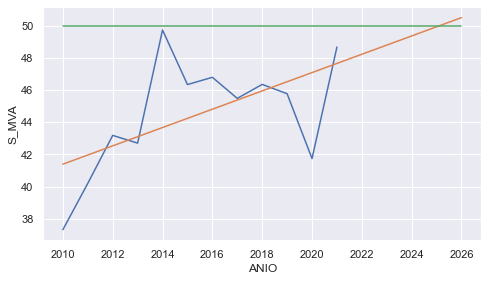

In [63]:
Grafica_Hist_Pred_Seaborn()

In [64]:
Tablaxls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 2010 to 2026
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ANIO           17 non-null     int64  
 1   FECHA_HORA     12 non-null     object 
 2   P_MW           12 non-null     float64
 3   Q_MVAR         12 non-null     float64
 4   S_MVA          12 non-null     float64
 5   CRECIMIENTO_%  11 non-null     float64
 6   S_MVA_PRED     17 non-null     float64
 7   POT_INSTALADA  17 non-null     float64
 8   N-1            17 non-null     float64
 9   CARGA_%        17 non-null     float64
dtypes: float64(8), int64(1), object(1)
memory usage: 2.0+ KB


In [65]:
Tablaxls["RSE"] = (Tablaxls["S_MVA"]-Tablaxls["S_MVA_PRED"])**2
Tablaxls

ANIO           FECHA_HORA  P_MW  Q_MVAR  S_MVA  CRECIMIENTO_%  \
2010  2010  2010-01-05 14:00:00 36.24    8.89  37.32            NaN   
2011  2011  2011-12-20 13:30:00 39.13    9.23  40.20           7.72   
2012  2012  2012-02-16 14:00:00 42.13    9.47  43.18           7.41   
2013  2013  2013-12-26 15:00:00 41.97    7.88  42.70          -1.11   
2014  2014  2014-01-23 14:00:00 48.67   10.21  49.73          16.46   
2015  2015  2015-03-11 14:00:00 44.64   12.43  46.34          -6.82   
2016  2016  2016-02-12 13:15:00 45.93    8.94  46.79           0.97   
2017  2017  2017-03-02 13:15:00 45.16    5.41  45.48          -2.80   
2018  2018  2018-02-07 13:45:00 46.22    3.40  46.35           1.91   
2019  2019  2019-02-22 14:15:00 45.63    3.57  45.77          -1.25   
2020  2020  2020-12-28 13:15:00 41.71    1.59  41.74          -8.80   
2021  2021  2021-12-29 14:15:00 48.65    1.51  48.67          16.60   
2022  2022                  NaN   NaN     NaN    NaN            NaN   
2023  2023                  NaN   NaN     NaN    NaN            NaN   
2024  2024                  NaN   NaN     NaN    NaN            NaN   
2025  2025                  NaN   NaN     NaN    NaN            NaN   
2026  2026                  NaN   NaN     NaN    NaN            NaN   

      S_MVA_PRED  POT_INSTALADA   N-1  CARGA_%   RSE  
2010       41.39          75.00 50.00    49.76 16.58  
2011       41.96          75.00 50.00    53.60  3.10  
2012       42.53          75.00 50.00    57.57  0.42  
2013       43.10          75.00 50.00    56.93  0.16  
2014       43.67          75.00 50.00    66.31 36.74  
2015       44.24          75.00 50.00    61.79  4.42  
2016       44.81          75.00 50.00    62.39  3.93  
2017       45.38          75.00 50.00    60.64  0.01  
2018       45.95          75.00 50.00    61.80  0.16  
2019       46.51          75.00 50.00    61.03  0.55  
2020       47.08          75.00 50.00    55.65 28.56  
2021       47.65          75.00 50.00    64.89  1.03  
2022       48.22          75.00 50.00    64.30   NaN  
2023       48.79          75.00 50.00    65.06   NaN  
2024       49.36          75.00 50.00    65.81   NaN  
2025       49.93          75.00 50.00    66.57   NaN  
2026       50.50          75.00 50.00    67.33   NaN

(array([1., 1., 0., 1., 3., 3., 2., 0., 0., 1.]),
 array([-5.34388112, -4.20336364, -3.06284615, -1.92232867, -0.78181119,
         0.35870629,  1.49922378,  2.63974126,  3.78025874,  4.92077622,
         6.06129371]),
 <BarContainer object of 10 artists>)

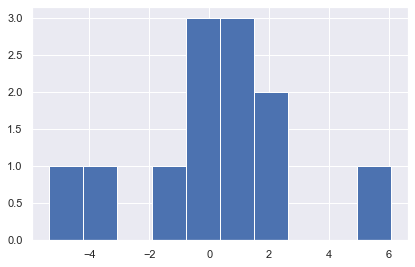

In [66]:
plt.hist((Tablaxls["S_MVA"]-Tablaxls["S_MVA_PRED"]))

## Conclusiones

Como podemos deducir de los graficos la Estacion Principal presenta demandas pronunciadas en epocas estivales durante los meses de Diciembre, Enero y Marzo.

Debido a su ubicacion en la red electrica es necesario tener generacion local para mantener los niveles de tension aconsejados por CAMMESA.